In [39]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


## V3: Successfully implemented Sarsa + softmax + model fitting

{1: [2], 2: [1, 3], 3: [2, 4, 11], 4: [3, 5], 5: [4], 6: [7], 7: [6, 8], 8: [7, 9, 13], 9: [8, 10], 10: [9], 11: [3, 12], 12: [11, 13], 13: [8, 12]}

==== Final MLE ====
alpha=0.20435, gamma=0.00000, beta=0.34139
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.50923D+02    |proj g|=  2.30259D+00

At iterate    1    f=  5.97161D+02    |proj g|=  1.00000D+00

At iterate    2    f=  5.82470D+02    |proj g|=  4.60517D+00

At iterate    3    f=  5.77686D+02    |proj g|=  4.48163D+00

At iterate    4    f=  5.62089D+02    |proj g|=  3.90327D+00

At iterate    5    f=  5.59819D+02    |proj g|=  3.71163D+00

At iterate    6    f=  5.57893D+02    |proj g|=  3.59109D+00

At iterate    7    f=  5.56135D+02    |proj g|=  1.21951D+00

At iterate    8    f=  5.54740D+02    |proj g|=  1.35053D+00

At iterate    9    f=  5.53439D+02    |proj g|=  3.52884D-01


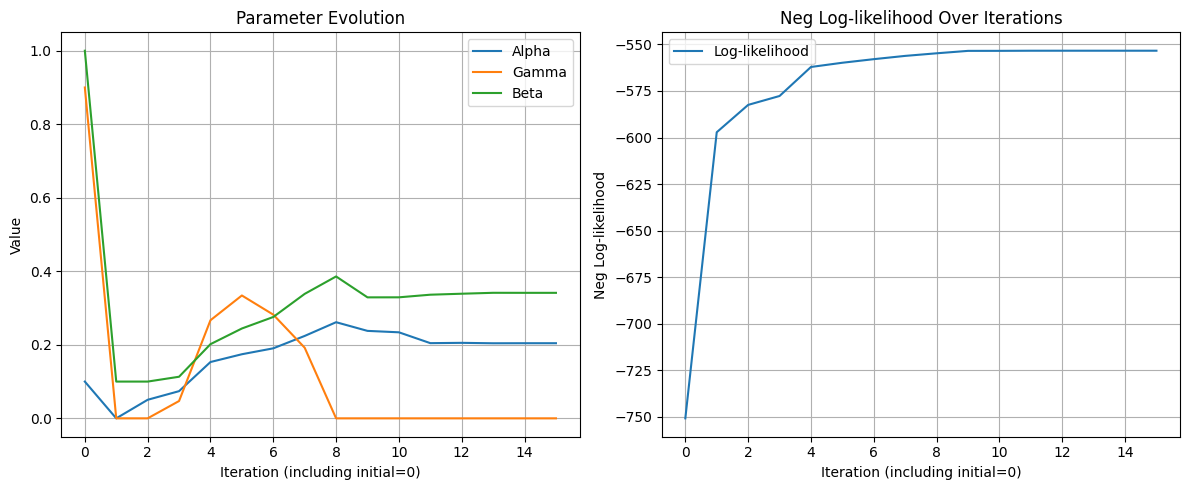

Model vs Real 'NextState' match ratio (overall): 48.2%
Match ratio for states with 2 choices: 55.0%   (n=516 trials)
Match ratio for states with 3 choices: 30.3%   (n=218 trials)


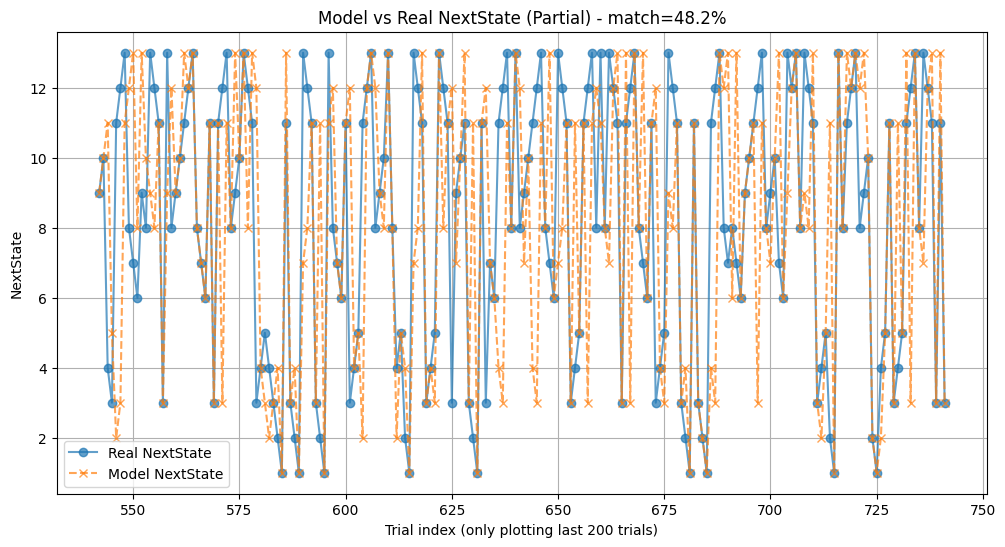

Final Q dictionary:
 State 1 -> Q-values:
    to 2: -0.20
 State 2 -> Q-values:
    to 1: 4.95
    to 3: -0.94
 State 3 -> Q-values:
    to 2: -1.00
    to 4: -1.00
    to 11: -1.00
 State 4 -> Q-values:
    to 3: -0.99
    to 5: 4.10
 State 5 -> Q-values:
    to 4: -0.68
 State 6 -> Q-values:
    to 7: 0.00
 State 7 -> Q-values:
    to 6: 4.99
    to 8: -0.68
 State 8 -> Q-values:
    to 7: -1.00
    to 9: -1.00
    to 13: -1.00
 State 9 -> Q-values:
    to 8: -0.87
    to 10: 4.68
 State 10 -> Q-values:
    to 9: -0.37
 State 11 -> Q-values:
    to 3: 0.20
    to 12: -1.00
 State 12 -> Q-values:
    to 11: -1.00
    to 13: -1.00
 State 13 -> Q-values:
    to 8: 1.41
    to 12: -1.00


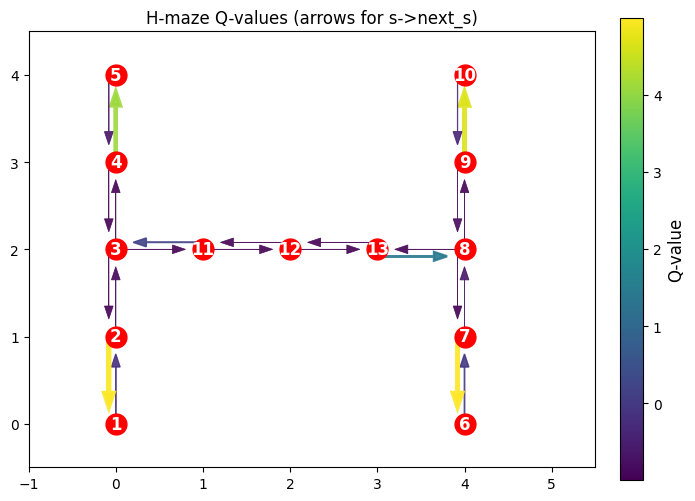

Done!


In [ ]:
np.random.seed(1234)

# ------------------------
# env（State & Action）
# ------------------------
class HMazeEnvironment:
    '''
    - states: 1..13
    - actions = "choose which state to transfer to"
    - self.legal_next_states[s] stores states (legal next states)
    '''
    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self.build_transitions()
        self.legal_next_states = self.build_legal_next_states()

    def build_transitions(self):
        transitions = {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11, 2: 3,   3: 12},
            12: {0: 12, 1: 12, 2: 11,  3: 13},
            13: {0: 13, 1: 13, 2: 12,  3: 8}
        }
        return transitions

    def build_legal_next_states(self):
        legal_dict = {}
        for s in self.states:
            possible_next = set(self.transitions[s].values())
            # 去掉留在原地的选项
            if s in possible_next:
                possible_next.remove(s)

            legal_dict[s] = sorted(list(possible_next))

        print(legal_dict)

        return legal_dict

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state


# ------------------------
# Init Q 
# ------------------------
def initialize_Q_dict(env):
    Q = {}
    for s in env.states:
        Q[s] = {}
        for nx in env.legal_next_states[s]:
            Q[s][nx] = 0.0
    return Q

# ------------------------
# Softmax
# ------------------------
def softmax(Q_values, beta):
    shifted = Q_values - np.max(Q_values)
    exp_vals = np.exp(beta*shifted)
    return exp_vals / (exp_vals.sum() + 1e-12)


# ------------------------
# (CurrentState, ChosenState) as (s, a)
# ------------------------
def prepare_observed_data(env, df):
    observed_data = []
    for _, row in df.iterrows():
        cst = row['CurrentState']
        cho = row['ChosenState']
        gst = row['Goal']
        sdate = row.get('session_date','unknown')
        epid  = row.get('TotalEpisodeNum', None)
        tidx  = row.get('TrialNum', None)

        observed_data.append({
            'SessionDate': sdate,
            'EpisodeID':   epid,
            'TrialIndex':  tidx,
            'CurrentState': cst,
            'ChosenState': cho, 
            'GoalState':    gst
        })
    return observed_data


# ------------------------
# negLogLikelihood: SARSA(λ=0) (optional：reset Q every episode)
# ------------------------
def log_likelihood(params, observed_data, env, reset_q_each_episode=False):
    alpha, gamma, log_beta = params
    beta = np.exp(log_beta)

    Q = initialize_Q_dict(env)
    neg_log_lik = 0.0

    sorted_data = sorted(
        observed_data,
        key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex'])
    )

    current_episode = None

    for i in range(len(sorted_data)):
        tr = sorted_data[i]
        ep_id = tr['EpisodeID']
        st    = tr['CurrentState']
        cho   = tr['ChosenState']  
        gst   = tr['GoalState']

        if reset_q_each_episode and (ep_id != current_episode):
            Q = initialize_Q_dict(env)
            current_episode = ep_id

        legal_nexts = list(Q[st].keys()) 

        qvals = np.array([Q[st][nx] for nx in legal_nexts])
        probs = softmax(qvals, beta)
        chosen_idx = legal_nexts.index(cho)
        chosen_prob = probs[chosen_idx]

        neg_log_lik -= np.log(chosen_prob + 1e-12)

        nxt_st = env.get_next_state(st, cho)
        reward = 5 if (nxt_st == gst) else -1


        if i < len(sorted_data) - 1:
            nxt_tr = sorted_data[i+1]

            if nxt_tr['EpisodeID'] == ep_id:
                nxt_s  = nxt_tr['CurrentState']
                nxt_a  = nxt_tr['ChosenState']  

                Q[st][cho] += alpha * (
                    reward + gamma * Q[nxt_st].get(nxt_a, 0.0) - Q[st][cho]
                )
            else:
                Q[st][cho] += alpha * (reward - Q[st][cho])
        else:
            Q[st][cho] += alpha * (reward - Q[st][cho])
    
    return neg_log_lik


# ------------------------
# estimate params
# ------------------------
def fit_sarsa_parameters_with_tracking(observed_data, env, reset_q_each_episode=False):
    init_params = [0.1, 0.9, np.log(1)]
    bounds = [(0,1),(0,1),(np.log(0.1), np.log(10))]

    param_history = [init_params.copy()]
    init_ll = -log_likelihood(init_params, observed_data, env, reset_q_each_episode)
    likelihood_history=[init_ll]

    def callback(p):
        pp = p.copy()
        param_history.append(pp)
        ll = -log_likelihood(pp, observed_data, env, reset_q_each_episode)
        likelihood_history.append(ll)

    res = minimize(
        lambda p: log_likelihood(p, observed_data, env, reset_q_each_episode),
        init_params,
        method='L-BFGS-B',
        bounds=bounds,
        callback=callback,
        options={'maxiter':200,'disp':True}
    )

    best_params = res.x
    return best_params, param_history, likelihood_history


# ------------------------
# simulation
# ------------------------
'''
def simulate_actions_with_sarsa(env, observed_data, alpha, gamma, beta, reset_q_each_episode=False):
    Q = initialize_Q_dict(env)
    sorted_data = sorted(
        observed_data,
        key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex'])
    )
    sim_actions = []
    current_episode = None

    for i in range(len(sorted_data)):
        tr = sorted_data[i]
        ep_id = tr['EpisodeID']
        st    = tr['CurrentState']
        gst   = tr['GoalState']

        if reset_q_each_episode and (ep_id != current_episode):
            Q = initialize_Q_dict(env)
            current_episode = ep_id

        legal_nexts = list(Q[st].keys())
        if len(legal_nexts) == 0:
            sim_actions.append(st)  
            continue

        # softmax
        qvals = np.array([Q[st][nx] for nx in legal_nexts])
        probs = softmax(qvals, beta)
        chosen_idx = np.random.choice(len(legal_nexts), p=probs)
        chosen_next_st = legal_nexts[chosen_idx]
        sim_actions.append(chosen_next_st)

        nxt_st = env.get_next_state(st, chosen_next_st)
        reward = 1 if (nxt_st == gst) else 0.2

        if i < len(sorted_data) - 1:
            nxt_tr = sorted_data[i+1]
            if nxt_tr['EpisodeID'] == ep_id:
                nxt_s  = nxt_tr['CurrentState']
                nxt_a  = nxt_tr['ChosenState']  
                Q[st][chosen_next_st] += alpha * (
                    reward + gamma * Q[nxt_st].get(nxt_a, 0.0) - Q[st][chosen_next_st]
                )
            else:
                Q[st][chosen_next_st] += alpha * (reward - Q[st][chosen_next_st])
        else:
            Q[st][chosen_next_st] += alpha * (reward - Q[st][chosen_next_st])

    return sim_actions, Q
'''

def simulate_actions_with_sarsa(env, observed_data, alpha, gamma, beta, reset_q_each_episode=False):
    Q = initialize_Q_dict(env)
    sorted_data = sorted(observed_data, key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex']))
    sim_actions = []
    current_episode = None

    for i in range(len(sorted_data)):
        tr = sorted_data[i]
        ep_id = tr['EpisodeID']
        st    = tr['CurrentState']
        gst   = tr['GoalState']

        if reset_q_each_episode and (ep_id != current_episode):
            Q = initialize_Q_dict(env)
            current_episode = ep_id

        legal_nexts = list(Q[st].keys())
        if len(legal_nexts) == 0:
            sim_actions.append(st)
            continue

        qvals = np.array([Q[st][nx] for nx in legal_nexts])
        probs = softmax(qvals, beta)
        chosen_idx = np.random.choice(len(legal_nexts), p=probs)
        chosen_next_st = legal_nexts[chosen_idx]
        sim_actions.append(chosen_next_st)

        # current reward
        nxt_st = env.get_next_state(st, chosen_next_st)
        reward = 5 if (nxt_st == gst) else -1

        # if have next trial and in the same episode, use own strategy to choose nxt_a
        if (i < len(sorted_data) - 1) and (sorted_data[i+1]['EpisodeID'] == ep_id):
            nxt_s = nxt_st
            nxt_legal = list(Q[nxt_s].keys())
            if len(nxt_legal) > 0:
                nxt_qvals = np.array([Q[nxt_s][nx2] for nx2 in nxt_legal])
                nxt_probs = softmax(nxt_qvals, beta)
                nxt_a_idx = np.random.choice(len(nxt_legal), p=nxt_probs)
                nxt_a_sim = nxt_legal[nxt_a_idx]

                Q[st][chosen_next_st] += alpha * (
                    reward + gamma * Q[nxt_s][nxt_a_sim] - Q[st][chosen_next_st]
                )
            else:
                Q[st][chosen_next_st] += alpha * (reward - Q[st][chosen_next_st])

        else:
            Q[st][chosen_next_st] += alpha * (reward - Q[st][chosen_next_st])

    return sim_actions, Q



def plot_hmaze_Q_arrows(Q, env):
    coords = {
        1:(0,0),  2:(0,1),  3:(0,2),  4:(0,3),  5:(0,4),
        6:(4,0),  7:(4,1),  8:(4,2),  9:(4,3),  10:(4,4),
        11:(1,2), 12:(2,2), 13:(3,2)
    }

    plt.figure(figsize=(8,6))
    plt.title("H-maze Q-values (arrows for s->next_s)")

    all_q_vals = []
    for s in Q:
        for nx in Q[s]:
            all_q_vals.append(Q[s][nx])
    if len(all_q_vals) == 0:
        print("No Q values to plot!")
        return
    
    Q_min, Q_max = min(all_q_vals), max(all_q_vals)
    if Q_min == Q_max:
        Q_min -= 0.01
        Q_max += 0.01
    eps = 1e-12

    cmap = plt.cm.viridis
    norm = mpl.colors.Normalize(vmin=Q_min, vmax=Q_max)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  

    for s in env.states:
        if s in coords:
            sx, sy = coords[s]
            plt.plot(sx, sy, 'ro', markersize=15, zorder=3)  
            plt.text(sx, sy, f"{s}", ha='center', va='center',
                     fontsize=12, color="white", fontweight='bold', zorder=4)

    drawn_edges = set()
    offset_factor = 0.08 
    for s in env.states:
        if s not in coords:
            continue
        sx, sy = coords[s]
        if s not in Q:
            continue

        for nx, q_val in Q[s].items():
            if nx not in coords:
                continue
            nx_x, nx_y = coords[nx]
            dx = nx_x - sx
            dy = nx_y - sy

            norm_val = (q_val - Q_min) / (Q_max - Q_min + eps)
            lw = 0.5 + 3.0 * norm_val 
            color = cmap(norm_val)

            edge_key_1 = f"{s}->{nx}"
            edge_key_2 = f"{nx}->{s}"
            if edge_key_2 in drawn_edges:

                perp_x =  dy
                perp_y = -dx

                norm_len = np.sqrt(perp_x**2 + perp_y**2) + eps
                perp_x /= norm_len
                perp_y /= norm_len

                perp_x *= offset_factor
                perp_y *= offset_factor

                sx_off = sx + perp_x
                sy_off = sy + perp_y

                plt.arrow(
                    sx_off, sy_off, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            else:
                plt.arrow(
                    sx, sy, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            drawn_edges.add(edge_key_1)

    plt.gca().set_aspect('equal', 'box')
    plt.xlim(-1, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.grid(False)

    cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label("Q-value", fontsize=12)

    plt.show()



# ------------------------
# main
# ------------------------
if __name__ == "__main__":
    env = HMazeEnvironment()

    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    files = [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]
    dfs=[]
    for fn in files:
        fpath = os.path.join(data_path, fn)
        df = pd.read_csv(fpath, delimiter=',')
        try:
            sdate = "_".join(fn.split('_')[1:4])
        except:
            sdate= "unknown"
        df['session_date']= sdate
        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True)
    all_df = all_df.sort_values(by=['session_date','TotalEpisodeNum','TrialNum']).reset_index(drop=True)

    all_df = all_df[ (all_df['Choice'] != -1 ) & (all_df['Control'] == 0) ]
    #all_df = all_df[ all_df['Goal'] == 10 ]
    all_df = all_df[ all_df['session_date'] == '2024_07_10' ]

    observed_data = prepare_observed_data(env, all_df)

    ep_counts = Counter((d['GoalState'], d['SessionDate'], d['EpisodeID']) for d in observed_data)
    for k, c in ep_counts.items():
        if c>20:
            print("Warning: Episode", k, "has", c, "trials! Possibly abnormal data?")

    best_params, param_history, likelihood_history = fit_sarsa_parameters_with_tracking(
        observed_data, env, reset_q_each_episode=False
    )
    alpha_est, gamma_est, log_beta_est = best_params
    beta_est = np.exp(log_beta_est)

    print("\n==== Final MLE ====")
    print(f"alpha={alpha_est:.5f}, gamma={gamma_est:.5f}, beta={beta_est:.5f}")

    alpha_vals = [p[0] for p in param_history]
    gamma_vals = [p[1] for p in param_history]
    beta_vals  = [np.exp(p[2]) for p in param_history]

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(alpha_vals, label='Alpha')
    plt.plot(gamma_vals, label='Gamma')
    plt.plot(beta_vals,  label='Beta')
    plt.xlabel("Iteration (including initial=0)")
    plt.ylabel("Value")
    plt.title("Parameter Evolution")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(likelihood_history, label='Log-likelihood')
    plt.xlabel("Iteration (including initial=0)")
    plt.ylabel("Neg Log-likelihood")
    plt.title("Neg Log-likelihood Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    sim_actions, final_Q = simulate_actions_with_sarsa(
        env, observed_data, alpha_est, gamma_est, beta_est, reset_q_each_episode = False  
    )

    sorted_data = sorted(
        observed_data,
        key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex'])
    )
    real_actions = [d['ChosenState'] for d in sorted_data]
    match_count = sum(int(r == s) for r, s in zip(real_actions, sim_actions))
    match_ratio = match_count / len(real_actions)
    print(f"Model vs Real 'NextState' match ratio (overall): {match_ratio:.1%}")

    # ------------------------
    # separate 2choice and 3choice case
    # ------------------------
    num_2_match = 0
    num_2_total = 0
    num_3_match = 0
    num_3_total = 0

    for i, (rd, model_act) in enumerate(zip(sorted_data, sim_actions)):
        st = rd['CurrentState']
        real_act = rd['ChosenState']
        choice_count = len(env.legal_next_states[st])

        if choice_count == 2:
            num_2_total += 1
            if real_act == model_act:
                num_2_match += 1
        elif choice_count == 3:
            num_3_total += 1
            if real_act == model_act:
                num_3_match += 1

    match_2_ratio = num_2_match / num_2_total if num_2_total > 0 else 0
    match_3_ratio = num_3_match / num_3_total if num_3_total > 0 else 0

    print(f"Match ratio for states with 2 choices: {match_2_ratio:.1%}   (n={num_2_total} trials)")
    print(f"Match ratio for states with 3 choices: {match_3_ratio:.1%}   (n={num_3_total} trials)")

    # only plot last 200 trials: real action vs simulated action
    n = len(real_actions)
    num_to_plot = 200
    start_idx = max(0, n - num_to_plot)

    plt.figure(figsize=(12,6))
    plt.plot(range(start_idx,n), real_actions[start_idx:], 'o-', label='Real NextState', alpha=0.7)
    plt.plot(range(start_idx,n), sim_actions[start_idx:], 'x--', label='Model NextState', alpha=0.7)
    plt.xlabel(f"Trial index (only plotting last {num_to_plot} trials)")
    plt.ylabel("NextState")
    plt.title(f"Model vs Real NextState (Partial) - match={match_ratio:.1%}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Final Q dictionary:")
    for s in sorted(final_Q.keys()):
        print(f" State {s} -> Q-values:")
        for nx, val in final_Q[s].items():
            print(f"    to {nx}: {val:.2f}")

    plot_hmaze_Q_arrows(final_Q, env)

    print("Done!")


=== Best Fitting Parameters ===
Alpha   = 0.3799
Gamma   = 0.0010
Beta    = 0.4177
Forget  = 0.6871
Neg Log-Likelihood = 10214.82


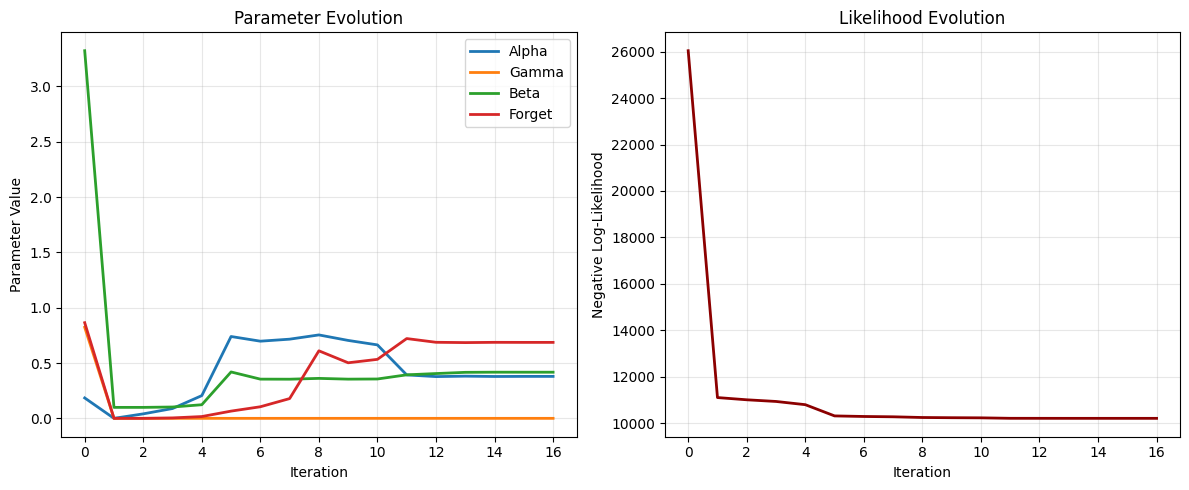

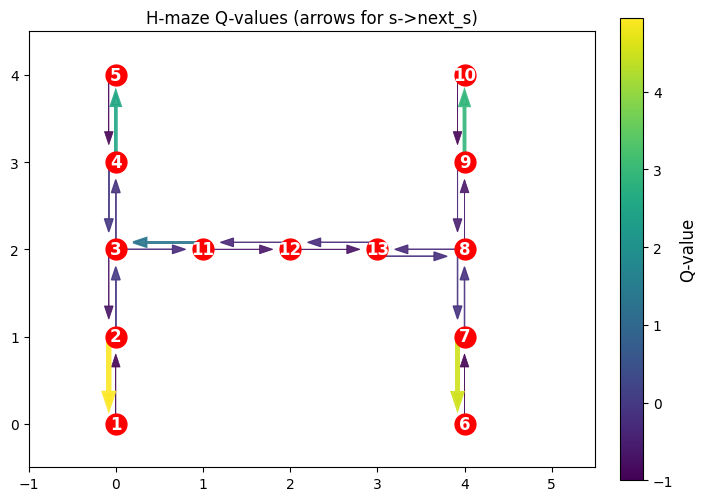


Overall Match Rate = 50.71%
Match Rate (2-choice states) = 56.99%
Match Rate (3-choice states) = 33.88%

Running model recovery test (SARSA(0))...


ValueError: 'x' and 'y' must have the same size

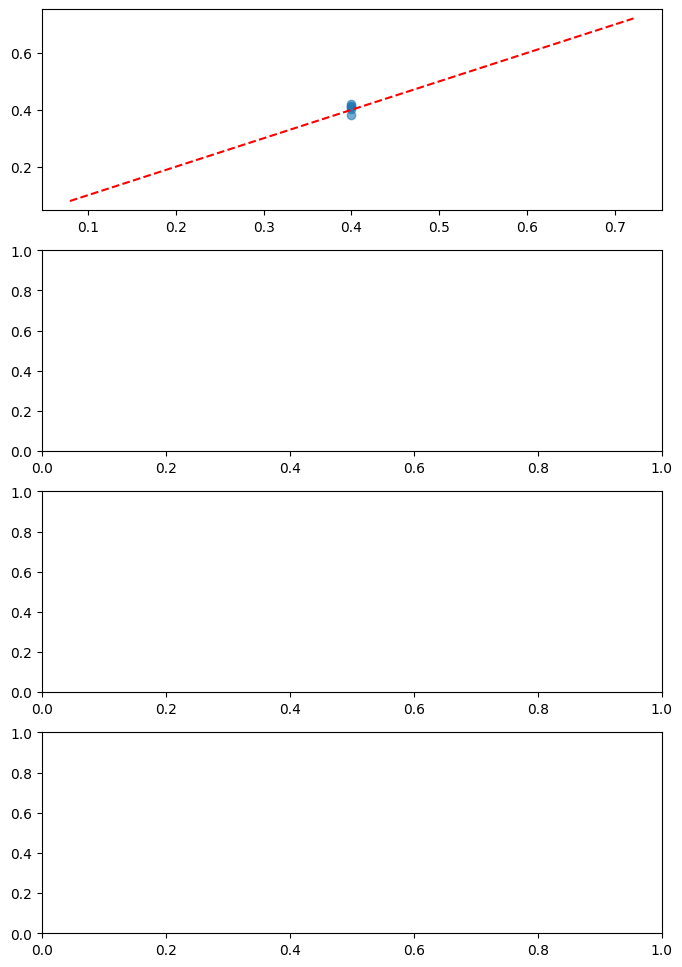

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

# ------------------------------------------------
# H-Maze Environment Definition
# ------------------------------------------------
class HMazeEnvironment:

    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self._build_transitions()
        self.legal_next_states = self._build_legal_next_states()
        self._validate_transitions()

    def _build_transitions(self):
        """
        Define transition rules in a dictionary. 
        For each state, we have hypothetical transitions indexed by 0..3, 
        but we only really use legal_next_states for the actual actions
        """
        return {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11, 2: 3,   3: 12},
            12: {0: 12, 1: 12, 2: 11,  3: 13},
            13: {0: 13, 1: 13, 2: 12,  3: 8}
        }

    def _build_legal_next_states(self):
        legal_dict = {}
        for s in self.states:
            possible_next = set(self.transitions[s].values())
            if s in possible_next:
                possible_next.remove(s)
            legal_dict[s] = sorted(list(possible_next))
        return legal_dict

    def _validate_transitions(self):
        for s, transitions in self.transitions.items():
            assert all(nx in self.states for nx in transitions.values()), f"Invalid transition from {s}"

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state

# ------------------------------------------------
# Core RL Components
# ------------------------------------------------
def initialize_Q_dict(env, init_value=0.0, noise=0.0):
    """
    Initialize the Q dictionary: Q[s][a].
    init_value: base Q value
    noise: optional random noise added to each Q 
    """
    Q = {}
    for s in env.states:
        Q[s] = {
            nx: init_value + np.random.uniform(-noise, noise) 
            for nx in env.legal_next_states[s]
        }
    return Q

def softmax(q_values, beta):
    max_q = np.max(q_values)
    exp_values = np.exp(beta * (q_values - max_q))
    return exp_values / (np.sum(exp_values) + 1e-12)

# ------------------------------------------------
# Data Preparation and Model Training
# ------------------------------------------------
def prepare_training_data(data_path):
    """
    Read all *.beh.txt files in the given directory, merge them, and apply basic filtering:
    - Keep only rows where Choice != -1
    - Keep only rows where Control == 0
    """
    dfs = []
    for fn in [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]:
        full_fp = os.path.join(data_path, fn)
        df = pd.read_csv(full_fp, delimiter=',')
        # Extract session info from filename
        df['session_date'] = "_".join(fn.split('_')[1:4]) if '_' in fn else 'unknown'
        dfs.append(df)
    
    if len(dfs) == 0:
        print("No .beh.txt files found in the specified directory.")
        return []
    
    full_df = pd.concat(dfs).sort_values(
        ['session_date', 'TotalEpisodeNum', 'TrialNum']
    ).reset_index(drop=True)
    
    # Basic cleaning
    processed_df = full_df[
        (full_df['Choice'] != -1) &
        (full_df['Control'] == 0)
    ].copy()

    return processed_df.to_dict('records')

def compute_log_likelihood(params, data, env, reset_episodes=False):
    alpha, gamma, log_beta, forget = params
    beta = np.clip(np.exp(log_beta), 1e-3, 1e3)
    
    Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
    current_episode = None
    neg_log_lik = 0.0
    
    for idx in range(len(data)):
        tr = data[idx]
        st = tr['CurrentState']
        cho = tr['ChosenState']
        gst = tr['Goal']
        
        # Episode boundary handling
        if reset_episodes and (tr['TotalEpisodeNum'] != current_episode):
            Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
            current_episode = tr['TotalEpisodeNum']
        
        # If the chosen action is not in the legal actions, skip
        legal_actions = list(Q[st].keys())
        if cho not in legal_actions:
            continue
        
        # Compute choice probability
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        action_index = legal_actions.index(cho)
        action_prob = probs[action_index]
        
        neg_log_lik -= np.log(action_prob + 1e-12)
        
        # Compute reward
        next_st = env.get_next_state(st, cho)
        reward = 5 if (next_st == gst) else -1
        
        # TD target (SARSA(0))
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == tr['TotalEpisodeNum']:
            next_q = Q[next_st].get(data[idx+1]['ChosenState'], 0.0)
            td_target = reward + gamma * next_q
        else:
            td_target = reward
        
        # SARSA(0) update
        Q[st][cho] += alpha * (td_target - Q[st][cho])
        
        # 'forget' factor for unchosen actions in the same state
        for a in Q[st]:
            if a != cho:
                Q[st][a] *= forget
                
    return neg_log_lik

# ------------------------------------------------
# Parameter Optimization (Multi-Restart)
# ------------------------------------------------
def optimize_parameters(data, env, n_restarts=3, reset_episodes=False):
    best_result = None
    all_results = []
    
    for run in range(n_restarts):
        # Random initial parameters
        init_params = [
            np.random.uniform(0.1, 0.5),         # alpha
            np.random.uniform(0.5, 1.0),         # gamma
            np.log(np.random.uniform(1, 4)),     # log_beta
            np.random.uniform(0.85, 0.99)        # forget
        ]
        
        initial_loss = compute_log_likelihood(init_params, data, env, reset_episodes)
        
        run_history = {
            'params': [],
            'loss': [],
            'run_id': run
        }
        
        def callback(xk):
            run_history['params'].append(xk.copy())
            current_loss = compute_log_likelihood(xk, data, env, reset_episodes)
            run_history['loss'].append(current_loss)
        
        result = minimize(
            lambda p: compute_log_likelihood(p, data, env, reset_episodes),
            init_params,
            method='L-BFGS-B',
            bounds=[
                (0.001, 0.999),               # alpha
                (0.001, 0.999),               # gamma
                (np.log(0.1), np.log(10)),    # log_beta
                (0.001, 0.999)                # forget
            ],
            callback=callback,
            options={'maxiter': 200, 'disp': False}
        )
        
        final_entry = {
            'initial_params': init_params,
            'initial_loss': initial_loss,
            'final_params': result.x,
            'final_loss': result.fun,
            'history': run_history
        }
        all_results.append(final_entry)
        
        if (best_result is None) or (result.fun < best_result['final_loss']):
            best_result = final_entry
    
    return best_result, all_results

def plot_optimization_history(best_result):
    init_point = best_result['initial_params']
    history = best_result['history']
    params = np.array(history['params'])
    losses = history['loss']
    init_loss = best_result['initial_loss']
    
    if len(params) == 0:
        params = np.array([init_point])
        losses = [init_loss]
    
    alpha_hist = np.insert(params[:, 0], 0, init_point[0])
    gamma_hist = np.insert(params[:, 1], 0, init_point[1])
    beta_hist = np.insert(np.exp(params[:, 2]), 0, np.exp(init_point[2]))
    forget_hist = np.insert(params[:, 3], 0, init_point[3])
    losses = np.insert(losses, 0, init_loss)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(alpha_hist, label='Alpha', lw=2)
    plt.plot(gamma_hist, label='Gamma', lw=2)
    plt.plot(beta_hist, label='Beta', lw=2)
    plt.plot(forget_hist, label='Forget', lw=2)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.title('Parameter Evolution')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(losses, color='darkred', lw=2)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.title('Likelihood Evolution')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# Behavior Simulation (SARSA(0))
# ------------------------------------------------
def simulate_behavior(env, data, alpha, gamma, beta, forget, seed=None, reset_episodes=False):
    if seed is not None:
        np.random.seed(seed)
    
    Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
    sim_actions = []
    current_episode = None
    
    for idx, tr in enumerate(data):
        st = tr['CurrentState']
        gst = tr['Goal']
        
        # Reset Q if we start a new episode
        if reset_episodes and tr['TotalEpisodeNum'] != current_episode:
            Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
            current_episode = tr['TotalEpisodeNum']
        
        legal_actions = list(Q[st].keys())
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        action = np.random.choice(legal_actions, p=probs)
        sim_actions.append(action)
        
        # Compute reward
        next_st = env.get_next_state(st, action)
        reward = 5 if (next_st == gst) else -1
        
        # TD target
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == tr['TotalEpisodeNum']:
            next_q = Q[next_st].get(data[idx+1]['ChosenState'], 0.0)
            td_target = reward + gamma * next_q
        else:
            td_target = reward
        
        # SARSA(0) update
        Q[st][action] += alpha * (td_target - Q[st][action])
        
        # Forget factor for unchosen actions
        for a in Q[st]:
            if a != action:
                Q[st][a] *= forget
                
    return sim_actions, Q

# ------------------------------------------------
# Model Validation (Match Rate) + Q Visualization
# ------------------------------------------------
def validate_model(env, real_data, params, reset_episodes=False):
    """
    Validate a model by simulating behavior with given params 
    and comparing with real choices (match rate). Also plot the final Q-values.
    """
    alpha, gamma, log_beta, forget = params
    beta = np.exp(log_beta)
    
    sim_actions, Q = simulate_behavior(env, real_data, alpha, gamma, beta, forget, seed=42, reset_episodes=reset_episodes)
    real_actions = [d['ChosenState'] for d in real_data]
    
    # Overall match rate
    match_rate = np.mean([r == s for r, s in zip(real_actions, sim_actions)])
    
    # Separate match rate for states with 2 vs. 3 legal actions
    num_2_match = 0
    num_2_total = 0
    num_3_match = 0
    num_3_total = 0

    for rd, model_act in zip(real_data, sim_actions):
        st = rd['CurrentState']
        real_act = rd['ChosenState']
        choice_count = len(env.legal_next_states[st])

        if choice_count == 2:
            num_2_total += 1
            if real_act == model_act:
                num_2_match += 1
        elif choice_count == 3:
            num_3_total += 1
            if real_act == model_act:
                num_3_match += 1
    
    match_2_ratio = num_2_match / num_2_total if num_2_total > 0 else 0
    match_3_ratio = num_3_match / num_3_total if num_3_total > 0 else 0
    
    # Plot final Q-values
    plot_q_values(Q, env)
    
    return match_rate, Q, match_2_ratio, match_3_ratio

def plot_q_values(Q, env):
    """
    Plot H-maze Q-values as arrows from each state to possible next states.
    The arrow width and color indicate the magnitude of Q.
    """
    coords = {
        1:(0,0),  2:(0,1),  3:(0,2),  4:(0,3),  5:(0,4),
        6:(4,0),  7:(4,1),  8:(4,2),  9:(4,3), 10:(4,4),
        11:(1,2), 12:(2,2), 13:(3,2)
    }

    plt.figure(figsize=(8,6))
    plt.title("H-maze Q-values (arrows for s->next_s)")

    all_q_vals = [Q[s][nx] for s in Q for nx in Q[s]]
    if len(all_q_vals) == 0:
        print("No Q values to plot!")
        return
    
    Q_min, Q_max = min(all_q_vals), max(all_q_vals)
    if Q_min == Q_max:
        Q_min -= 0.01
        Q_max += 0.01
    eps = 1e-12

    cmap = plt.cm.viridis
    norm = mpl.colors.Normalize(vmin=Q_min, vmax=Q_max)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  

    # Plot states
    for s in env.states:
        if s in coords:
            sx, sy = coords[s]
            plt.plot(sx, sy, 'ro', markersize=15, zorder=3)
            plt.text(sx, sy, f"{s}", ha='center', va='center',
                     fontsize=12, color="white", fontweight='bold', zorder=4)

    # Plot arrows for Q-values
    drawn_edges = set()
    offset_factor = 0.08
    for s in env.states:
        if s not in coords or s not in Q:
            continue
        sx, sy = coords[s]
        for nx, q_val in Q[s].items():
            if nx not in coords:
                continue
            nx_x, nx_y = coords[nx]
            dx = nx_x - sx
            dy = nx_y - sy

            norm_val = (q_val - Q_min) / (Q_max - Q_min + eps)
            lw = 0.5 + 3.0 * norm_val
            color = cmap(norm_val)

            edge_key_1 = f"{s}->{nx}"
            edge_key_2 = f"{nx}->{s}"
            
            # If reverse arrow was already drawn, shift this arrow slightly
            if edge_key_2 in drawn_edges:
                perp_x =  dy
                perp_y = -dx
                norm_len = np.sqrt(perp_x**2 + perp_y**2) + eps
                perp_x /= norm_len
                perp_y /= norm_len
                perp_x *= offset_factor
                perp_y *= offset_factor

                sx_off = sx + perp_x
                sy_off = sy + perp_y
                plt.arrow(
                    sx_off, sy_off, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            else:
                plt.arrow(
                    sx, sy, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            drawn_edges.add(edge_key_1)

    plt.gca().set_aspect('equal', 'box')
    plt.xlim(-1, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.grid(False)

    cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label("Q-value", fontsize=12)

    plt.show()

# ------------------------------------------------
# Model Recovery
# ------------------------------------------------
def parameter_recovery_test(env, data, alpha, gamma, beta, forget, n_simulations=5, reset_episodes=False):
    """
    Model recovery test for SARSA(0):
      1) Generate simulated data from the "true" parameters 
      2) Fit the model to the simulated data
      3) Compare the estimated parameters to the true parameters.
    """
    true_params = {'alpha': alpha, 'gamma': gamma, 'beta': beta, 'forget': forget}
    recovery_results = []
    
    for sim_idx in range(n_simulations):
        # 1. Simulate behavior with the true parameters
        sim_actions, _ = simulate_behavior(
            env, data, alpha, gamma, beta, forget, 
            seed=sim_idx, reset_episodes=reset_episodes
        )
        # 2. Replace the real ChosenState with the simulated action
        sim_data = []
        for i, d in enumerate(data):
            new_record = d.copy()
            new_record['ChosenState'] = sim_actions[i]
            sim_data.append(new_record)
        
        # 3. Fit the model to the simulated data
        best_result, _ = optimize_parameters(sim_data, env, n_restarts=2, reset_episodes=reset_episodes)
        est = best_result['final_params']
        est_alpha, est_gamma, est_logbeta, est_forget = est
        est_params = {
            'alpha': est_alpha,
            'gamma': est_gamma,
            'beta': np.exp(est_logbeta),
            'forget': est_forget
        }
        
        # 4. Store the comparison
        recovery_results.append({'true': true_params, 'estimated': est_params})
    
    plot_parameter_recovery(recovery_results)
    return recovery_results

def plot_parameter_recovery(results):
    params = ['alpha', 'gamma', 'beta', 'forget']
    
    fig, axes = plt.subplots(len(params), 1, figsize=(8, 3*len(params)))
    if len(params) == 1:
        axes = [axes]
    
    for i, param in enumerate(params):
        ax = axes[i]
        true_vals = [r['true'][param] for r in results]
        est_vals = [r['estimated'][param] for r in results]
        ax.scatter(true_vals, est_vals, alpha=0.6)
        
        min_val = min(true_vals + est_vals)
        max_val = max(true_vals + est_vals)
        padding = (max_val - min_val) * 0.05
        min_val -= padding
        max_val += padding
        
        ax.plot([min_val+-0.3, max_val+0.3], [min_val-0.3, max_val+0.3], 'r--')
        ax.errorbar(true_vals, np.mean(est_vals), yerr=np.std(est_vals), fmt='o', color='blue', alpha=0.4)
        ax.set_xlabel('True ' + param)
        ax.set_ylabel('Estimated ' + param)
        ax.set_title(f'Parameter Recovery: {param}')
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# main 
# ------------------------------------------------
if __name__ == "__main__":
    env = HMazeEnvironment()
    
    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    training_data = prepare_training_data(data_path)
    if not training_data:
        print("No valid data to train. Exiting.")
        exit()

    best_result, all_results = optimize_parameters(training_data, env, n_restarts=5, reset_episodes=False)
    final_params = best_result['final_params']
    alpha_hat, gamma_hat, log_beta_hat, forget_hat = final_params
    
    print("\n=== Best Fitting Parameters ===")
    print(f"Alpha   = {alpha_hat:.4f}")
    print(f"Gamma   = {gamma_hat:.4f}")
    print(f"Beta    = {np.exp(log_beta_hat):.4f}")
    print(f"Forget  = {forget_hat:.4f}")
    print(f"Neg Log-Likelihood = {best_result['final_loss']:.2f}")
    
    plot_optimization_history(best_result)
    
    match_rate, final_Q, match2, match3 = validate_model(env, training_data, final_params, reset_episodes=False)
    print(f"\nOverall Match Rate = {match_rate:.2%}")
    print(f"Match Rate (2-choice states) = {match2:.2%}")
    print(f"Match Rate (3-choice states) = {match3:.2%}")
    
    print("\nRunning model recovery test (SARSA(0))...")
    #recovery_results = parameter_recovery_test(
    #    env, training_data, 
    #    alpha=alpha_hat, gamma=gamma_hat, 
    #    beta=np.exp(log_beta_hat), forget=forget_hat, 
    #    n_simulations=5, reset_episodes=False
    #)
    recovery_results = parameter_recovery_test(
        env, training_data, 
        alpha=0.4, gamma=0.5, 
        beta=1.0, forget=0.9, 
        n_simulations=5, reset_episodes=False
    )
    print("\nLast simulation's true vs. estimated parameters:")
    print(recovery_results[-1])




In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import seaborn as sns
from scipy.optimize import minimize
import glob, os

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import norm
from scipy import signal
from matplotlib import gridspec
import matplotlib 
from os import listdir
from os.path import isfile, join
import statsmodels.api as sm
from scipy.stats import fisher_exact,chi2_contingency
from scipy.signal import savgol_filter
import csv
from tkinter import Tcl
from scipy.stats import entropy


########################
#  functions
########################

def softmax_policy(Q, beta=3):
    if len(Q) == 1:
        prob = np.array([1.0])
        choice = 0
    else:
        exp_Q_beta = np.exp(beta * np.array(Q))
        prob = exp_Q_beta / np.sum(exp_Q_beta)
        choice = np.random.choice(len(Q), p=prob)
        
    return choice, prob

def entropy(probs):
    probs = np.array(probs)
    return -np.sum(probs * np.log(probs + 1e-12))

########################
#  T matrix (13 * 13)
########################
T = np.zeros((13,13))
# A1-A5 (index:0~4)
T[0:5,0:5] = np.eye(5,k=1)+np.eye(5,k=-1)  
# B1-B5 (index:5~9)
T[5:10,5:10] = np.eye(5,k=1)+np.eye(5,k=-1)
# C (index:10~12)
T[10:,10:] = np.eye(3,k=1)+np.eye(3,k=-1)
# A3 <-> CA (index 2 <-> 10)
T[2,10] = 1
T[10,2] = 1
# B4 <-> CB (index 7 <-> 12)
T[7,12] = 1
T[12,7] = 1

########################
#  TD(0) likelihood
########################
def TD0_fit(params, ses, T):
    gamma = params[0]
    alpha = params[1]
    beta  = params[2] * 10
    forget= params[3]
    
    Q = np.zeros(len(T)) 
    
    minusLL = 0
    chosen_prob = np.zeros(len(ses))
    correct_prob= np.zeros(len(ses))
    maxQ       = np.zeros(len(ses))
    prob_entropy = np.zeros(len(ses))
    n_trial = 0
    
    for ses_num in ses.SessionNum.unique():
        ses_perf = ses[ses.SessionNum == ses_num]
        
        for episode_num in ses_perf.TotalEpisodeNum.unique():
            episode_perf = ses_perf[ses_perf.TotalEpisodeNum == episode_num]
            goal = int(episode_perf.Goal.values[0]) - 1
            # set goal Q value fixed at 5 !
            Q[goal] = 5

            for t in range(len(episode_perf)):
                current_state = episode_perf.CurrentState.values[t] - 1
                successors = np.where(T[int(current_state),:] == 1)[0]  
                
                # softmax
                choice_ind, choice_prob = softmax_policy(Q[successors], beta=beta)
                
                next_state = episode_perf.ChosenState.values[t] - 1
                correct_state = int(episode_perf.CorrectState.values[t]) - 1
                
                chosen_idx_in_succ = np.where(successors==next_state)[0]
                correct_idx_in_succ= np.where(successors==correct_state)[0]
                
                if len(chosen_idx_in_succ) > 0:
                    chosen_prob[n_trial] = choice_prob[chosen_idx_in_succ[0]]
                else:
                    chosen_prob[n_trial] = 0  
                
                if len(correct_idx_in_succ)>0:
                    correct_prob[n_trial] = choice_prob[correct_idx_in_succ[0]]
                else:
                    correct_prob[n_trial] = 0
                
                maxQ[n_trial] = np.max(Q[successors])
                prob_entropy[n_trial] = entropy(choice_prob)
                
                p_chosen = max(chosen_prob[n_trial], 0.0001)
                minusLL -= np.log(p_chosen)
                
                n_trial += 1
                
                # TD(0) update
                # in state, reward=-1, goal Q == 5
                # also reward = 5 if next_state == goal else -1
                delta = -1 + gamma * Q[next_state] - Q[current_state]
                Q[current_state] += alpha * delta
                
                Q[np.arange(13)!=current_state] *= forget
                Q[goal] = 5

    valid_count = len(ses[ses.NumTargets > 1])
    if valid_count < 1:
        return minusLL
    return minusLL / valid_count

########################
#  simulate
########################
def TD0_simulate(params, ses, T):
    sim_df = ses.copy().reset_index(drop=True)
    
    gamma = params[0]
    alpha = params[1]
    beta  = params[2]*10
    forget= params[3]
    
    Q = np.zeros(len(T))

    for ses_num in sim_df.SessionNum.unique():
        ses_perf_indices = sim_df[sim_df.SessionNum == ses_num].index
        ses_perf = sim_df.loc[ses_perf_indices]
        
        for episode_num in ses_perf.TotalEpisodeNum.unique():
            episode_indices = ses_perf[ses_perf.TotalEpisodeNum == episode_num].index
            episode_perf = sim_df.loc[episode_indices]
            
            goal = int(episode_perf.Goal.values[0]) - 1
            Q[:] = 0
            Q[goal] = 5

            for t in episode_indices:
                current_state = sim_df.loc[t, 'CurrentState'] - 1
                successors = np.where(T[int(current_state),:] == 1)[0]
                
                choice_ind, choice_prob = softmax_policy(Q[successors], beta=beta)
                next_state = successors[choice_ind]
                
                sim_df.loc[t, 'ChosenState'] = next_state + 1  # +1，保持与原数据的1~13编码一致

                # TD(0) update
                delta = -1 + gamma * Q[next_state] - Q[current_state]
                Q[current_state] += alpha * delta
                Q[np.arange(13)!=current_state] *= forget
                Q[goal] = 5
    
    return sim_df

########################
#  single session
########################
def fit_TD0_for_session(ses, T):
    bnds = ((0,1),(0,1),(0,1),(0,1))
    init_guess = (0.5, 0.5, 0.5, 0.9)
    
    res = minimize(lambda x: TD0_fit(x, ses, T), init_guess, bounds=bnds)
    return res.x, TD0_fit(res.x, ses, T)

########################
#  model recovery
########################
def parameter_recovery_test(ses, T, true_params, n_sims=5):
    results = []
    for i in range(n_sims):
        sim_df = TD0_simulate(true_params, ses, T)
        est_params, est_ll = fit_TD0_for_session(sim_df, T)
        
        out = {
            'true': {
                'gamma':  true_params[0],
                'alpha':  true_params[1],
                'beta':   true_params[2]*10,  
                'forget': true_params[3]
            },
            'estimated': {
                'gamma':  est_params[0],
                'alpha':  est_params[1],
                'beta':   est_params[2]*10,
                'forget': est_params[3]
            },
            'minusLL': est_ll
        }
        results.append(out)
    return results

########################
#  main
########################
if __name__ == "__main__":
    def combine_beh_eye(mypath,f):

        behfile=f
        eyefile=f[:-7]+'eye.txt'

        beh = pd.read_csv(join(mypath,behfile), sep=",")

        with open(join(mypath,eyefile), 'r') as file:

            csv_reader = csv.reader(file)

            combined_rows = [np.array([]) for x in range(3)]
            current_row = []

            for row_num, row in enumerate(csv_reader):
                combined_rows[row_num % 3] =  np.concatenate((combined_rows[row_num % 3], np.array(row,dtype=np.intp)))

        eyeData = pd.DataFrame(np.array(combined_rows).transpose(),columns=['Time','xpos','ypos'])


        # 1: bottom (goal)
        # 2: center
        # 3: left
        # 4: top
        # 5: right
        eyeData['Target'] = (((eyeData.xpos.values-400)**2 + (eyeData.ypos.values-550)**2) < 65**2)*1+ \
                        (((eyeData.xpos.values-400)**2 + (eyeData.ypos.values-300)**2) < 65**2)*2+ \
                        (((eyeData.xpos.values-200)**2 + (eyeData.ypos.values-300)**2) < 65**2)*3+ \
                        (((eyeData.xpos.values-400)**2 + (eyeData.ypos.values-100)**2) < 65**2)*4+ \
                        (((eyeData.xpos.values-600)**2 + (eyeData.ypos.values-300)**2) < 65**2)*5  

        ind = eyeData.Target.diff()!=0
        changefixation = eyeData.loc[ind,:]
        ind = changefixation.Target.values>0
        ind[-1]=False

        targetfixation=pd.DataFrame()
        targetfixation['Location'] = changefixation.Target.values[ind]
        targetfixation['Start'] = changefixation.Time.values[ind]
        targetfixation['End'] = changefixation.Time.values[1:][ind[:-1]]
        targetfixation['Duration(ms)']=targetfixation['End']-targetfixation['Start']
        targetfixation = targetfixation[targetfixation['Duration(ms)']>50]

        choicefixation=targetfixation[targetfixation.Location>2].reset_index(drop=True)

        Saccades = np.zeros(len(beh))
        Fix_start_time=choicefixation.Start.values
        DEntry = beh.DelayperiodEntry.values + np.floor(beh.GlobalStart.values[0]*1000)
        FB = beh.FeedbackPeriodEntry.values + np.floor(beh.GlobalStart.values[0]*1000)
        Last = np.zeros(len(beh))
        PeriTime = np.zeros(len(beh))
    
        for trial in range(len(beh)):

            peri = np.logical_and(Fix_start_time>DEntry[trial],Fix_start_time<FB[trial])
            Saccades[trial] = np.sum(peri)
            chosenlocation = int(beh.iloc[trial]['ChosenLocation']/200+2)
            ind = choicefixation[peri].Location!=chosenlocation
            PeriTime[trial] = np.sum(choicefixation[peri]['Duration(ms)'].values[ind])        
            # if np.sum(peri)>0:
            #     Last[trial] = Fix_start_time[peri][-1]
            

        beh['Saccades']=Saccades
        # beh['RT']=Last-DEntry
        beh['PeriTime']=PeriTime

        return beh

    #mypath='/Users/lianghexin/Documents/Thesis/MazeTask/D/HMaze/Behavior'
    mypath = "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    os.chdir(mypath)
    beh = pd.DataFrame()
    
    for ii,f in enumerate(Tcl().call('lsort', '-dict', glob.glob("*.beh.txt"))):
    
        print(ii,f)
        beh_temp = combine_beh_eye(mypath,f)
        beh_temp.reset_index(drop=True, inplace=True)
        beh_temp.insert(loc = 0,
          column = 'SessionNum',
          value = ii)
    
        if len(beh_temp[beh_temp.Control==0])>300:
            beh = pd.concat([beh,beh_temp])
    
    ind = (beh.Control==1) & (beh.FeedbackPeriodEntry>0)
    beh.loc[ind,'Choice']=1 
    beh['MazeCode']=0
    beh.loc[(beh.CurrentState<11)&(beh.CurrentState%5<2),'MazeCode']=1
    beh.loc[(beh.CurrentState<11) & ((beh.CurrentState%5==2) | (beh.CurrentState%5==4)),'MazeCode']=2
    beh.loc[(beh.CurrentState<11) & (beh.CurrentState%5==3),'MazeCode']=3
    beh.loc[(beh.CurrentState==11) | (beh.CurrentState==13),'MazeCode']=4
    beh.loc[beh.CurrentState==12,'MazeCode']=5

    beh['NumTargets']=2
    beh.loc[(beh["CurrentState"]==1) | (beh["CurrentState"]==5) | (beh["CurrentState"]==6) | (beh["CurrentState"]==10), 
        "NumTargets"] = 1
    beh.loc[(beh["CurrentState"]==3) | (beh["CurrentState"]==8), "NumTargets"] = 3

    #os.chdir('/Users/lianghexin/Documents/GitHub/MazeTaskAnalysis')

    beh=beh[(beh.Control==0)&(beh.Choice>-1)]

    beh_sim = pd.DataFrame()
    num_sessions = len(beh.SessionNum.unique())
    
    TD_matrix = np.zeros((num_sessions,4))
    TD_LL     = np.zeros(num_sessions)
    
    for ii, ss in enumerate(beh.SessionNum.unique()):
        print(f"Fitting SessionNum={ss}")
        ses = beh[beh.SessionNum == ss].copy()
        
        best_params, best_minusLL = fit_TD0_for_session(ses, T)

        TD_matrix[ii,:] = best_params
        TD_LL[ii] = best_minusLL

        print("TD0 best params:", best_params)
        print("TD0 best -LL:", best_minusLL)
        
        beh_sim = pd.concat([beh_sim, ses], ignore_index=True)

    test_sess_id = beh.SessionNum.unique()[0]
    test_ses = beh[beh.SessionNum == test_sess_id].copy()

    best_params_all = np.mean(TD_matrix, axis=0)
    
    true_params = best_params_all
    recov_results = parameter_recovery_test(test_ses, T, true_params, n_sims=3)
    
    print("\n=== Model Recovery (SessionNum={}, n_sims=3) ===".format(test_sess_id))
    for idx, rr in enumerate(recov_results):
        print(f"Simulation {idx}:")
        print("  True:", rr['true'])
        print("  Est:", rr['estimated'])
        print("  -LL:", rr['minusLL'])


0 HMaze_2024_07_08__13_55_17.beh.txt
1 HMaze_2024_07_09__14_23_22.beh.txt
2 HMaze_2024_07_10__16_56_16.beh.txt
3 HMaze_2024_07_11__15_21_25.beh.txt
4 HMaze_2024_07_12__15_09_34.beh.txt
5 HMaze_2024_07_15__15_13_04.beh.txt
6 HMaze_2024_07_16__14_57_33.beh.txt
7 HMaze_2024_07_17__15_04_10.beh.txt
8 HMaze_2024_07_18__15_03_53.beh.txt
9 HMaze_2024_07_19__16_12_00.beh.txt
10 HMaze_2024_07_22__14_46_48.beh.txt
11 HMaze_2024_07_23__13_08_34.beh.txt
12 HMaze_2024_07_24__14_40_53.beh.txt
13 HMaze_2024_07_25__15_33_29.beh.txt
14 HMaze_2024_07_26__15_21_40.beh.txt
15 HMaze_2024_07_29__12_54_54.beh.txt
16 HMaze_2024_07_30__15_32_41.beh.txt
17 HMaze_2024_07_31__16_24_01.beh.txt
18 HMaze_2024_08_01__14_18_59.beh.txt
19 HMaze_2024_08_02__17_01_03.beh.txt
20 HMaze_2024_08_05__14_15_24.beh.txt
21 HMaze_2024_08_06__13_57_51.beh.txt
22 HMaze_2024_08_09__13_46_25.beh.txt
Fitting SessionNum=1
  TD0 best params: [0.15700126 0.14868233 1.         0.        ]
  TD0 best -LL: 0.6161672136338705
Fitting Session

## Sarsa(lambda) Version

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83858D+04    |proj g|=  2.99917D+00

At iterate    1    f=  1.11089D+04    |proj g|=  3.31074D+00

At iterate    2    f=  1.09538D+04    |proj g|=  4.60517D+00

At iterate    3    f=  1.08970D+04    |proj g|=  4.55746D+00

At iterate    4    f=  1.06350D+04    |proj g|=  4.13534D+00

At iterate    5    f=  1.02964D+04    |proj g|=  3.26105D+00

At iterate    6    f=  1.02750D+04    |proj g|=  1.51383D+00

At iterate    7    f=  1.02425D+04    |proj g|=  1.52476D+00

At iterate    8    f=  1.02239D+04    |proj g|=  1.44611D+00

At iterate    9    f=  1.02188D+04    |proj g|=  3.23688D+00

At iterate   10    f=  1.02155D+04    |proj g|=  1.54832D+00

At iterate   11    f=  1.02149D+04    |proj g|=  1.43244D+00

At iterate   12    f=  1.02148D+04    |proj g|=  1.43071D+00

At iterate   13    f=  1.0

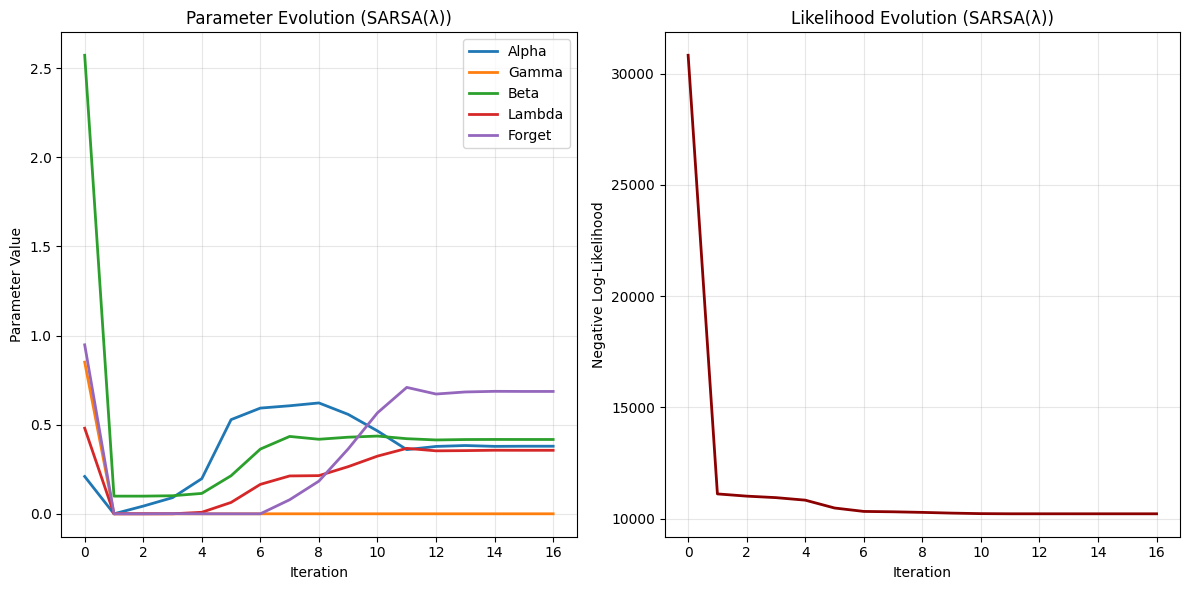

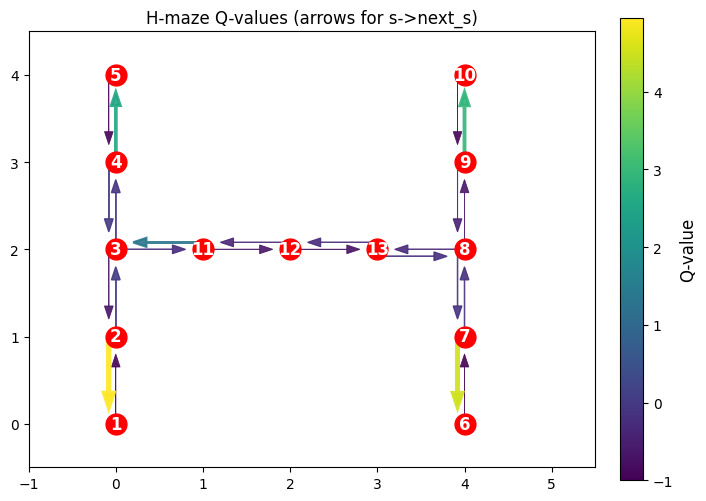


Overall Match Rate = 50.71%
Match Rate (2-choice states) = 56.99%
Match Rate (3-choice states) = 33.88%

Running model recovery test (SARSA(λ))...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02361D+04    |proj g|=  3.43036D+00

At iterate    1    f=  9.47949D+03    |proj g|=  2.24446D+00

At iterate    2    f=  9.30369D+03    |proj g|=  2.41220D+00

At iterate    3    f=  9.14068D+03    |proj g|=  2.50436D+00

At iterate    4    f=  9.09757D+03    |proj g|=  2.37839D+00

At iterate    5    f=  9.07366D+03    |proj g|=  2.32806D+00

At iterate    6    f=  9.06238D+03    |proj g|=  2.32329D+00

At iterate    7    f=  9.06059D+03    |proj g|=  2.32449D+00

At iterate    8    f=  9.05897D+03    |proj g|=  2.32010D+00

At iterate    9    f=  9.05727D+03    |proj g|=  2.29554D+00

At iterate   10    f=  9.05650D+03    |proj g|=  2.28613D+00

At

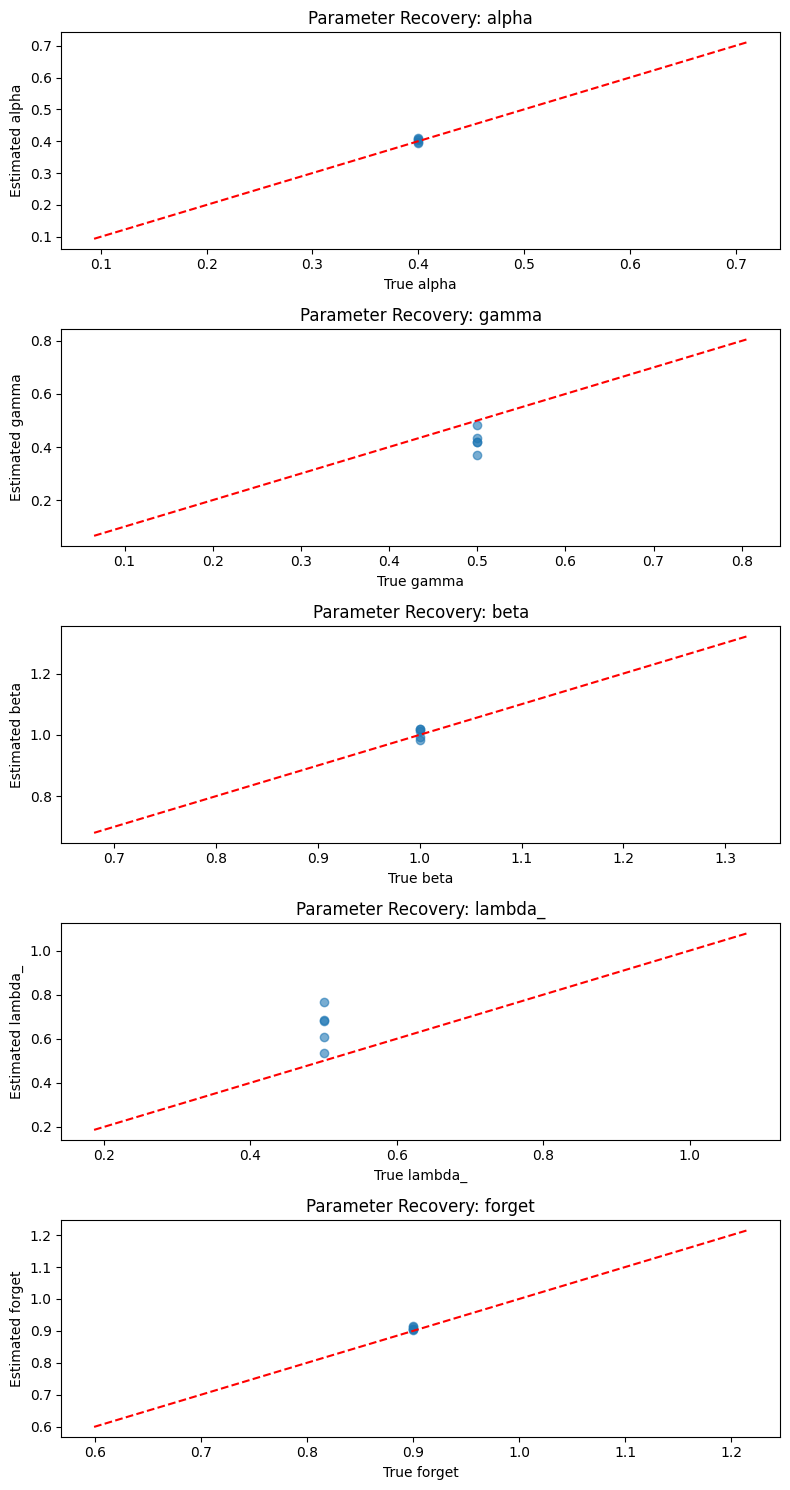


Last simulation's true vs. estimated parameters:
{'true': {'alpha': 0.4, 'gamma': 0.5, 'beta': 1.0, 'lambda_': 0.5, 'forget': 0.9}, 'estimated': {'alpha': 0.39433877413787227, 'gamma': 0.420169407888517, 'beta': 0.9823709075985191, 'lambda_': 0.6854632595790875, 'forget': 0.9121829056093007}}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

# ------------------------------------------------
# H-Maze Environment Definition
# ------------------------------------------------
class HMazeEnvironment:
    """H-maze environment with states 1..13. 
    Next-state selection is considered the 'action'."""
    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self._build_transitions()
        self.legal_next_states = self._build_legal_next_states()
        self._validate_transitions()

    def _build_transitions(self):
        return {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11,  2: 3,  3: 12},
            12: {0: 12, 1: 12,  2: 11, 3: 13},
            13: {0: 13, 1: 13,  2: 12, 3: 8}
        }

    def _build_legal_next_states(self):
        legal_dict = {}
        for s in np.arange(1, 14):
            possible_next = set(self.transitions[s].values())
            if s in possible_next:
                possible_next.remove(s)
            legal_dict[s] = sorted(list(possible_next))
        return legal_dict

    def _validate_transitions(self):
        for s, transitions in self.transitions.items():
            assert all(nx in self.states for nx in transitions.values()), f"Invalid transition from {s}"

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state

# ------------------------------------------------
# Core RL Components
# ------------------------------------------------
def initialize_Q_dict(env, init_value=0.0, noise=0.0):
    Q = {}
    for s in env.states:
        Q[s] = {
            nx: init_value + np.random.uniform(-noise, noise) 
            for nx in env.legal_next_states[s]
        }
    return Q

def initialize_E_dict(env):
    """Initialize an eligibility trace dictionary E[s][a] = 0."""
    E = {}
    for s in env.states:
        E[s] = {a: 0.0 for a in env.legal_next_states[s]}
    return E

def softmax(q_values, beta):
    max_q = np.max(q_values)
    exp_values = np.exp(beta * (q_values - max_q))
    return exp_values / (np.sum(exp_values) + 1e-12)

# ------------------------------------------------
# Data Preparation
# ------------------------------------------------
def prepare_training_data(data_path):
    dfs = []
    for fn in [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]:
        full_fp = os.path.join(data_path, fn)
        df = pd.read_csv(full_fp, delimiter=',')
        df['session_date'] = "_".join(fn.split('_')[1:4]) if '_' in fn else 'unknown'
        dfs.append(df)
    
    if len(dfs) == 0:
        print("No .beh.txt files found.")
        return []
    
    full_df = pd.concat(dfs).sort_values(
        ['session_date', 'TotalEpisodeNum', 'TrialNum']
    ).reset_index(drop=True)
    
    processed_df = full_df[
        (full_df['Choice'] != -1) &
        (full_df['Control'] == 0)
    ].copy()

    return processed_df.to_dict('records')

# ------------------------------------------------
# Log-likelihood under SARSA(λ)
# ------------------------------------------------
def compute_log_likelihood_sarsa_lambda(params, data, env, reset_episodes=False):
    """
    Compute negative log-likelihood for SARSA(λ).
    
    params = [alpha, gamma, log_beta, lambda_, forget]
    We maintain an eligibility trace E[s][a] for each state-action pair.
    """
    alpha, gamma, log_beta, lambda_, forget = params
    beta = np.clip(np.exp(log_beta), 1e-3, 1e3)
    
    # Init Q and E
    Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
    E = initialize_E_dict(env)

    current_episode = None
    neg_log_lik = 0.0
    
    for idx in range(len(data)):
        tr = data[idx]
        st = tr['CurrentState']
        cho = tr['ChosenState']
        gst = tr['Goal']
        
        # Reset Q and E if a new episode starts (if reset_episodes=True)
        if reset_episodes and (tr['TotalEpisodeNum'] != current_episode):
            Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
            E = initialize_E_dict(env)
            current_episode = tr['TotalEpisodeNum']
        
        # Skip if chosen action is not legal
        legal_actions = list(Q[st].keys())
        if cho not in legal_actions:
            continue
        
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        action_index = legal_actions.index(cho)
        action_prob = probs[action_index]
        
        neg_log_lik -= np.log(action_prob + 1e-12)
        
        # Compute reward
        next_st = env.get_next_state(st, cho)
        reward = 5 if (next_st == gst) else -1
        
        # Determine next state's chosen action if still in the same episode
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == tr['TotalEpisodeNum']:
            next_a = data[idx+1]['ChosenState']
            next_q = Q[next_st].get(next_a, 0.0)
        else:
            next_a = None
            next_q = 0.0
        
        # TD error
        delta = reward + gamma * next_q - Q[st][cho]
        
        # eligibility trace for the current (s, a)
        E[st][cho] += 1.0
        
        for s_ in Q:
            for a_ in Q[s_]:
                Q[s_][a_] += alpha * delta * E[s_][a_]
                # Decay eligibility trace
                E[s_][a_] *= gamma * lambda_
        
        # Apply forget factor to unchosen actions in the current state
        for a_ in Q[st]:
            if a_ != cho:
                Q[st][a_] *= forget
        
        # If we are at the boundary of an episode, we can optionally reset E
        if idx < len(data) - 1:
            if data[idx+1]['TotalEpisodeNum'] != tr['TotalEpisodeNum']:
                E = initialize_E_dict(env)
        else:
            pass

    return neg_log_lik

# ------------------------------------------------
# Parameter Optimization (SARSA(λ), Multi-Restart)
# ------------------------------------------------
def optimize_parameters_sarsa_lambda(data, env, n_restarts=3, reset_episodes=False):
    best_result = None
    all_results = []
    
    for run in range(n_restarts):
        init_params = [
            np.random.uniform(0.1, 0.5),         # alpha
            np.random.uniform(0.5, 1.0),         # gamma
            np.log(np.random.uniform(1, 4)),     # log_beta
            np.random.uniform(0.3, 0.7),         # lambda_
            np.random.uniform(0.85, 0.99)        # forget
        ]
        
        initial_loss = compute_log_likelihood_sarsa_lambda(init_params, data, env, reset_episodes)
        
        run_history = {
            'params': [],
            'loss': [],
            'run_id': run
        }
        
        def callback(xk):
            current_loss = compute_log_likelihood_sarsa_lambda(xk, data, env, reset_episodes)
            run_history['params'].append(xk.copy())
            run_history['loss'].append(current_loss)
        
        result = minimize(
            lambda p: compute_log_likelihood_sarsa_lambda(p, data, env, reset_episodes),
            init_params,
            method='L-BFGS-B',
            bounds=[
                (0.001, 0.999),               # alpha
                (0.001, 0.999),               # gamma
                (np.log(0.1), np.log(10)),    # log_beta
                (0.001, 0.999),               # lambda_
                (0.001, 0.999)                # forget
            ],
            callback=callback,
            options={'maxiter': 200, 'disp': True}
        )
        
        final_entry = {
            'initial_params': init_params,
            'initial_loss': initial_loss,
            'final_params': result.x,
            'final_loss': result.fun,
            'history': run_history
        }
        all_results.append(final_entry)
        
        if (best_result is None) or (result.fun < best_result['final_loss']):
            best_result = final_entry
    
    return best_result, all_results

def plot_optimization_history_sarsa_lambda(best_result):
    init_point = best_result['initial_params']
    history = best_result['history']
    params = np.array(history['params'])
    losses = history['loss']
    init_loss = best_result['initial_loss']
    
    if len(params) == 0:
        params = np.array([init_point])
        losses = [init_loss]
    
    alpha_hist = np.insert(params[:, 0], 0, init_point[0])
    gamma_hist = np.insert(params[:, 1], 0, init_point[1])
    beta_hist = np.insert(np.exp(params[:, 2]), 0, np.exp(init_point[2]))
    lambda_hist = np.insert(params[:, 3], 0, init_point[3])
    forget_hist = np.insert(params[:, 4], 0, init_point[4])
    
    losses = np.insert(losses, 0, init_loss)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(alpha_hist, label='Alpha', lw=2)
    plt.plot(gamma_hist, label='Gamma', lw=2)
    plt.plot(beta_hist, label='Beta', lw=2)
    plt.plot(lambda_hist, label='Lambda', lw=2)
    plt.plot(forget_hist, label='Forget', lw=2)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.title('Parameter Evolution (SARSA(λ))')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(losses, color='darkred', lw=2)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.title('Likelihood Evolution (SARSA(λ))')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# Behavior Simulation with SARSA(λ)
# ------------------------------------------------
def simulate_behavior_sarsa_lambda(env, data, alpha, gamma, beta, lambda_, forget, seed=None, reset_episodes=False):
    if seed is not None:
        np.random.seed(seed)
    
    Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
    E = initialize_E_dict(env)
    
    sim_actions = []
    current_episode = None
    
    for idx, tr in enumerate(data):
        st = tr['CurrentState']
        gst = tr['Goal']
        
        if reset_episodes and tr['TotalEpisodeNum'] != current_episode:
            Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
            E = initialize_E_dict(env)
            current_episode = tr['TotalEpisodeNum']
        
        # Choose action by softmax
        legal_actions = list(Q[st].keys())
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        action = np.random.choice(legal_actions, p=probs)
        sim_actions.append(action)
        
        # Compute reward
        next_st = env.get_next_state(st, action)
        reward = 5 if (next_st == gst) else -1
        
        # Next action from data or terminal
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == tr['TotalEpisodeNum']:
            next_a = data[idx+1]['ChosenState']
            next_q = Q[next_st].get(next_a, 0.0)
        else:
            next_a = None
            next_q = 0.0
        
        # TD error
        delta = reward + gamma * next_q - Q[st][action]
        
        # Update eligibility
        E[st][action] += 1.0
        
        # Update all Q
        for s_ in Q:
            for a_ in Q[s_]:
                Q[s_][a_] += alpha * delta * E[s_][a_]
                E[s_][a_] *= gamma * lambda_
        
        # Forget factor for unchosen actions in current state
        for a_ in Q[st]:
            if a_ != action:
                Q[st][a_] *= forget
        
        # If next trial is new episode, reset E
        if idx < len(data) - 1:
            if data[idx+1]['TotalEpisodeNum'] != tr['TotalEpisodeNum']:
                E = initialize_E_dict(env)
    
    return sim_actions, Q

# ------------------------------------------------
# Model Validation + Q Visualization
# ------------------------------------------------
def validate_model_sarsa_lambda(env, real_data, params, reset_episodes=False):
    alpha, gamma, log_beta, lambda_, forget = params
    beta = np.exp(log_beta)
    
    sim_actions, Q = simulate_behavior_sarsa_lambda(
        env, real_data, alpha, gamma, beta, lambda_, forget, 
        seed=42, reset_episodes=reset_episodes
    )
    real_actions = [d['ChosenState'] for d in real_data]
    
    match_rate = np.mean([r == s for r, s in zip(real_actions, sim_actions)])
    
    # Separate match rate for states with 2 vs. 3 actions
    num_2_match = 0
    num_2_total = 0
    num_3_match = 0
    num_3_total = 0
    
    for rd, model_act in zip(real_data, sim_actions):
        st = rd['CurrentState']
        real_act = rd['ChosenState']
        choice_count = len(env.legal_next_states[st])
        if choice_count == 2:
            num_2_total += 1
            if real_act == model_act:
                num_2_match += 1
        elif choice_count == 3:
            num_3_total += 1
            if real_act == model_act:
                num_3_match += 1
    
    match_2_ratio = num_2_match / num_2_total if num_2_total > 0 else 0
    match_3_ratio = num_3_match / num_3_total if num_3_total > 0 else 0
    
    plot_q_values(Q, env)
    return match_rate, Q, match_2_ratio, match_3_ratio

def plot_q_values(Q, env):
    coords = {
        1:(0,0),  2:(0,1),  3:(0,2),  4:(0,3),  5:(0,4),
        6:(4,0),  7:(4,1),  8:(4,2),  9:(4,3), 10:(4,4),
        11:(1,2), 12:(2,2), 13:(3,2)
    }

    plt.figure(figsize=(8,6))
    plt.title("H-maze Q-values (arrows for s->next_s)")

    all_q_vals = [Q[s][nx] for s in Q for nx in Q[s]]
    if len(all_q_vals) == 0:
        print("No Q values to plot!")
        return
    
    Q_min, Q_max = min(all_q_vals), max(all_q_vals)
    if Q_min == Q_max:
        Q_min -= 0.01
        Q_max += 0.01
    eps = 1e-12

    cmap = plt.cm.viridis
    norm = mpl.colors.Normalize(vmin=Q_min, vmax=Q_max)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  

    for s in env.states:
        if s in coords:
            sx, sy = coords[s]
            plt.plot(sx, sy, 'ro', markersize=15, zorder=3)
            plt.text(sx, sy, f"{s}", ha='center', va='center',
                     fontsize=12, color="white", fontweight='bold', zorder=4)

    drawn_edges = set()
    offset_factor = 0.08
    for s in env.states:
        if s not in coords or s not in Q:
            continue
        sx, sy = coords[s]
        for nx, q_val in Q[s].items():
            if nx not in coords:
                continue
            nx_x, nx_y = coords[nx]
            dx = nx_x - sx
            dy = nx_y - sy

            norm_val = (q_val - Q_min) / (Q_max - Q_min + eps)
            lw = 0.5 + 3.0 * norm_val
            color = cmap(norm_val)

            edge_key_1 = f"{s}->{nx}"
            edge_key_2 = f"{nx}->{s}"
            if edge_key_2 in drawn_edges:
                perp_x =  dy
                perp_y = -dx
                norm_len = np.sqrt(perp_x**2 + perp_y**2) + eps
                perp_x /= norm_len
                perp_y /= norm_len
                perp_x *= offset_factor
                perp_y *= offset_factor

                sx_off = sx + perp_x
                sy_off = sy + perp_y
                plt.arrow(
                    sx_off, sy_off, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            else:
                plt.arrow(
                    sx, sy, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            drawn_edges.add(edge_key_1)

    plt.gca().set_aspect('equal', 'box')
    plt.xlim(-1, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.grid(False)

    cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label("Q-value", fontsize=12)
    plt.show()

# ------------------------------------------------
# Model Recovery for SARSA(λ)
# ------------------------------------------------
def parameter_recovery_test_sarsa_lambda(env, data, alpha, gamma, beta, lambda_, forget, 
                                         n_simulations=5, reset_episodes=False):
    true_params = {'alpha': alpha, 'gamma': gamma, 'beta': beta, 'lambda_': lambda_, 'forget': forget}
    recovery_results = []
    
    for sim_idx in range(n_simulations):
        sim_actions, _ = simulate_behavior_sarsa_lambda(
            env, data, alpha, gamma, beta, lambda_, forget, 
            seed=sim_idx, reset_episodes=reset_episodes
        )
        sim_data = []
        for i, d in enumerate(data):
            new_record = d.copy()
            new_record['ChosenState'] = sim_actions[i]
            sim_data.append(new_record)
        
        best_result, _ = optimize_parameters_sarsa_lambda(sim_data, env, n_restarts=2, reset_episodes=reset_episodes)
        est_params = best_result['final_params']
        est_alpha, est_gamma, est_logbeta, est_lambda, est_forget = est_params
        est_params_dict = {
            'alpha': est_alpha,
            'gamma': est_gamma,
            'beta': np.exp(est_logbeta),
            'lambda_': est_lambda,
            'forget': est_forget
        }
        
        recovery_results.append({'true': true_params, 'estimated': est_params_dict})
    
    plot_parameter_recovery_sarsa_lambda(recovery_results)
    return recovery_results

def plot_parameter_recovery_sarsa_lambda(results):
    params = ['alpha', 'gamma', 'beta', 'lambda_', 'forget']
    
    fig, axes = plt.subplots(len(params), 1, figsize=(8, 3*len(params)))
    if len(params) == 1:
        axes = [axes]
    
    for i, param in enumerate(params):
        ax = axes[i]
        true_vals = [r['true'][param] for r in results]
        est_vals = [r['estimated'][param] for r in results]
        ax.scatter(true_vals, est_vals, alpha=0.6)
        
        min_val = min(true_vals + est_vals)
        max_val = max(true_vals + est_vals)
        padding = (max_val - min_val) * 0.05
        min_val -= padding
        max_val += padding
        
        ax.plot([min_val-0.3, max_val+0.3], [min_val-0.3, max_val+0.3], 'r--')
        ax.set_xlabel('True ' + param)
        ax.set_ylabel('Estimated ' + param)
        ax.set_title(f'Parameter Recovery: {param}')
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# main
# ------------------------------------------------
if __name__ == "__main__":
    env = HMazeEnvironment()
    
    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    training_data = prepare_training_data(data_path)
    if not training_data:
        print("No valid data found. Exiting.")
        exit()

    best_result, all_results = optimize_parameters_sarsa_lambda(training_data, env, n_restarts=5, reset_episodes=False)
    final_params = best_result['final_params']
    alpha_hat, gamma_hat, log_beta_hat, lambda_hat, forget_hat = final_params
    
    print("\n=== Best Fitting Parameters (SARSA(λ)) ===")
    print(f"Alpha = {alpha_hat:.4f}")
    print(f"Gamma = {gamma_hat:.4f}")
    print(f"Beta = {np.exp(log_beta_hat):.4f}")
    print(f"Lambda = {lambda_hat:.4f}")
    print(f"Forget = {forget_hat:.4f}")
    print(f"Neg Log-Likelihood = {best_result['final_loss']:.2f}")
    
    plot_optimization_history_sarsa_lambda(best_result)
    
    match_rate, final_Q, match2, match3 = validate_model_sarsa_lambda(env, training_data, final_params, reset_episodes=False)
    print(f"\nOverall Match Rate = {match_rate:.2%}")
    print(f"Match Rate (2-choice states) = {match2:.2%}")
    print(f"Match Rate (3-choice states) = {match3:.2%}")
    print("\nRunning model recovery test (SARSA(λ))...")
    #recovery_results = parameter_recovery_test_sarsa_lambda(
    #    env, training_data, 
    #    alpha=alpha_hat, gamma=gamma_hat, 
    #    beta=np.exp(log_beta_hat), lambda_=lambda_hat, forget=forget_hat, 
    #    n_simulations=5, reset_episodes=False
    #)
    recovery_results = parameter_recovery_test_sarsa_lambda(
        env, training_data, 
        alpha=0.4, gamma=0.5, 
        beta=1.0, lambda_=0.5, forget=0.9, 
        n_simulations=5, reset_episodes=False
    )
    print("\nLast simulation's true vs. estimated parameters:")
    print(recovery_results[-1])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

# ------------------------------------------------
# H-Maze Environment Definition
# ------------------------------------------------
class HMazeEnvironment:
    """H-maze environment with states 1..13. 
    Next-state selection is considered the 'action'."""
    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self._build_transitions()
        self.legal_next_states = self._build_legal_next_states()
        self._validate_transitions()

    def _build_transitions(self):
        return {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11,  2: 3,  3: 12},
            12: {0: 12, 1: 12,  2: 11, 3: 13},
            13: {0: 13, 1: 13,  2: 12, 3: 8}
        }

    def _build_legal_next_states(self):
        legal_dict = {}
        for s in np.arange(1, 14):
            possible_next = set(self.transitions[s].values())
            if s in possible_next:
                possible_next.remove(s)
            legal_dict[s] = sorted(list(possible_next))
        return legal_dict

    def _validate_transitions(self):
        for s, transitions in self.transitions.items():
            assert all(nx in self.states for nx in transitions.values()), f"Invalid transition from {s}"

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state

# ------------------------------------------------
# Core RL Components
# ------------------------------------------------
def initialize_Q_dict(env, init_value=0.0, noise=0.0):
    Q = {}
    for s in env.states:
        Q[s] = {
            nx: init_value + np.random.uniform(-noise, noise) 
            for nx in env.legal_next_states[s]
        }
    return Q

def initialize_E_dict(env):
    """Initialize an eligibility trace dictionary E[s][a] = 0."""
    E = {}
    for s in env.states:
        E[s] = {a: 0.0 for a in env.legal_next_states[s]}
    return E

def softmax(q_values, beta):
    max_q = np.max(q_values)
    exp_values = np.exp(beta * (q_values - max_q))
    return exp_values / (np.sum(exp_values) + 1e-12)

# ------------------------------------------------
# Data Preparation
# ------------------------------------------------
def prepare_training_data(data_path):
    dfs = []
    for fn in [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]:
        full_fp = os.path.join(data_path, fn)
        df = pd.read_csv(full_fp, delimiter=',')
        df['session_date'] = "_".join(fn.split('_')[1:4]) if '_' in fn else 'unknown'
        dfs.append(df)
    
    if len(dfs) == 0:
        print("No .beh.txt files found.")
        return []
    
    full_df = pd.concat(dfs).sort_values(
        ['session_date', 'TotalEpisodeNum', 'TrialNum']
    ).reset_index(drop=True)
    
    processed_df = full_df[
        (full_df['Choice'] != -1) &
        (full_df['Control'] == 0)
    ].copy()

    return processed_df.to_dict('records')

# ------------------------------------------------
# Log-likelihood under SARSA(λ)
# ------------------------------------------------
def compute_log_likelihood_sarsa_lambda(params, data, env, reset_episodes=False):
    alpha, gamma, log_beta, lambda_, forget = params
    beta = np.clip(np.exp(log_beta), 1e-3, 1e3)
    
    # Initialize Q and E
    Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
    E = initialize_E_dict(env)

    current_episode = None
    neg_log_lik = 0.0
    
    for idx in range(len(data)):
        tr = data[idx]
        st = tr['CurrentState']
        cho = tr['ChosenState']
        gst = tr['Goal']
        
        # Reset Q and E if a new episode starts (if reset_episodes=True)
        if reset_episodes and (tr['TotalEpisodeNum'] != current_episode):
            Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
            E = initialize_E_dict(env)
            current_episode = tr['TotalEpisodeNum']
        
        # Skip if chosen action is not legal
        legal_actions = list(Q[st].keys())
        if cho not in legal_actions:
            continue
        
        # Compute probability of the chosen action
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        action_index = legal_actions.index(cho)
        action_prob = probs[action_index]
        
        neg_log_lik -= np.log(action_prob + 1e-12)
        
        # Compute reward
        next_st = env.get_next_state(st, cho)
        reward = 5 if (next_st == gst) else -1
        
        # Determine next state's chosen action if still in the same episode
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == tr['TotalEpisodeNum']:
            next_a = data[idx+1]['ChosenState']
            next_q = Q[next_st].get(next_a, 0.0)
        else:
            next_a = None
            next_q = 0.0
        
        # TD error
        delta = reward + gamma * next_q - Q[st][cho]
        
        # eligibility trace for the current (s, a)
        E[st][cho] += 1.0
        
        for s_ in Q:
            for a_ in Q[s_]:
                Q[s_][a_] += alpha * delta * E[s_][a_]
                # Decay eligibility trace
                E[s_][a_] *= gamma * lambda_
        
        # Apply forget factor to unchosen actions in the current state
        for a_ in Q[st]:
            if a_ != cho:
                Q[st][a_] *= forget
        
        # If we are at the boundary of an episode, we can optionally reset E
        if idx < len(data) - 1:
            if data[idx+1]['TotalEpisodeNum'] != tr['TotalEpisodeNum']:
                E = initialize_E_dict(env)
        else:
            pass

    return neg_log_lik

# ------------------------------------------------
# Parameter Optimization (SARSA(λ), Multi-Restart)
# ------------------------------------------------
def optimize_parameters_sarsa_lambda(data, env, n_restarts=3, reset_episodes=False):
    best_result = None
    all_results = []
    
    for run in range(n_restarts):
        init_params = [
            np.random.uniform(0.1, 0.5),         # alpha
            np.random.uniform(0.5, 1.0),         # gamma
            np.log(np.random.uniform(1, 4)),     # log_beta
            np.random.uniform(0.3, 0.7),         # lambda_
            np.random.uniform(0.85, 0.99)        # forget
        ]
        
        initial_loss = compute_log_likelihood_sarsa_lambda(init_params, data, env, reset_episodes)
        
        run_history = {
            'params': [],
            'loss': [],
            'run_id': run
        }
        
        def callback(xk):
            current_loss = compute_log_likelihood_sarsa_lambda(xk, data, env, reset_episodes)
            run_history['params'].append(xk.copy())
            run_history['loss'].append(current_loss)
        
        result = minimize(
            lambda p: compute_log_likelihood_sarsa_lambda(p, data, env, reset_episodes),
            init_params,
            method='L-BFGS-B',
            bounds=[
                (0.001, 0.999),               # alpha
                (0.001, 0.999),               # gamma
                (np.log(0.1), np.log(10)),    # log_beta
                (0.0, 0.999),                 # lambda_
                (0.001, 0.999)                # forget
            ],
            callback=callback,
            options={'maxiter': 200, 'disp': True}
        )
        
        final_entry = {
            'initial_params': init_params,
            'initial_loss': initial_loss,
            'final_params': result.x,
            'final_loss': result.fun,
            'history': run_history
        }
        all_results.append(final_entry)
        
        if (best_result is None) or (result.fun < best_result['final_loss']):
            best_result = final_entry
    
    return best_result, all_results

def plot_optimization_history_sarsa_lambda(best_result):
    init_point = best_result['initial_params']
    history = best_result['history']
    params = np.array(history['params'])
    losses = history['loss']
    init_loss = best_result['initial_loss']
    
    if len(params) == 0:
        params = np.array([init_point])
        losses = [init_loss]
    
    alpha_hist = np.insert(params[:, 0], 0, init_point[0])
    gamma_hist = np.insert(params[:, 1], 0, init_point[1])
    beta_hist = np.insert(np.exp(params[:, 2]), 0, np.exp(init_point[2]))
    lambda_hist = np.insert(params[:, 3], 0, init_point[3])
    forget_hist = np.insert(params[:, 4], 0, init_point[4])
    
    losses = np.insert(losses, 0, init_loss)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(alpha_hist, label='Alpha', lw=2)
    plt.plot(gamma_hist, label='Gamma', lw=2)
    plt.plot(beta_hist, label='Beta', lw=2)
    plt.plot(lambda_hist, label='Lambda', lw=2)
    plt.plot(forget_hist, label='Forget', lw=2)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.title('Parameter Evolution (SARSA(λ))')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(losses, color='darkred', lw=2)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.title('Likelihood Evolution (SARSA(λ))')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# Behavior Simulation with SARSA(λ)
# ------------------------------------------------
def simulate_behavior_sarsa_lambda(env, data, alpha, gamma, beta, lambda_, forget, seed=None, reset_episodes=False):
    if seed is not None:
        np.random.seed(seed)
    
    Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
    E = initialize_E_dict(env)
    
    sim_actions = []
    current_episode = None
    
    for idx, tr in enumerate(data):
        st = tr['CurrentState']
        gst = tr['Goal']
        
        if reset_episodes and tr['TotalEpisodeNum'] != current_episode:
            Q = initialize_Q_dict(env, init_value=0.0, noise=0.0)
            E = initialize_E_dict(env)
            current_episode = tr['TotalEpisodeNum']
        
        # Choose action by softmax
        legal_actions = list(Q[st].keys())
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        action = np.random.choice(legal_actions, p=probs)
        sim_actions.append(action)
        
        # Compute reward
        next_st = env.get_next_state(st, action)
        reward = 5 if (next_st == gst) else -1
        
        # Next action from data or terminal
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == tr['TotalEpisodeNum']:
            next_a = data[idx+1]['ChosenState']
            next_q = Q[next_st].get(next_a, 0.0)
        else:
            next_a = None
            next_q = 0.0
        
        # TD error
        delta = reward + gamma * next_q - Q[st][action]
        
        # Update eligibility
        E[st][action] += 1.0
        
        # Update all Q
        for s_ in Q:
            for a_ in Q[s_]:
                Q[s_][a_] += alpha * delta * E[s_][a_]
                E[s_][a_] *= gamma * lambda_
        
        # Forget factor for unchosen actions in current state
        for a_ in Q[st]:
            if a_ != action:
                Q[st][a_] *= forget
        
        # If next trial is new episode, reset E
        if idx < len(data) - 1:
            if data[idx+1]['TotalEpisodeNum'] != tr['TotalEpisodeNum']:
                E = initialize_E_dict(env)
    
    return sim_actions, Q

# ------------------------------------------------
# Model Validation + Q Visualization
# ------------------------------------------------
def validate_model_sarsa_lambda(env, real_data, params, reset_episodes=False):
    alpha, gamma, log_beta, lambda_, forget = params
    beta = np.exp(log_beta)
    
    sim_actions, Q = simulate_behavior_sarsa_lambda(
        env, real_data, alpha, gamma, beta, lambda_, forget, 
        seed=42, reset_episodes=reset_episodes
    )
    real_actions = [d['ChosenState'] for d in real_data]
    
    match_rate = np.mean([r == s for r, s in zip(real_actions, sim_actions)])
    
    # Separate match rate for states with 2 vs. 3 actions
    num_2_match = 0
    num_2_total = 0
    num_3_match = 0
    num_3_total = 0
    
    for rd, model_act in zip(real_data, sim_actions):
        st = rd['CurrentState']
        real_act = rd['ChosenState']
        choice_count = len(env.legal_next_states[st])
        if choice_count == 2:
            num_2_total += 1
            if real_act == model_act:
                num_2_match += 1
        elif choice_count == 3:
            num_3_total += 1
            if real_act == model_act:
                num_3_match += 1
    
    match_2_ratio = num_2_match / num_2_total if num_2_total > 0 else 0
    match_3_ratio = num_3_match / num_3_total if num_3_total > 0 else 0
    
    plot_q_values(Q, env)
    return match_rate, Q, match_2_ratio, match_3_ratio

def plot_q_values(Q, env):
    coords = {
        1:(0,0),  2:(0,1),  3:(0,2),  4:(0,3),  5:(0,4),
        6:(4,0),  7:(4,1),  8:(4,2),  9:(4,3), 10:(4,4),
        11:(1,2), 12:(2,2), 13:(3,2)
    }

    plt.figure(figsize=(8,6))
    plt.title("H-maze Q-values (arrows for s->next_s)")

    all_q_vals = [Q[s][nx] for s in Q for nx in Q[s]]
    if len(all_q_vals) == 0:
        print("No Q values to plot!")
        return
    
    Q_min, Q_max = min(all_q_vals), max(all_q_vals)
    if Q_min == Q_max:
        Q_min -= 0.01
        Q_max += 0.01
    eps = 1e-12

    cmap = plt.cm.viridis
    norm = mpl.colors.Normalize(vmin=Q_min, vmax=Q_max)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  

    for s in env.states:
        if s in coords:
            sx, sy = coords[s]
            plt.plot(sx, sy, 'ro', markersize=15, zorder=3)
            plt.text(sx, sy, f"{s}", ha='center', va='center',
                     fontsize=12, color="white", fontweight='bold', zorder=4)

    drawn_edges = set()
    offset_factor = 0.08
    for s in env.states:
        if s not in coords or s not in Q:
            continue
        sx, sy = coords[s]
        for nx, q_val in Q[s].items():
            if nx not in coords:
                continue
            nx_x, nx_y = coords[nx]
            dx = nx_x - sx
            dy = nx_y - sy

            norm_val = (q_val - Q_min) / (Q_max - Q_min + eps)
            lw = 0.5 + 3.0 * norm_val
            color = cmap(norm_val)

            edge_key_1 = f"{s}->{nx}"
            edge_key_2 = f"{nx}->{s}"
            if edge_key_2 in drawn_edges:
                perp_x =  dy
                perp_y = -dx
                norm_len = np.sqrt(perp_x**2 + perp_y**2) + eps
                perp_x /= norm_len
                perp_y /= norm_len
                perp_x *= offset_factor
                perp_y *= offset_factor

                sx_off = sx + perp_x
                sy_off = sy + perp_y
                plt.arrow(
                    sx_off, sy_off, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            else:
                plt.arrow(
                    sx, sy, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            drawn_edges.add(edge_key_1)

    plt.gca().set_aspect('equal', 'box')
    plt.xlim(-1, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.grid(False)

    cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label("Q-value", fontsize=12)
    plt.show()

# ------------------------------------------------
# Model Recovery for SARSA(λ)
# ------------------------------------------------
def parameter_recovery_test_sarsa_lambda(env, data, alpha, gamma, beta, lambda_, forget, 
                                         n_simulations=5, reset_episodes=False):
    true_params = {'alpha': alpha, 'gamma': gamma, 'beta': beta, 'lambda_': lambda_, 'forget': forget}
    recovery_results = []
    
    for sim_idx in range(n_simulations):
        sim_actions, _ = simulate_behavior_sarsa_lambda(
            env, data, alpha, gamma, beta, lambda_, forget, 
            seed=sim_idx, reset_episodes=reset_episodes
        )
        sim_data = []
        for i, d in enumerate(data):
            new_record = d.copy()
            new_record['ChosenState'] = sim_actions[i]
            sim_data.append(new_record)
        
        best_result, _ = optimize_parameters_sarsa_lambda(sim_data, env, n_restarts=2, reset_episodes=reset_episodes)
        est_params = best_result['final_params']
        est_alpha, est_gamma, est_logbeta, est_lambda, est_forget = est_params
        est_params_dict = {
            'alpha': est_alpha,
            'gamma': est_gamma,
            'beta': np.exp(est_logbeta),
            'lambda_': est_lambda,
            'forget': est_forget
        }
        
        recovery_results.append({'true': true_params, 'estimated': est_params_dict})
    
    plot_parameter_recovery_sarsa_lambda(recovery_results)
    return recovery_results

def plot_parameter_recovery_sarsa_lambda(results):
    params = ['alpha', 'gamma', 'beta', 'lambda_', 'forget']
    
    fig, axes = plt.subplots(len(params), 1, figsize=(8, 3*len(params)))
    if len(params) == 1:
        axes = [axes]
    
    for i, param in enumerate(params):
        ax = axes[i]
        true_vals = [r['true'][param] for r in results]
        est_vals = [r['estimated'][param] for r in results]
        ax.scatter(true_vals, est_vals, alpha=0.6)
        
        min_val = min(true_vals + est_vals)
        max_val = max(true_vals + est_vals)
        padding = (max_val - min_val) * 0.05
        min_val -= padding
        max_val += padding
        
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        ax.set_xlabel('True ' + param)
        ax.set_ylabel('Estimated ' + param)
        ax.set_title(f'Parameter Recovery: {param}')
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# main
# ------------------------------------------------
if __name__ == "__main__":
    env = HMazeEnvironment()
    
    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    training_data = prepare_training_data(data_path)
    if not training_data:
        print("No valid data found. Exiting.")
        exit()

    best_result, all_results = optimize_parameters_sarsa_lambda(training_data, env, n_restarts=5, reset_episodes=False)
    final_params = best_result['final_params']
    alpha_hat, gamma_hat, log_beta_hat, lambda_hat, forget_hat = final_params
    
    print("\n=== Best Fitting Parameters (SARSA(λ)) ===")
    print(f"Alpha = {alpha_hat:.4f}")
    print(f"Gamma = {gamma_hat:.4f}")
    print(f"Beta = {np.exp(log_beta_hat):.4f}")
    print(f"Lambda = {lambda_hat:.4f}")
    print(f"Forget = {forget_hat:.4f}")
    print(f"Neg Log-Likelihood = {best_result['final_loss']:.2f}")
    
    plot_optimization_history_sarsa_lambda(best_result)
    
    match_rate, final_Q, match2, match3 = validate_model_sarsa_lambda(env, training_data, final_params, reset_episodes=False)
    print(f"\nOverall Match Rate = {match_rate:.2%}")
    print(f"Match Rate (2-choice states) = {match2:.2%}")
    print(f"Match Rate (3-choice states) = {match3:.2%}")
    print("\nRunning model recovery test (SARSA(λ))...")
    recovery_results = parameter_recovery_test_sarsa_lambda(
        env, training_data, 
        alpha=alpha_hat, gamma=gamma_hat, 
        beta=np.exp(log_beta_hat), lambda_=lambda_hat, forget=forget_hat, 
        n_simulations=5, reset_episodes=False
    )
    print("\nLast simulation's true vs. estimated parameters:")
    print(recovery_results[-1])


ValueError: The number of bounds is not compatible with the length of `x0`.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31693D+04    |proj g|=  2.52303D+00

At iterate    1    f=  1.04347D+04    |proj g|=  1.46564D+00

At iterate    2    f=  1.03578D+04    |proj g|=  1.31630D+00

At iterate    3    f=  1.03154D+04    |proj g|=  1.13602D+00

At iterate    4    f=  1.03122D+04    |proj g|=  1.08600D+00

At iterate    5    f=  1.03118D+04    |proj g|=  1.38934D+00

At iterate    6    f=  1.03118D+04    |proj g|=  7.13869D-01

At iterate    7    f=  1.03118D+04    |proj g|=  6.44286D-01

At iterate    8    f=  1.03118D+04    |proj g|=  6.52835D-01

At iterate    9    f=  1.03118D+04    |proj g|=  6.71389D-01

At iterate   10    f=  1.03118D+04    |proj g|=  1.07233D+00

At iterate   11    f=  1.03117D+04    |proj g|=  1.07220D+00

At iterate   12    f=  1.03117D+04    |proj g|=  1.07161D+00

At iterate   13    f=  1.0

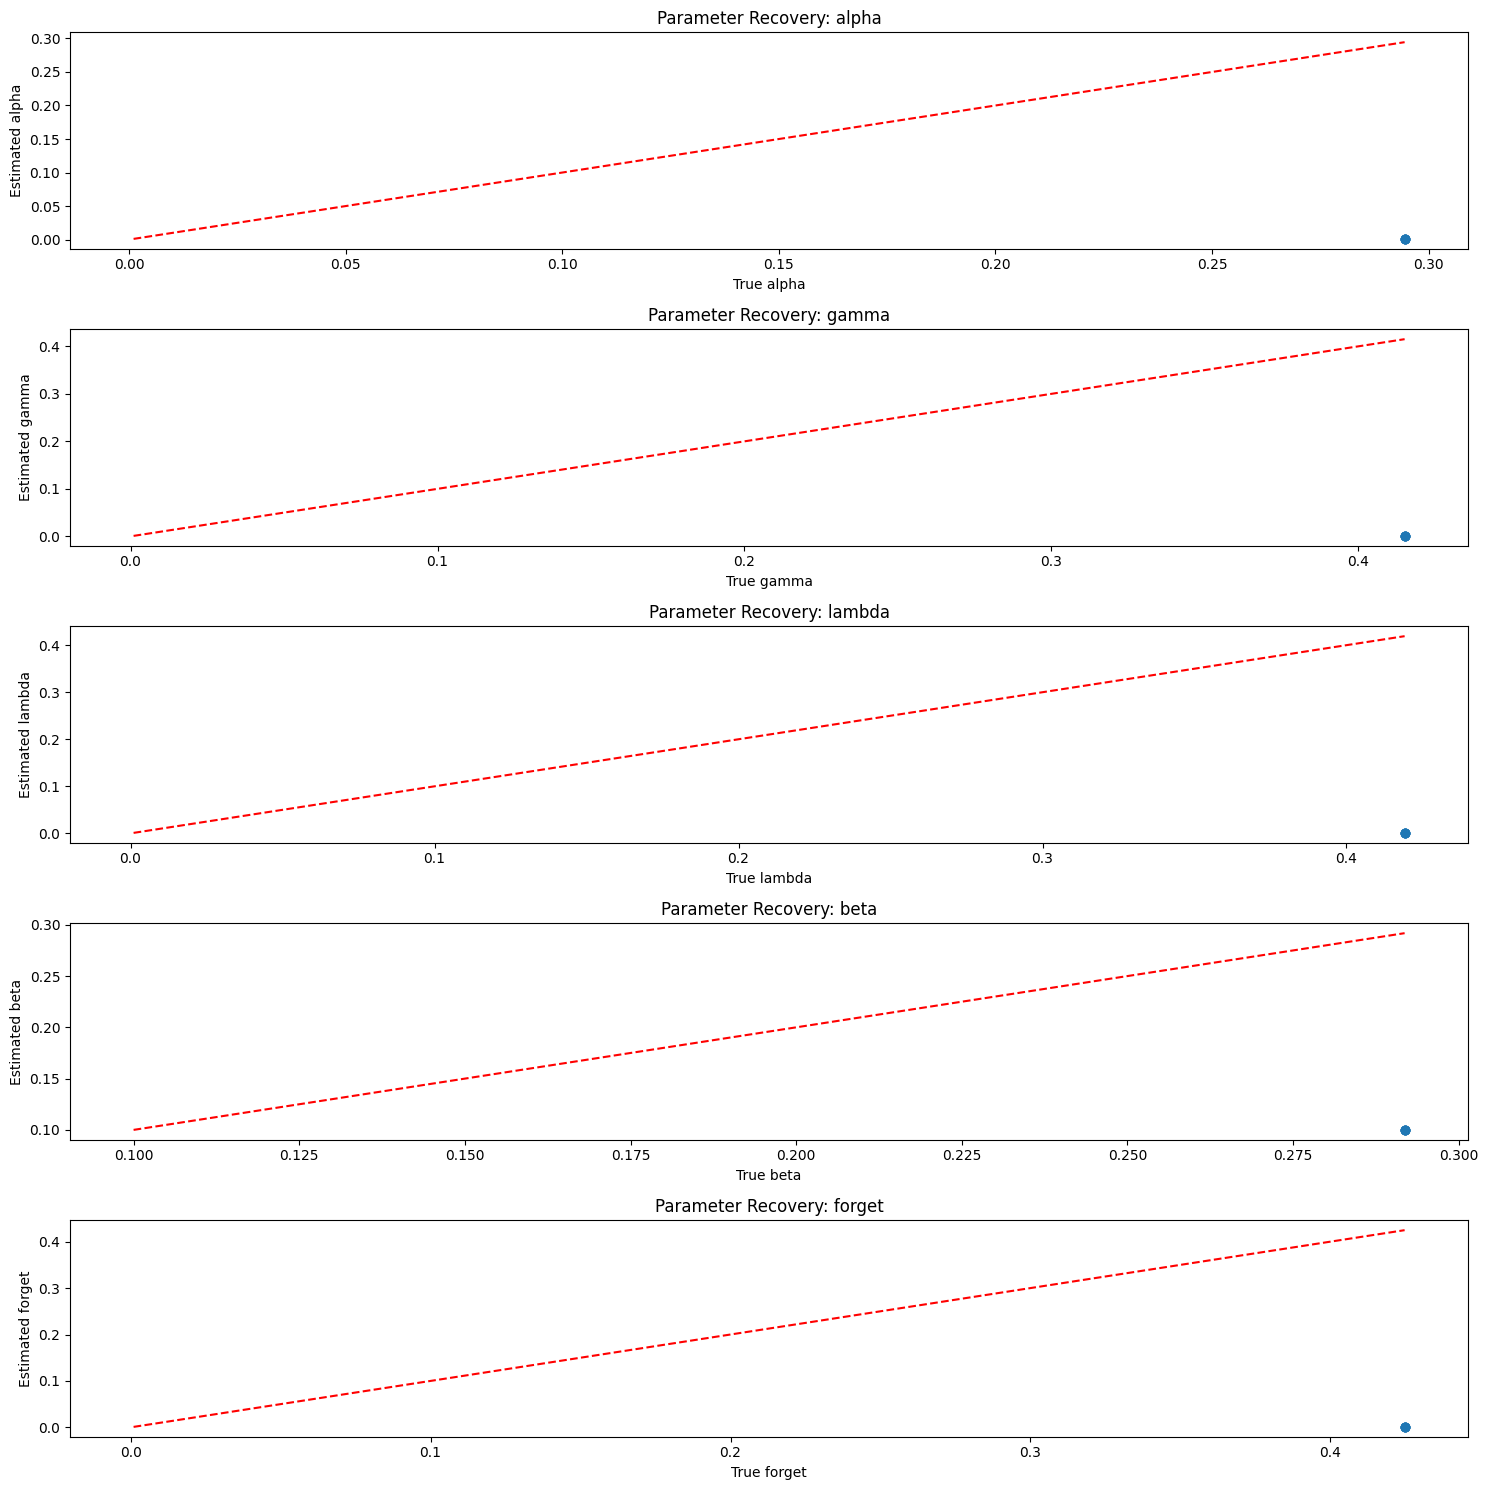

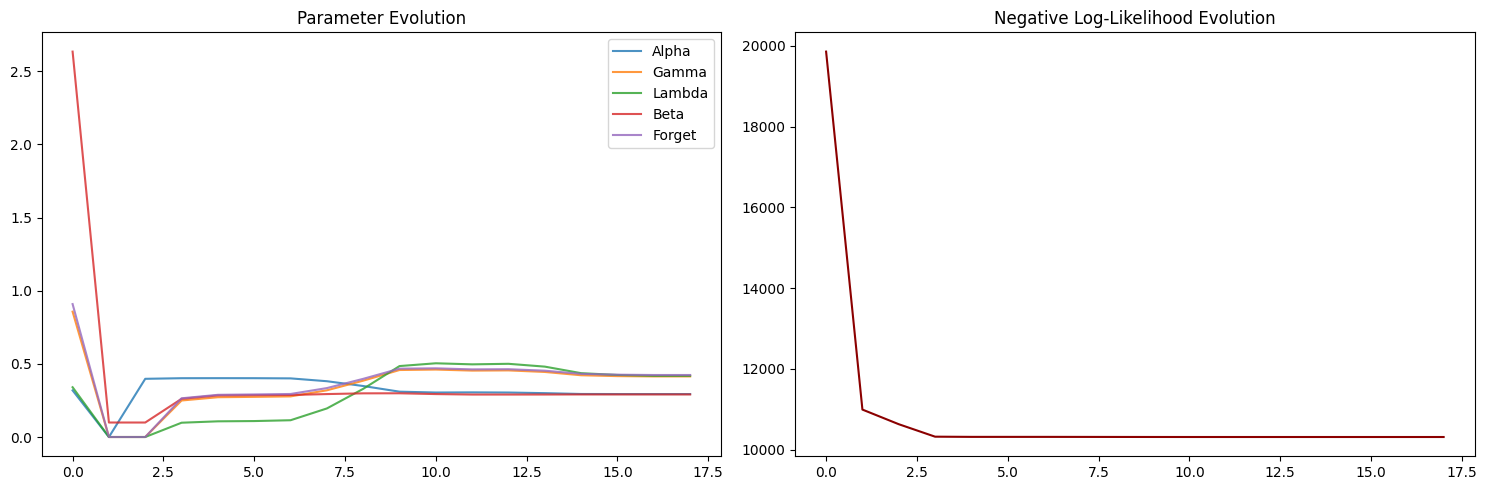


Behavior Match Rate: 45.2%
Match Ratio for 2-choice States: 49.6%
Match Ratio for 3-choice States: 32.8%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import defaultdict
import os


class HMazeEnvironment:
    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self._build_transitions()
        self.legal_next_states = self._build_legal_next_states()
        self._validate_transitions()

    def _build_transitions(self):
        return {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11, 2: 3,   3: 12},
            12: {0: 12, 1: 12, 2: 11,  3: 13},
            13: {0: 13, 1: 13, 2: 12,  3: 8}
        }

    def _build_legal_next_states(self):
        legal_dict = {}
        for s in self.states:
            possible_next = set(self.transitions[s].values())
            possible_next.discard(s)  # 移除停留在原地的选项
            legal_dict[s] = sorted(list(possible_next))
        return legal_dict

    def _validate_transitions(self):
        for s, transitions in self.transitions.items():
            assert all(nx in self.states for nx in transitions.values()), f"Invalid transition from {s}"

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state


def initialize_QE_dict(env):
    from collections import defaultdict
    Q = defaultdict(dict)
    E = defaultdict(lambda: defaultdict(float))
    for s in env.states:
        for nx in env.legal_next_states[s]:
            Q[s][nx] = 0.0
            E[s][nx] = 0.0
    return Q, E

def update_eligibility(E, state, action, lambda_, gamma):
    for s in E:
        for a in E[s]:
            E[s][a] *= gamma * lambda_
    E[state][action] += 1 
    return E

def softmax(q_values, beta):
    max_q = np.max(q_values)
    exp_values = np.exp(beta * (q_values - max_q))
    return exp_values / (exp_values.sum() + 1e-12)


def prepare_training_data(data_path):
    dfs = []
    for fn in [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]:
        df = pd.read_csv(os.path.join(data_path, fn), delimiter=',')
        df['session_date'] = "_".join(fn.split('_')[1:4]) if '_' in fn else 'unknown'
        dfs.append(df)
    
    full_df = pd.concat(dfs).sort_values(
        ['session_date', 'TotalEpisodeNum', 'TrialNum']
    ).reset_index(drop=True)
    
    processed_df = full_df[
        (full_df['Choice'] != -1) & 
        (full_df['Control'] == 0)
    ].copy()
    
    return processed_df.to_dict('records')


def compute_log_likelihood_sarsa_lambda(params, data, env, reset_episodes=False, seed=0):

    np.random.seed(seed)
    alpha, gamma, lambda_, log_beta, forget = params
    beta = np.clip(np.exp(log_beta), 1e-3, 1e3)
    
    Q, E = initialize_QE_dict(env)
    current_episode = None
    neg_log_lik = 0.0
    
    for idx in range(len(data)):
        tr = data[idx]
        st = tr['CurrentState']
        cho = tr['ChosenState']
        gst = tr['Goal']
        
        if reset_episodes and (tr['TotalEpisodeNum'] != current_episode):
            Q, E = initialize_QE_dict(env)
            current_episode = tr['TotalEpisodeNum']
        
        legal_actions = list(Q[st].keys())
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        try:
            action_index = legal_actions.index(cho)
        except ValueError:
            continue  
        
        neg_log_lik -= np.log(probs[action_index] + 1e-12)
        
        next_st = env.get_next_state(st, cho)
        reward = 5 if (next_st == gst) else -1
        
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == current_episode:
            next_a = data[idx+1]['ChosenState']
            td_error = reward + gamma * Q[next_st][next_a] - Q[st][cho]
        else:
            td_error = reward - Q[st][cho]
        
        E = update_eligibility(E, st, cho, lambda_, gamma)
        
        for s in Q:
            for a in Q[s]:
                Q[s][a] += alpha * td_error * E[s][a]
                E[s][a] *= forget
    
    return neg_log_lik


def optimize_parameters(data, env, n_restarts=3):
    best_result = None
    all_results = []
    
    for run in range(n_restarts):
        init_params = [
            np.random.uniform(0.1, 0.5),          # alpha
            np.random.uniform(0.5, 1.0),          # gamma
            np.random.uniform(0.1, 0.5),          # lambda
            np.log(np.random.uniform(1, 4)),      # log_beta
            np.random.uniform(0.85, 0.99)         # forget
        ]

        initial_loss = compute_log_likelihood_sarsa_lambda(init_params, data, env, seed=0)
        
        run_history = {
            'params': [],
            'loss': [],
            'run_id': run
        }
        
        def callback(xk):
            run_history['params'].append(xk.copy())
            current_loss = compute_log_likelihood_sarsa_lambda(xk, data, env, seed=0)
            run_history['loss'].append(current_loss)
        
        result = minimize(
            lambda p: compute_log_likelihood_sarsa_lambda(p, data, env, seed=0),
            init_params,
            method='L-BFGS-B',
            bounds=[
                (0.001, 0.999),           # alpha
                (0.001, 0.999),           # gamma
                (0.001, 0.999),           # lambda
                (np.log(0.1), np.log(10)),# log_beta
                (0.001, 0.999)            # forget
            ],
            callback=callback,
            options={'maxiter': 200, 'disp': True}
        )
        
        final_entry = {
            'initial_params': init_params,
            'initial_loss': initial_loss,
            'final_params': result.x,
            'final_loss': result.fun,
            'history': run_history
        }
        all_results.append(final_entry)
        
        if (best_result is None) or (result.fun < best_result['final_loss']):
            best_result = final_entry
    
    return best_result, all_results


def simulate_agent_behavior(env, data, params, n_episodes=None, seed=None):
    alpha = params['alpha']
    gamma = params['gamma']
    lambda_ = params['lambda']
    beta = params['beta']
    forget = params['forget']
    
    if seed is not None:
        np.random.seed(seed)
    
    Q, E = initialize_QE_dict(env)
    sim_data = []
    current_episode = None
    
    for idx, tr in enumerate(data):
        if n_episodes is not None and tr['TotalEpisodeNum'] > n_episodes:
            continue
        
        if tr['TotalEpisodeNum'] != current_episode:
            Q, E = initialize_QE_dict(env)
            current_episode = tr['TotalEpisodeNum']
        
        st = tr['CurrentState']
        gst = tr['Goal']
        
        legal_actions = list(Q[st].keys())
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        action = np.random.choice(legal_actions, p=probs)
        
        new_record = tr.copy()
        new_record['ChosenState'] = action  
        sim_data.append(new_record)
        
        reward = 5 if (action == gst) else -1
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == current_episode:
            next_st = data[idx+1]['CurrentState']
            next_a = data[idx+1]['ChosenState']  
            td_error = reward + gamma * Q[next_st][next_a] - Q[st][action]
        else:
            td_error = reward - Q[st][action]
        
        E = update_eligibility(E, st, action, lambda_, gamma)

        for s in Q:
            for a in Q[s]:
                Q[s][a] += alpha * td_error * E[s][a]
                E[s][a] *= forget
    
    return sim_data


def parameter_recovery_test(env, data, alpha, gamma, lambda_, beta, forget, n_simulations=10):
    true_params = {
        'alpha': alpha,
        'gamma': gamma,
        'lambda': lambda_,
        'beta': beta,
        'forget': forget
    }
    
    recovery_results = []
    for sim in range(n_simulations):
        simulated_data = simulate_agent_behavior(env, data, true_params, n_episodes=None, seed=sim)
        
        best_result, _ = optimize_parameters(simulated_data, env)
        best_params = best_result['final_params']
        
        recovery_results.append({
            'true': true_params,
            'estimated': {
                'alpha': best_params[0],
                'gamma': best_params[1],
                'lambda': best_params[2],
                'beta': np.exp(best_params[3]),
                'forget': best_params[4]
            }
        })
    
    plot_parameter_recovery(recovery_results)
    return recovery_results

def plot_parameter_recovery(results):
    params = ['alpha', 'gamma', 'lambda', 'beta', 'forget']
    plt.figure(figsize=(15, 3*len(params)))
    
    for i, param in enumerate(params, 1):
        plt.subplot(len(params), 1, i)
        true_vals = [r['true'][param] for r in results]
        est_vals = [r['estimated'][param] for r in results]
        plt.scatter(true_vals, est_vals, alpha=0.6)
        min_val = min(true_vals + est_vals)
        max_val = max(true_vals + est_vals)
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.xlabel('True ' + param)
        plt.ylabel('Estimated ' + param)
        plt.title(f'Parameter Recovery: {param}')
    
    plt.tight_layout()
    plt.show()


def plot_optimization_history(best_result):
    params = np.array(best_result['history']['params'])
    params = np.insert(params, 0, best_result['initial_params'], axis=0)
    losses = best_result['history']['loss']
    losses = np.insert(losses, 0, best_result['initial_loss'])
    
    plt.figure(figsize=(15, 5))
    param_names = ['Alpha', 'Gamma', 'Lambda', 'Beta', 'Forget']
    
    plt.subplot(1, 2, 1)
    for i in range(5):
        vals = params[:, i] if i != 3 else np.exp(params[:, 3])
        plt.plot(vals, label=param_names[i], alpha=0.8)
    plt.legend()
    plt.title('Parameter Evolution')
    
    plt.subplot(1, 2, 2)
    plt.plot(losses, color='darkred')
    plt.title('Negative Log-Likelihood Evolution')
    
    plt.tight_layout()
    plt.show()


def validate_model(env, data, final_params):
    alpha, gamma, lambda_, log_beta, forget = final_params
    beta = np.exp(log_beta)
    params = {'alpha': alpha, 'gamma': gamma, 'lambda': lambda_, 'beta': beta, 'forget': forget}
    
    sim_data = simulate_agent_behavior(env, data, params, n_episodes=None, seed=0)
    
    total = 0
    match = 0
    match2_count = 0
    match3_count = 0
    count2 = 0
    count3 = 0
    for sim_record, real_record in zip(sim_data, data):
        if 'ChosenState' in sim_record:
            total += 1
            if sim_record['ChosenState'] == real_record['ChosenState']:
                match += 1
            num_choices = len(env.legal_next_states[real_record['CurrentState']])
            if num_choices == 2:
                count2 += 1
                if sim_record['ChosenState'] == real_record['ChosenState']:
                    match2_count += 1
            elif num_choices == 3:
                count3 += 1
                if sim_record['ChosenState'] == real_record['ChosenState']:
                    match3_count += 1
    
    match_rate = match / total if total > 0 else 0
    match2 = match2_count / count2 if count2 > 0 else 0
    match3 = match3_count / count3 if count3 > 0 else 0
    final_Q = None
    return match_rate, final_Q, match2, match3


if __name__ == "__main__":
    env = HMazeEnvironment()

    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    training_data = prepare_training_data(data_path)
    
    best_result, _ = optimize_parameters(training_data, env, n_restarts=5)
    final_params = best_result['final_params']
    
    print("\n=== Final Parameters ===")
    print(f"Alpha: {final_params[0]:.4f}")
    print(f"Gamma: {final_params[1]:.4f}")
    print(f"Lambda: {final_params[2]:.4f}")
    print(f"Beta: {np.exp(final_params[3]):.4f}")
    print(f"Forget: {final_params[4]:.4f}")

    print("Running parameter recovery test...")
    recovery_results = parameter_recovery_test(
        env,
        training_data,
        alpha=final_params[0],
        gamma=final_params[1],
        lambda_=final_params[2],
        beta=np.exp(final_params[3]),
        forget=final_params[4]
    )
    
    plot_optimization_history(best_result)
    
    match_rate, final_Q, match2, match3 = validate_model(env, training_data, final_params)
    print(f"\nBehavior Match Rate: {match_rate:.1%}")
    print(f"Match Ratio for 2-choice States: {match2:.1%}")
    print(f"Match Ratio for 3-choice States: {match3:.1%}")



Sarsa lambda

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
from collections import defaultdict
import os


class HMazeEnvironment:
    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self._build_transitions()
        self.legal_next_states = self._build_legal_next_states()
        self._validate_transitions()

    def _build_transitions(self):
        return {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11, 2: 3,   3: 12},
            12: {0: 12, 1: 12, 2: 11,  3: 13},
            13: {0: 13, 1: 13, 2: 12,  3: 8}
        }

    def _build_legal_next_states(self):
        legal_dict = {}
        for s in self.states:
            possible_next = set(self.transitions[s].values())
            possible_next.discard(s) 
            legal_dict[s] = sorted(list(possible_next))
        return legal_dict

    def _validate_transitions(self):
        for s, transitions in self.transitions.items():
            assert all(nx in self.states for nx in transitions.values()), f"Invalid transition from {s}"

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state


def initialize_QE_dict(env):
    Q = defaultdict(dict)
    E = defaultdict(lambda: defaultdict(float))
    for s in env.states:
        for nx in env.legal_next_states[s]:
            Q[s][nx] = 0.0
            E[s][nx] = 0.0
    return Q, E

def update_eligibility(E, state, action, lambda_, gamma):
    for s in E:
        for a in E[s]:
            E[s][a] *= gamma * lambda_
    E[state][action] += 1 
    return E

def softmax(q_values, beta):
    max_q = np.max(q_values)
    exp_values = np.exp(beta * (q_values - max_q))
    return exp_values / (exp_values.sum() + 1e-12)


def prepare_training_data(data_path):
    dfs = []
    for fn in [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]:
        df = pd.read_csv(os.path.join(data_path, fn), delimiter=',')
        df['session_date'] = "_".join(fn.split('_')[1:4]) if '_' in fn else 'unknown'
        dfs.append(df)
    
    full_df = pd.concat(dfs).sort_values(
        ['session_date', 'TotalEpisodeNum', 'TrialNum']
    ).reset_index(drop=True)
    
    processed_df = full_df[
        (full_df['Choice'] != -1) & 
        (full_df['Control'] == 0)
    ].copy()
    
    return processed_df.to_dict('records')


def compute_log_likelihood_sarsa_lambda(params, data, env, reset_episodes=False, seed=0):
    np.random.seed(seed)
    alpha, gamma, lambda_, log_beta, forget = params 
    beta = np.clip(np.exp(log_beta), 1e-3, 1e3)
    
    Q, E = initialize_QE_dict(env)
    current_episode = None
    neg_log_lik = 0.0
    
    for idx in range(len(data)):
        tr = data[idx]
        st = tr['CurrentState']
        cho = tr['ChosenState']
        gst = tr['Goal']
        
        if reset_episodes and (tr['TotalEpisodeNum'] != current_episode):
            Q, E = initialize_QE_dict(env)
            current_episode = tr['TotalEpisodeNum']
        
        legal_actions = list(Q[st].keys())
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        try:
            action_index = legal_actions.index(cho)
        except ValueError:
            continue
        neg_log_lik -= np.log(probs[action_index] + 1e-12)
        
        next_st = env.get_next_state(st, cho)
        reward = 5 if (next_st == gst) else -1
        
        if idx < len(data) - 1 and data[idx+1]['TotalEpisodeNum'] == current_episode:
            next_a = data[idx+1]['ChosenState']
            td_error = reward + gamma * Q[next_st][next_a] - Q[st][cho]
        else:
            td_error = reward - Q[st][cho]
        
        E = update_eligibility(E, st, cho, lambda_, gamma)
        
        for s in Q:
            for a in Q[s]:
                Q[s][a] += alpha * td_error * E[s][a]
                E[s][a] *= forget  
                
    return neg_log_lik

def optimize_parameters(data,
                        env,
                        n_restarts=10,
                        use_global_optimization=True):
    param_bounds = [
        (0.001, 0.999),         # alpha
        (0.001, 0.999),         # gamma
        (0.001, 0.999),         # lambda
        (np.log(0.1), np.log(10)), # log_beta
        (0.001, 0.999)          # forget
    ]
    
    best_result = None
    all_results = []
    
    if use_global_optimization:
        def global_loss_fn(x):
            return compute_log_likelihood_sarsa_lambda(x, data, env, seed=0)
        
        global_result = differential_evolution(
            global_loss_fn,
            param_bounds,
            maxiter=100,       
            polish=False,      
            tol=1e-4,
            updating='deferred'
        )
        
        global_entry = {
            'initial_params': None,
            'final_params': global_result.x,
            'final_loss': global_result.fun,
            'history': None,
            'method': 'differential_evolution'
        }
        all_results.append(global_entry)
        
        global_init_params = global_result.x
    else:
        global_init_params = None
    
    for run in range(n_restarts):
        if run == 0 and global_init_params is not None:
            init_params = global_init_params
        else:
            init_params = [
                np.random.uniform(0.1, 0.5),
                np.random.uniform(0.5, 1.0),
                np.random.uniform(0.1, 0.5),
                np.log(np.random.uniform(1, 4)),
                np.random.uniform(0.85, 0.99)
            ]
        
        run_history = {
            'params': [],
            'loss': [],
            'run_id': run
        }
        
        def callback(xk):
            run_history['params'].append(xk.copy())
            current_loss = compute_log_likelihood_sarsa_lambda(xk, data, env, seed=0)
            run_history['loss'].append(current_loss)
        
        result = minimize(
            lambda p: compute_log_likelihood_sarsa_lambda(p, data, env, seed=0),
            init_params,
            method='L-BFGS-B',
            bounds=param_bounds,
            callback=callback,
            options={'maxiter': 300, 'disp': True}
        )
        
        final_entry = {
            'initial_params': init_params,
            'final_params': result.x,
            'final_loss': result.fun,
            'history': run_history,
            'method': 'L-BFGS-B'
        }
        all_results.append(final_entry)
        
        if (best_result is None) or (result.fun < best_result['final_loss']):
            best_result = final_entry
    
    return best_result, all_results


def parameter_recovery_test(env, data, alpha, gamma, lambda_, beta, forget, n_simulations=20):
    true_params = {
        'alpha': alpha,
        'gamma': gamma,
        'lambda': lambda_,
        'beta': beta,
        'forget': forget
    }
    
    recovery_results = []
    for sim in range(n_simulations):
        simulated_data = simulate_agent_behavior(env, data, true_params, n_episodes=50, seed=sim)
        best_result, _ = optimize_parameters(simulated_data, env,
                                             n_restarts=5, 
                                             use_global_optimization=True)
        best_params = best_result['final_params']
        recovery_results.append({
            'true': true_params,
            'estimated': {
                'alpha': best_params[0],
                'gamma': best_params[1],
                'lambda': best_params[2],
                'beta': np.exp(best_params[3]),
                'forget': best_params[4]
            }
        })
    
    plot_parameter_recovery(recovery_results)
    return recovery_results

def simulate_agent_behavior(env, data, params, n_episodes=None, seed=None):
    alpha = params['alpha']
    gamma = params['gamma']
    lambda_ = params['lambda']
    beta = params['beta']
    forget = params['forget']
    
    if seed is not None:
        np.random.seed(seed)
    
    Q, E = initialize_QE_dict(env)
    sim_data = []  
    current_episode = None
    
    for idx, tr in enumerate(data):
        if n_episodes is not None and tr['TotalEpisodeNum'] > n_episodes:
            continue
        
        st = tr['CurrentState']
        gst = tr['Goal']
        
        if tr['TotalEpisodeNum'] != current_episode:
            Q, E = initialize_QE_dict(env)
            current_episode = tr['TotalEpisodeNum']
        
        legal_actions = list(Q[st].keys())
        q_vals = np.array([Q[st][a] for a in legal_actions])
        probs = softmax(q_vals, beta)
        action = np.random.choice(legal_actions, p=probs)
        
        new_record = tr.copy()
        new_record['SimulatedAction'] = action
        sim_data.append(new_record)
        
        next_st = env.get_next_state(st, action)
        reward = 5 if (next_st == gst) else -1
        
        if idx < len(data)-1 and data[idx+1]['TotalEpisodeNum'] == current_episode:
            legal_actions_next = list(Q[next_st].keys())
            q_vals_next = np.array([Q[next_st][a] for a in legal_actions_next])
            probs_next = softmax(q_vals_next, beta)
            next_action = np.random.choice(legal_actions_next, p=probs_next)
            td_target = reward + gamma * Q[next_st][next_action]
        else:
            td_target = reward
        
        E = update_eligibility(E, st, action, lambda_, gamma)

        for s in Q:
            for a in Q[s]:
                Q[s][a] += alpha * (td_target - Q[s][a]) * E[s][a]
                E[s][a] *= forget
                
    return sim_data

def plot_parameter_recovery(results):
    params = ['alpha', 'gamma', 'lambda', 'beta', 'forget']
    plt.figure(figsize=(15, 3*len(params)))
    
    for i, param in enumerate(params, 1):
        plt.subplot(len(params), 1, i)
        true_vals = [r['true'][param] for r in results]
        est_vals = [r['estimated'][param] for r in results]
        plt.scatter(true_vals, est_vals, alpha=0.6)
        line_min = min(min(true_vals), min(est_vals))
        line_max = max(max(true_vals), max(est_vals))
        plt.plot([line_min, line_max], [line_min, line_max], 'r--')
        plt.xlabel('True ' + param)
        plt.ylabel('Estimated ' + param)
        plt.title(f'Parameter Recovery: {param}')
    
    plt.tight_layout()
    plt.show()

def plot_optimization_history(best_result):
    params = np.array(best_result['history']['params'])
    losses = best_result['history']['loss']
    
    plt.figure(figsize=(15, 5))
    param_names = ['Alpha', 'Gamma', 'Lambda', 'Beta', 'Forget']
    
    plt.subplot(1, 2, 1)
    for i in range(5):
        vals = params[:, i] if i != 3 else np.exp(params[:, 3])
        plt.plot(vals, label=param_names[i], alpha=0.8)
    plt.legend()
    plt.title('Parameter Evolution')
    plt.subplot(1, 2, 2)
    plt.plot(losses, color='darkred')
    plt.title('Negative Log-Likelihood Evolution')
    plt.tight_layout()
    plt.show()


def validate_model(env, data, final_params):
    alpha, gamma, lambda_, log_beta, forget = final_params
    beta = np.exp(log_beta)
    params = {'alpha': alpha, 'gamma': gamma, 'lambda': lambda_, 'beta': beta, 'forget': forget}
    
    sim_data = simulate_agent_behavior(env, data, params, n_episodes=None, seed=0)
    
    total = 0
    match = 0
    match2_count = 0
    match3_count = 0
    count2 = 0
    count3 = 0
    for sim_record, real_record in zip(sim_data, data):
        if 'SimulatedAction' in sim_record:
            total += 1
            if sim_record['SimulatedAction'] == real_record['ChosenState']:
                match += 1
            num_choices = len(env.legal_next_states[real_record['CurrentState']])
            if num_choices == 2:
                count2 += 1
                if sim_record['SimulatedAction'] == real_record['ChosenState']:
                    match2_count += 1
            elif num_choices == 3:
                count3 += 1
                if sim_record['SimulatedAction'] == real_record['ChosenState']:
                    match3_count += 1
    match_rate = match / total if total > 0 else 0
    match2 = match2_count / count2 if count2 > 0 else 0
    match3 = match3_count / count3 if count3 > 0 else 0
    final_Q = None  
    return match_rate, final_Q, match2, match3


if __name__ == "__main__":
    env = HMazeEnvironment()
    
    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    training_data = prepare_training_data(data_path)
    best_result, _ = optimize_parameters(training_data,
                                         env,
                                         n_restarts=10,
                                         use_global_optimization=True)
    final_params = best_result['final_params']
    
    print("\n=== Final Parameters ===")
    print(f"Alpha: {final_params[0]:.4f}")
    print(f"Gamma: {final_params[1]:.4f}")
    print(f"Lambda: {final_params[2]:.4f}")
    print(f"Beta: {np.exp(final_params[3]):.4f}")
    print(f"Forget: {final_params[4]:.4f}")

    print("\nRunning parameter recovery test...")
    recovery_results = parameter_recovery_test(env,
                                               training_data,
                                               final_params[0],
                                               final_params[1],
                                               final_params[2],
                                               np.exp(final_params[3]),
                                               final_params[4])
    
    plot_optimization_history(best_result)
    
    match_rate, final_Q, match2, match3 = validate_model(env,
                                                         training_data,
                                                         final_params)
    print(f"\nBehavior Match Rate: {match_rate:.1%}")
    print(f"Match Ratio for 2-choice States: {match2:.1%}")
    print(f"Match Ratio for 3-choice States: {match3:.1%}")


KeyboardInterrupt: 

In [ ]:
import numpy as np
from functools import partial
from scipy.optimize import minimize

# ==============================
# fix gamma, only fit alpha & log_beta
# ==============================
def log_likelihood_fixed_gamma(params, gamma_fixed, observed_data, env, reset_q_each_episode=False):
    alpha, log_beta = params
    gamma = gamma_fixed

    full_params = (alpha, gamma, log_beta)

    return log_likelihood(full_params, observed_data, env, reset_q_each_episode)


def fit_alpha_beta_with_fixed_gamma(gamma_val, observed_data, env, reset_q_each_episode=False):
    init_alpha = 0.1
    init_log_beta = np.log(1.0)
    init_params = [init_alpha, init_log_beta]

    # alpha in [0, 1]
    # log_beta in [log(0.1), log(10)]
    bounds = [(0, 1), (np.log(0.1), np.log(10))]
    objective = lambda p: log_likelihood_fixed_gamma(
        p,
        gamma_fixed=gamma_val,
        observed_data=observed_data,
        env=env,
        reset_q_each_episode=reset_q_each_episode
    )

    res = minimize(
        objective,
        init_params,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 200, 'disp': True}
    )

    best_alpha = res.x[0]
    best_log_beta = res.x[1]
    best_beta = np.exp(best_log_beta)
    best_neg_ll = res.fun

    return best_alpha, best_beta, best_neg_ll, res


# ==============================
# in different gamma
# ==============================
def examine_gamma_grid(gamma_grid, observed_data, env, reset_q_each_episode=False, compute_aic_bic=True):
    results = []

    n = len(observed_data)

    k = 2

    for g in gamma_grid:
        print(f"\n=== Fitting alpha,beta with gamma={g} fixed ===")
        best_alpha, best_beta, best_neg_ll, _ = fit_alpha_beta_with_fixed_gamma(
            g, observed_data, env, reset_q_each_episode
        )

        # AIC = 2*k + 2*negLL
        # BIC = k * ln(n) + 2*negLL

        if compute_aic_bic:
            AIC = 2 * k + 2 * best_neg_ll
            BIC = k * np.log(n) + 2 * best_neg_ll
        else:
            AIC, BIC = None, None

        print(f"  gamma={g:.3f}, alpha={best_alpha:.3f}, beta={best_beta:.3f}, negLL={best_neg_ll:.2f}, AIC={AIC}, BIC={BIC}")

        results.append({
            'gamma': g,
            'alpha': best_alpha,
            'beta': best_beta,
            'neg_ll': best_neg_ll,
            'AIC': AIC,
            'BIC': BIC
        })

    return results


if __name__ == "__main__":
    env = HMazeEnvironment()

    gamma_candidates = [0.0, 0.1, 0.5, 0.9]

    results = examine_gamma_grid(
        gamma_candidates, 
        observed_data, 
        env,
        reset_q_each_episode=False, 
        compute_aic_bic=True  
    )

    import pandas as pd
    df_results = pd.DataFrame(results)
    print("\n=== Summary of different gamma fits ===")
    print(df_results)


legal_next_states: {1: [2], 2: [1, 3], 3: [2, 4, 11], 4: [3, 5], 5: [4], 6: [7], 7: [6, 8], 8: [7, 9, 13], 9: [8, 10], 10: [9], 11: [3, 12], 12: [11, 13], 13: [8, 12]}

=== Fitting alpha,beta with gamma=0.0 fixed ===
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69731D+04    |proj g|=  2.30259D+00

At iterate    1    f=  1.64774D+04    |proj g|=  1.54303D+00

At iterate    2    f=  1.63877D+04    |proj g|=  3.31980D+00

At iterate    3    f=  1.63372D+04    |proj g|=  3.32578D+00

At iterate    4    f=  1.63292D+04    |proj g|=  1.37956D+00

At iterate    5    f=  1.63284D+04    |proj g|=  1.36218D+00

At iterate    6    f=  1.63284D+04    |proj g|=  1.54432D-01
  gamma=0.000, alpha=0.774, beta=2.564, negLL=16328.42, AIC=32660.845797143324, BIC=32676.917984177493
At iterate    7    f=  1.63284D+04    |proj g|=  2.38288D-02

           * * *


### Test Factors Regarding Gamma (It's always 0 now)

       TotalEpisodeNum  EpisodeLength
count      3974.000000    3974.000000
mean         54.495722       5.746351
std          38.839857       4.858592
min           1.000000       1.000000
25%          23.000000       2.000000
50%          48.000000       4.000000
75%          78.000000       6.000000
max         179.000000      64.000000


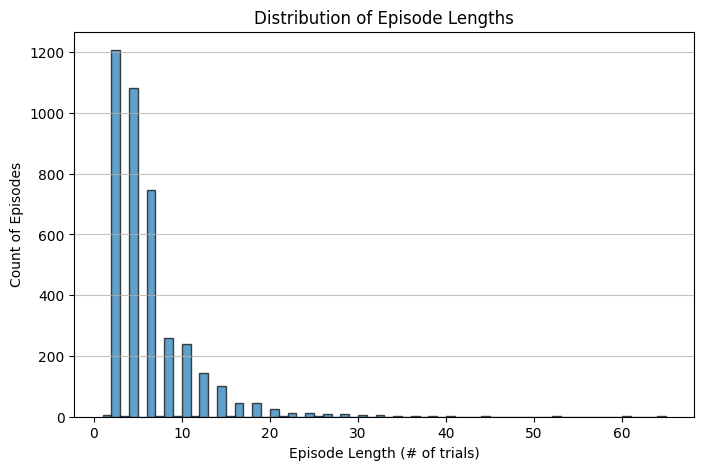

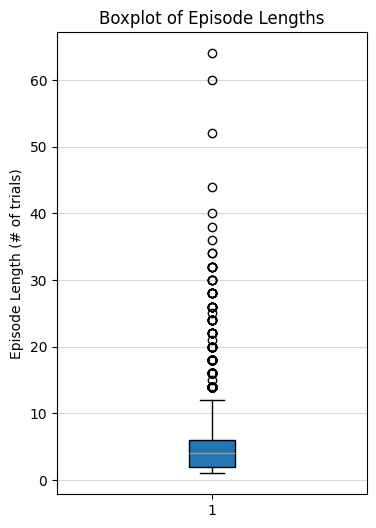

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_episode_length_distribution(df):
    group_cols = ['session_date','TotalEpisodeNum']
    ep_sizes = df.groupby(group_cols).size().reset_index(name='EpisodeLength')

    print(ep_sizes.describe())

    plt.figure(figsize=(8,5))
    plt.hist(ep_sizes['EpisodeLength'], bins=range(1, ep_sizes['EpisodeLength'].max()+2), 
             edgecolor='black', alpha=0.7)
    plt.xlabel("Episode Length (# of trials)")
    plt.ylabel("Count of Episodes")
    plt.title("Distribution of Episode Lengths")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    plt.figure(figsize=(4,6))
    plt.boxplot(ep_sizes['EpisodeLength'], vert=True, patch_artist=True)
    plt.ylabel("Episode Length (# of trials)")
    plt.title("Boxplot of Episode Lengths")
    plt.grid(axis='y', alpha=0.5)
    plt.show()

plot_episode_length_distribution(all_df)


{1: [2], 2: [1, 3], 3: [2, 4, 11], 4: [3, 5], 5: [4], 6: [7], 7: [6, 8], 8: [7, 9, 13], 9: [8, 10], 10: [9], 11: [3, 12], 12: [11, 13], 13: [8, 12]}
       TotalEpisodeNum  episode_length
count       779.000000      779.000000
mean         54.505777        7.146341
std          38.737345        5.392954
min           1.000000        1.000000
25%          24.000000        4.000000
50%          48.000000        6.000000
75%          77.500000       10.000000
max         174.000000       30.000000
Total episodes: 779;   Long episodes (≥6) : 441
Full data trials: 5567;  Long episodes data trials: 4594
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01816D+03    |proj g|=  2.30259D+00

At iterate    1    f=  2.72347D+03    |proj g|=  1.36393D+00

At iterate    2    f=  2.70895D+03    |proj g|=  3.41628D+00

At iterate    3    f=  2.70690D+03    |pr

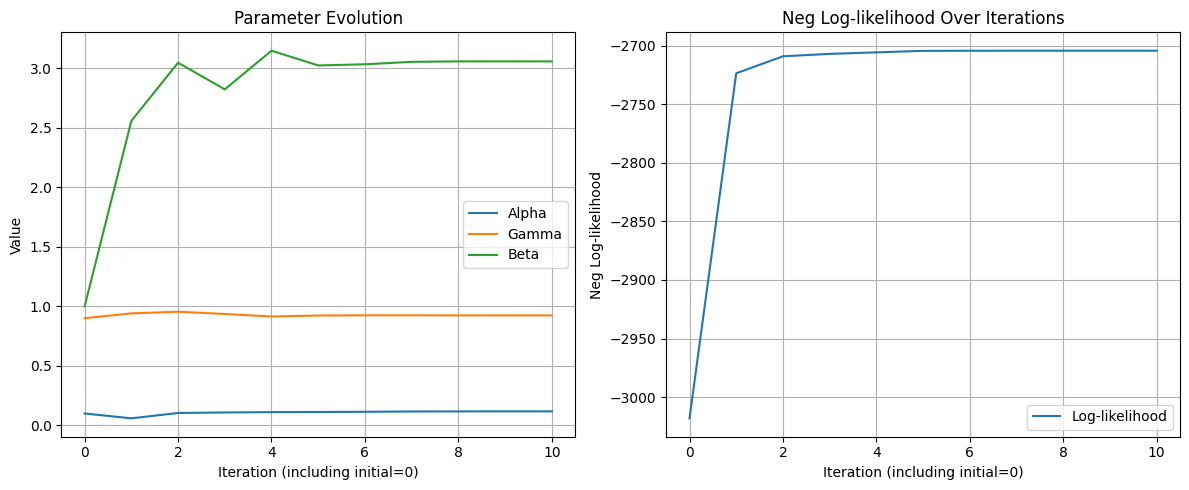

Model vs Real 'NextState' match ratio (overall): 58.5%
Match ratio for states with 2 choices: 60.5%   (n=2997 trials)
Match ratio for states with 3 choices: 43.7%   (n=1282 trials)


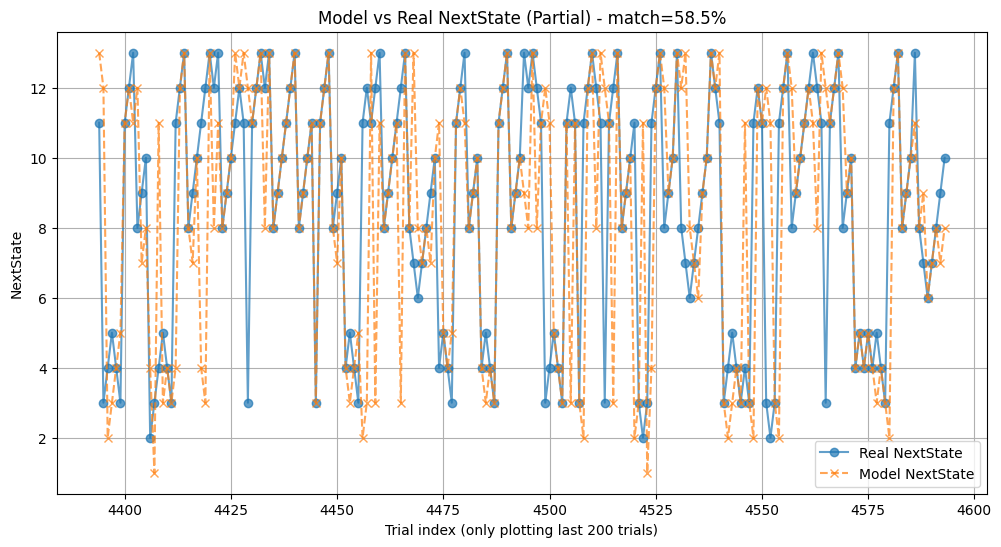

Final Q dictionary:
 State 1 -> Q-values:
    to 2: 0.08
 State 2 -> Q-values:
    to 1: 0.05
    to 3: 0.17
 State 3 -> Q-values:
    to 2: 0.14
    to 4: 0.14
    to 11: 0.35
 State 4 -> Q-values:
    to 3: 0.23
    to 5: 0.13
 State 5 -> Q-values:
    to 4: 0.14
 State 6 -> Q-values:
    to 7: 0.58
 State 7 -> Q-values:
    to 6: 0.48
    to 8: 0.70
 State 8 -> Q-values:
    to 7: 0.54
    to 9: 0.91
    to 13: 0.52
 State 9 -> Q-values:
    to 8: 0.00
    to 10: 1.00
 State 10 -> Q-values:
    to 9: 0.00
 State 11 -> Q-values:
    to 3: 0.21
    to 12: 0.42
 State 12 -> Q-values:
    to 11: 0.35
    to 13: 0.51
 State 13 -> Q-values:
    to 8: 0.67
    to 12: 0.42


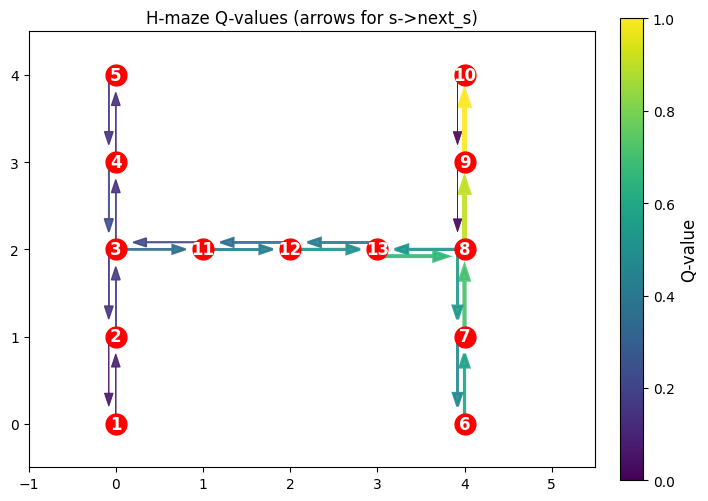

Done!


In [ ]:
if __name__ == "__main__":
    env = HMazeEnvironment()
    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/beh/"
    files = [f for f in os.listdir(data_path) if f.endswith(".txt")]
    dfs=[]
    for fn in files:
        fpath = os.path.join(data_path, fn)
        df = pd.read_csv(fpath, delimiter=',')
        try:
            sdate = "_".join(fn.split('_')[1:4])
        except:
            sdate= "unknown"
        df['session_date']= sdate
        dfs.append(df)
    all_df = pd.concat(dfs, ignore_index=True)
    all_df = all_df.sort_values(by=['session_date','TotalEpisodeNum','TrialNum']).reset_index(drop=True)

    all_df = all_df[ all_df['Choice'] != -1]
    all_df = all_df[ all_df['Goal'] == 10]  

    # filter episode length ≥6 steps
    group_cols = ['session_date', 'TotalEpisodeNum']
    ep_size_df = all_df.groupby(group_cols).size().reset_index(name='episode_length')

    print(ep_size_df.describe())

    long_eps = ep_size_df[ ep_size_df['episode_length'] >= 6]  

    long_df = pd.merge(
        all_df,
        long_eps[group_cols],
        on=group_cols,
        how='inner'
    )

    observed_data_long = prepare_observed_data(env, long_df)

    print(f"Total episodes: {len(ep_size_df)};   Long episodes (≥6) : {len(long_eps)}")
    print(f"Full data trials: {len(all_df)};  Long episodes data trials: {len(long_df)}")

    # use long episodes to simulate
    best_params_long, param_history_long, likelihood_history_long = fit_sarsa_parameters_with_tracking(
        observed_data_long, env, reset_q_each_episode=False
    )
    alpha_l, gamma_l, log_beta_l = best_params_long
    beta_l = np.exp(log_beta_l)

    print("\n===== Long Episode (≥6步) Fit =====")
    print(f"alpha={alpha_l:.5f}, gamma={gamma_l:.5f}, beta={beta_l:.5f}")

    alpha_vals = [p[0] for p in param_history_long]
    gamma_vals = [p[1] for p in param_history_long]
    beta_vals  = [np.exp(p[2]) for p in param_history_long]

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(alpha_vals, label='Alpha')
    plt.plot(gamma_vals, label='Gamma')
    plt.plot(beta_vals,  label='Beta')
    plt.xlabel("Iteration (including initial=0)")
    plt.ylabel("Value")
    plt.title("Parameter Evolution")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(likelihood_history_long, label='Log-likelihood')
    plt.xlabel("Iteration (including initial=0)")
    plt.ylabel("Neg Log-likelihood")
    plt.title("Neg Log-likelihood Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    sim_actions, final_Q = simulate_actions_with_sarsa(
        env, observed_data_long, alpha_l, gamma_l, beta_l, reset_q_each_episode=False
    )

    sorted_data = sorted(
        observed_data_long,
        key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex'])
    )
    real_actions = [d['ChosenState'] for d in sorted_data]
    match_count = sum(int(r == s) for r, s in zip(real_actions, sim_actions))
    match_ratio = match_count / len(real_actions)
    print(f"Model vs Real 'NextState' match ratio (overall): {match_ratio:.1%}")


    num_2_match = 0
    num_2_total = 0
    num_3_match = 0
    num_3_total = 0

    for i, (rd, model_act) in enumerate(zip(sorted_data, sim_actions)):
        st = rd['CurrentState']
        real_act = rd['ChosenState']
        choice_count = len(env.legal_next_states[st])

        if choice_count == 2:
            num_2_total += 1
            if real_act == model_act:
                num_2_match += 1
        elif choice_count == 3:
            num_3_total += 1
            if real_act == model_act:
                num_3_match += 1

    match_2_ratio = num_2_match / num_2_total if num_2_total > 0 else 0
    match_3_ratio = num_3_match / num_3_total if num_3_total > 0 else 0

    print(f"Match ratio for states with 2 choices: {match_2_ratio:.1%}   (n={num_2_total} trials)")
    print(f"Match ratio for states with 3 choices: {match_3_ratio:.1%}   (n={num_3_total} trials)")

    n = len(real_actions)
    num_to_plot = 200
    start_idx = max(0, n - num_to_plot)

    plt.figure(figsize=(12,6))
    plt.plot(range(start_idx,n), real_actions[start_idx:], 'o-', label='Real NextState', alpha=0.7)
    plt.plot(range(start_idx,n), sim_actions[start_idx:], 'x--', label='Model NextState', alpha=0.7)
    plt.xlabel(f"Trial index (only plotting last {num_to_plot} trials)")
    plt.ylabel("NextState")
    plt.title(f"Model vs Real NextState (Partial) - match={match_ratio:.1%}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Final Q dictionary:")
    for s in sorted(final_Q.keys()):
        print(f" State {s} -> Q-values:")
        for nx, val in final_Q[s].items():
            print(f"    to {nx}: {val:.2f}")

    plot_hmaze_Q_arrows(final_Q, env)
    
    print("Done!")

### Test The Implementation of the Model

legal_next_states: {1: [2], 2: [1, 3], 3: [2, 4, 11], 4: [3, 5], 5: [4], 6: [7], 7: [6, 8], 8: [7, 9, 13], 9: [8, 10], 10: [9], 11: [3, 12], 12: [11, 13], 13: [8, 12]}
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82382D+04    |proj g|=  2.30259D+00

At iterate    1    f=  1.77418D+04    |proj g|=  1.00000D+00

At iterate    2    f=  1.76415D+04    |proj g|=  4.60517D+00

At iterate    3    f=  1.65492D+04    |proj g|=  1.45822D+00

At iterate    4    f=  1.64959D+04    |proj g|=  3.38827D+00

At iterate    5    f=  1.63884D+04    |proj g|=  3.21895D+00

At iterate    6    f=  1.63730D+04    |proj g|=  1.53409D+00

At iterate    7    f=  1.63314D+04    |proj g|=  3.29839D+00

At iterate    8    f=  1.63286D+04    |proj g|=  1.37100D+00

At iterate    9    f=  1.63284D+04    |proj g|=  7.75693D-01

At iterate   10    f=  1.63284D+04    |proj 

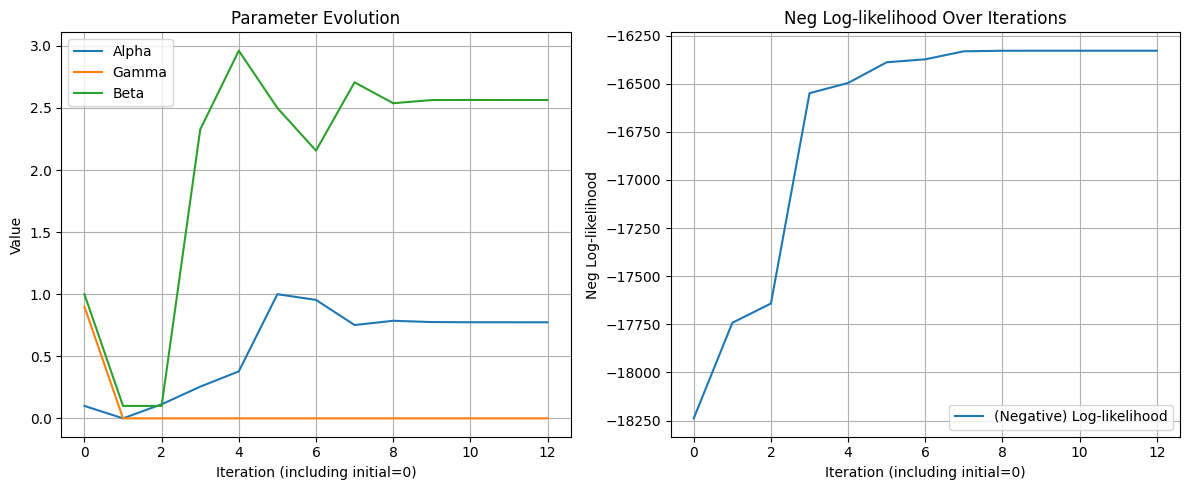

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73501D+04    |proj g|=  2.30259D+00

At iterate    1    f=  1.71444D+04    |proj g|=  3.02015D+00

At iterate    2    f=  1.71215D+04    |proj g|=  3.32052D+00

At iterate    3    f=  1.69405D+04    |proj g|=  3.59203D+00

At iterate    4    f=  1.68193D+04    |proj g|=  3.24306D+00

At iterate    5    f=  1.68178D+04    |proj g|=  3.22884D+00

At iterate    6    f=  1.68177D+04    |proj g|=  9.94987D-01

At iterate    7    f=  1.68177D+04    |proj g|=  4.72937D-03

At iterate    8    f=  1.68177D+04    |proj g|=  1.85537D-02

======== Model Recovery Results ========
Ground Truth (used for simulation):
  alpha=0.77396, gamma=0.00000, beta=2.56434
Recovered by fitting on simulated data:
  alpha=0.77233, gamma=0.00000, beta=2.48499

           * * *

Tit   = total number of iterations
Tnf   = total

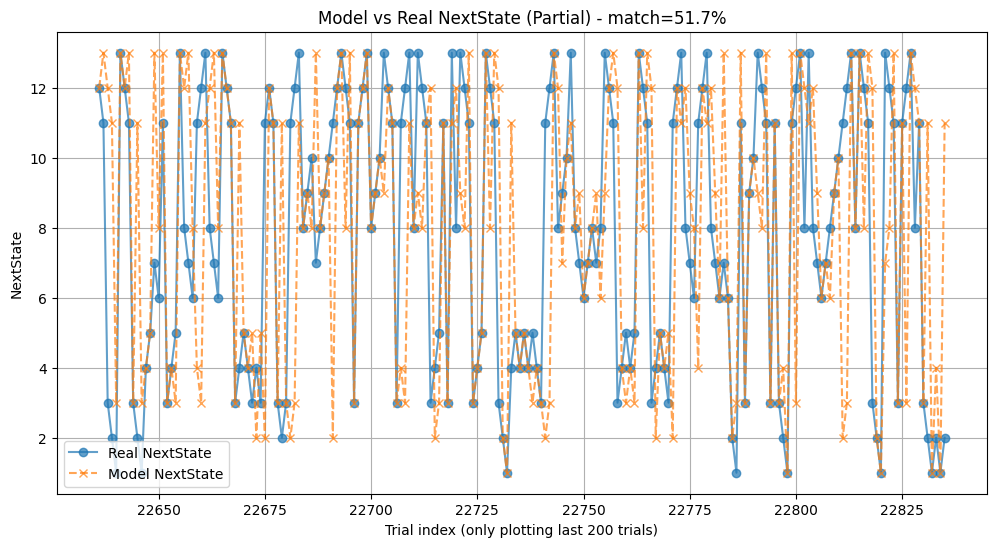

Final Q dictionary:
 State 1 -> Q-values:
    to 2: 0.20
 State 2 -> Q-values:
    to 1: 1.00
    to 3: 0.20
 State 3 -> Q-values:
    to 2: 0.20
    to 4: 0.20
    to 11: 0.20
 State 4 -> Q-values:
    to 3: 0.20
    to 5: 0.20
 State 5 -> Q-values:
    to 4: 0.20
 State 6 -> Q-values:
    to 7: 0.20
 State 7 -> Q-values:
    to 6: 0.24
    to 8: 0.20
 State 8 -> Q-values:
    to 7: 0.20
    to 9: 0.20
    to 13: 0.20
 State 9 -> Q-values:
    to 8: 0.20
    to 10: 1.00
 State 10 -> Q-values:
    to 9: 0.20
 State 11 -> Q-values:
    to 3: 0.23
    to 12: 0.20
 State 12 -> Q-values:
    to 11: 0.20
    to 13: 0.20
 State 13 -> Q-values:
    to 8: 0.23
    to 12: 0.20


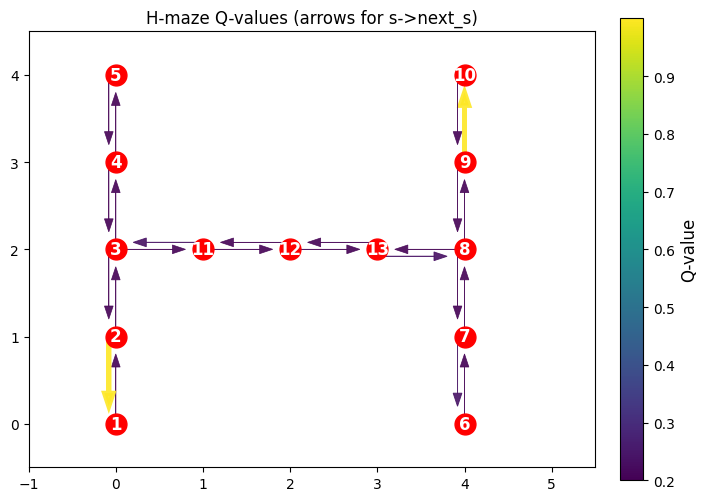

Done!


In [ ]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(1234)


class HMazeEnvironment:
    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self.build_transitions()
        self.legal_next_states = self.build_legal_next_states()

    def build_transitions(self):
        transitions = {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11, 2: 3,   3: 12},
            12: {0: 12, 1: 12, 2: 11,  3: 13},
            13: {0: 13, 1: 13, 2: 12,  3: 8}
        }
        return transitions

    def build_legal_next_states(self):
        legal_dict = {}
        for s in self.states:
            possible_next = set(self.transitions[s].values())
            if s in possible_next:
                possible_next.remove(s)
            legal_dict[s] = sorted(list(possible_next))

        print("legal_next_states:", legal_dict)  
        return legal_dict

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state


def initialize_Q_dict(env):
    Q = {}
    for s in env.states:
        Q[s] = {}
        for nx in env.legal_next_states[s]:
            Q[s][nx] = 0.0
    return Q

def softmax(Q_values, beta):
    shifted = Q_values - np.max(Q_values)
    exp_vals = np.exp(beta * shifted)
    return exp_vals / (exp_vals.sum() + 1e-12)

def prepare_observed_data(env, df):
    observed_data = []
    for _, row in df.iterrows():
        cst = row['CurrentState']
        cho = row['ChosenState']
        gst = row['Goal']
        sdate = row.get('session_date','unknown')
        epid  = row.get('TotalEpisodeNum', None)
        tidx  = row.get('TrialNum', None)

        observed_data.append({
            'SessionDate': sdate,
            'EpisodeID':   epid,
            'TrialIndex':  tidx,
            'CurrentState': cst,
            'ChosenState': cho, 
            'GoalState':    gst
        })
    return observed_data

def log_likelihood(params, observed_data, env, reset_q_each_episode=False):
    alpha, gamma, log_beta = params
    beta = np.exp(log_beta)

    Q = initialize_Q_dict(env)
    neg_log_lik = 0.0

    sorted_data = sorted(
        observed_data,
        key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex'])
    )

    current_episode = None

    for i in range(len(sorted_data)):
        tr = sorted_data[i]
        ep_id = tr['EpisodeID']
        st    = tr['CurrentState']
        cho   = tr['ChosenState']  
        gst   = tr['GoalState']

        if reset_q_each_episode and (ep_id != current_episode):
            Q = initialize_Q_dict(env)
            current_episode = ep_id

        legal_nexts = list(Q[st].keys()) 

        qvals = np.array([Q[st][nx] for nx in legal_nexts])
        probs = softmax(qvals, beta)
        chosen_idx = legal_nexts.index(cho)
        chosen_prob = probs[chosen_idx]

        neg_log_lik -= np.log(chosen_prob + 1e-12)

        nxt_st = env.get_next_state(st, cho)
        reward = 1 if (nxt_st == gst) else 0.2

        if i < len(sorted_data) - 1:
            nxt_tr = sorted_data[i+1]
            if nxt_tr['EpisodeID'] == ep_id: 
                nxt_s  = nxt_tr['CurrentState']
                nxt_a  = nxt_tr['ChosenState']  
                Q[st][cho] += alpha * (
                    reward + gamma * Q[nxt_st].get(nxt_a, 0.0) - Q[st][cho]
                )
            else: 
                Q[st][cho] += alpha * (reward - Q[st][cho])
        else:
            
            Q[st][cho] += alpha * (reward - Q[st][cho])

    return neg_log_lik

def fit_sarsa_parameters_with_tracking(observed_data, env, reset_q_each_episode=False):
    from scipy.optimize import minimize

    init_params = [0.1, 0.9, np.log(1.0)]
    bounds = [(0,1),(0,1),(np.log(0.1), np.log(10))]

    param_history = [init_params.copy()]
    init_ll = -log_likelihood(init_params, observed_data, env, reset_q_each_episode)
    likelihood_history=[init_ll]

    def callback(p):
        pp = p.copy()
        param_history.append(pp)
        ll = -log_likelihood(pp, observed_data, env, reset_q_each_episode)
        likelihood_history.append(ll)

    res = minimize(
        lambda p: log_likelihood(p, observed_data, env, reset_q_each_episode),
        init_params,
        method='L-BFGS-B',
        bounds=bounds,
        callback=callback,
        options={'maxiter':200,'disp':True}
    )

    best_params = res.x
    return best_params, param_history, likelihood_history

def simulate_actions_with_sarsa(env, observed_data, alpha, gamma, beta, reset_q_each_episode=False):
    Q = initialize_Q_dict(env)
    sorted_data = sorted(observed_data, key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex']))
    sim_actions = []
    current_episode = None

    for i in range(len(sorted_data)):
        tr = sorted_data[i]
        ep_id = tr['EpisodeID']
        st    = tr['CurrentState']
        gst   = tr['GoalState']

        if reset_q_each_episode and (ep_id != current_episode):
            Q = initialize_Q_dict(env)
            current_episode = ep_id

        legal_nexts = list(Q[st].keys())
        if len(legal_nexts) == 0:
            sim_actions.append(st)
            continue

        qvals = np.array([Q[st][nx] for nx in legal_nexts])
        probs = softmax(qvals, beta)
        chosen_idx = np.random.choice(len(legal_nexts), p=probs)
        chosen_next_st = legal_nexts[chosen_idx]
        sim_actions.append(chosen_next_st)

        nxt_st = env.get_next_state(st, chosen_next_st)
        reward = 1 if (nxt_st == gst) else 0.2

        if (i < len(sorted_data) - 1) and (sorted_data[i+1]['EpisodeID'] == ep_id):
            nxt_s = nxt_st
            nxt_legal = list(Q[nxt_s].keys())
            if len(nxt_legal) > 0:
                nxt_qvals = np.array([Q[nxt_s][nx2] for nx2 in nxt_legal])
                nxt_probs = softmax(nxt_qvals, beta)
                nxt_a_idx = np.random.choice(len(nxt_legal), p=nxt_probs)
                nxt_a_sim = nxt_legal[nxt_a_idx]

                Q[st][chosen_next_st] += alpha * (
                    reward + gamma * Q[nxt_s][nxt_a_sim] - Q[st][chosen_next_st]
                )
            else:
                Q[st][chosen_next_st] += alpha * (reward - Q[st][chosen_next_st])
        else:
            Q[st][chosen_next_st] += alpha * (reward - Q[st][chosen_next_st])

    return sim_actions, Q


def plot_hmaze_Q_arrows(Q, env):
    coords = {
        1:(0,0),  2:(0,1),  3:(0,2),  4:(0,3),  5:(0,4),
        6:(4,0),  7:(4,1),  8:(4,2),  9:(4,3),  10:(4,4),
        11:(1,2), 12:(2,2), 13:(3,2)
    }

    plt.figure(figsize=(8,6))
    plt.title("H-maze Q-values (arrows for s->next_s)")

    all_q_vals = []
    for s in Q:
        for nx in Q[s]:
            all_q_vals.append(Q[s][nx])
    if len(all_q_vals) == 0:
        print("No Q values to plot!")
        return
    
    Q_min, Q_max = min(all_q_vals), max(all_q_vals)
    if Q_min == Q_max:
        Q_min -= 0.01
        Q_max += 0.01
    eps = 1e-12

    cmap = plt.cm.viridis
    norm = mpl.colors.Normalize(vmin=Q_min, vmax=Q_max)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  

    for s in env.states:
        if s in coords:
            sx, sy = coords[s]
            plt.plot(sx, sy, 'ro', markersize=15, zorder=3)  
            plt.text(sx, sy, f"{s}", ha='center', va='center',
                     fontsize=12, color="white", fontweight='bold', zorder=4)

    drawn_edges = set()
    offset_factor = 0.08 
    for s in env.states:
        if s not in coords:
            continue
        sx, sy = coords[s]
        if s not in Q:
            continue

        for nx, q_val in Q[s].items():
            if nx not in coords:
                continue
            nx_x, nx_y = coords[nx]
            dx = nx_x - sx
            dy = nx_y - sy

            norm_val = (q_val - Q_min) / (Q_max - Q_min + eps)
            lw = 0.5 + 3.0 * norm_val 
            color = cmap(norm_val)

            edge_key_1 = f"{s}->{nx}"
            edge_key_2 = f"{nx}->{s}"
            if edge_key_2 in drawn_edges:
                perp_x =  dy
                perp_y = -dx
                norm_len = np.sqrt(perp_x**2 + perp_y**2) + eps
                perp_x /= norm_len
                perp_y /= norm_len
                perp_x *= offset_factor
                perp_y *= offset_factor

                sx_off = sx + perp_x
                sy_off = sy + perp_y

                plt.arrow(
                    sx_off, sy_off, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            else:
                plt.arrow(
                    sx, sy, dx*0.8, dy*0.8,
                    head_width=0.1,
                    length_includes_head=True,
                    color=color,
                    linewidth=lw,
                    alpha=0.9
                )
            drawn_edges.add(edge_key_1)

    plt.gca().set_aspect('equal', 'box')
    plt.xlim(-1, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.grid(False)

    cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label("Q-value", fontsize=12)

    plt.show()

def simulate_dataset_for_recovery(env, original_data, alpha, gamma, beta, reset_q_each_episode=False):
    Q = initialize_Q_dict(env)
    sorted_data = sorted(original_data, key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex']))
    simulated_data = []
    current_episode = None

    for i, tr in enumerate(sorted_data):
        ep_id = tr['EpisodeID']
        st = tr['CurrentState']
        gst = tr['GoalState']
        sdate = tr['SessionDate']
        tidx = tr['TrialIndex']

        if reset_q_each_episode and (ep_id != current_episode):
            Q = initialize_Q_dict(env)
            current_episode = ep_id

        legal_nexts = list(Q[st].keys())
        if len(legal_nexts) == 0:
            chosen_next_st = st  
        else:
            qvals = np.array([Q[st][nx] for nx in legal_nexts])
            probs = softmax(qvals, beta)
            chosen_idx = np.random.choice(len(legal_nexts), p=probs)
            chosen_next_st = legal_nexts[chosen_idx]

        simulated_data.append({
            'SessionDate':  sdate,
            'EpisodeID':    ep_id,
            'TrialIndex':   tidx,
            'CurrentState': st,
            'ChosenState':  chosen_next_st,
            'GoalState':    gst
        })

        nxt_st = env.get_next_state(st, chosen_next_st)
        reward = 1.0 if (nxt_st == gst) else 0.2

        if (i < len(sorted_data) - 1) and (sorted_data[i+1]['EpisodeID'] == ep_id):
            nxt_s = nxt_st
            nxt_legal = list(Q[nxt_s].keys())
            if len(nxt_legal) > 0:
                nxt_qvals = np.array([Q[nxt_s][nx2] for nx2 in nxt_legal])
                nxt_probs = softmax(nxt_qvals, beta)
                nxt_a_idx = np.random.choice(len(nxt_legal), p=nxt_probs)
                nxt_a_sim = nxt_legal[nxt_a_idx]

                Q[st][chosen_next_st] += alpha * (
                    reward + gamma * Q[nxt_s][nxt_a_sim] - Q[st][chosen_next_st]
                )
            else:
                Q[st][chosen_next_st] += alpha * (reward - Q[st][chosen_next_st])
        else:
            Q[st][chosen_next_st] += alpha * (reward - Q[st][chosen_next_st])

    return simulated_data


if __name__ == "__main__":
    env = HMazeEnvironment()

    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/beh/"
    files = [f for f in os.listdir(data_path) if f.endswith(".txt")]

    dfs=[]
    for fn in files:
        fpath = os.path.join(data_path, fn)
        df = pd.read_csv(fpath, delimiter=',')
        try:
            sdate = "_".join(fn.split('_')[1:4])
        except:
            sdate= "unknown"
        df['session_date']= sdate
        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True)
    all_df = all_df.sort_values(by=['session_date','TotalEpisodeNum','TrialNum']).reset_index(drop=True)

    all_df = all_df[ all_df['Choice'] != -1 ]

    observed_data = prepare_observed_data(env, all_df)

    ep_counts = Counter((d['GoalState'], d['SessionDate'], d['EpisodeID']) for d in observed_data)
    for k, c in ep_counts.items():
        if c>20:
            print("Warning: Episode", k, "has", c, "trials! Possibly abnormal data?")

    best_params, param_history, likelihood_history = fit_sarsa_parameters_with_tracking(
        observed_data, env, reset_q_each_episode=False
    )
    alpha_est, gamma_est, log_beta_est = best_params
    beta_est = np.exp(log_beta_est)

    print("\n==== Final MLE from Real Data ====")
    print(f"alpha={alpha_est:.5f}, gamma={gamma_est:.5f}, beta={beta_est:.5f}")

    alpha_vals = [p[0] for p in param_history]
    gamma_vals = [p[1] for p in param_history]
    beta_vals  = [np.exp(p[2]) for p in param_history]

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(alpha_vals, label='Alpha')
    plt.plot(gamma_vals, label='Gamma')
    plt.plot(beta_vals,  label='Beta')
    plt.xlabel("Iteration (including initial=0)")
    plt.ylabel("Value")
    plt.title("Parameter Evolution")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(likelihood_history, label='(Negative) Log-likelihood')
    plt.xlabel("Iteration (including initial=0)")
    plt.ylabel("Neg Log-likelihood")
    plt.title("Neg Log-likelihood Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    simulated_data = simulate_dataset_for_recovery(
        env, observed_data, alpha_est, gamma_est, beta_est, reset_q_each_episode=False
    )

    recovered_params, rec_param_history, rec_likelihood_history = fit_sarsa_parameters_with_tracking(
        simulated_data, env, reset_q_each_episode=False
    )
    alpha_rec, gamma_rec, log_beta_rec = recovered_params
    beta_rec = np.exp(log_beta_rec)

    print("\n======== Model Recovery Results ========")
    print("Ground Truth (used for simulation):")
    print(f"  alpha={alpha_est:.5f}, gamma={gamma_est:.5f}, beta={beta_est:.5f}")
    print("Recovered by fitting on simulated data:")
    print(f"  alpha={alpha_rec:.5f}, gamma={gamma_rec:.5f}, beta={beta_rec:.5f}")
    print("=========================================")

    sim_actions, final_Q = simulate_actions_with_sarsa(
        env, observed_data, alpha_est, gamma_est, beta_est, reset_q_each_episode=False
    )

    sorted_data = sorted(
        observed_data,
        key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex'])
    )
    real_actions = [d['ChosenState'] for d in sorted_data]
    match_count = sum(int(r == s) for r, s in zip(real_actions, sim_actions))
    match_ratio = match_count / len(real_actions)
    print(f"\nModel vs Real 'NextState' match ratio (overall): {match_ratio:.1%}")

    num_2_match = 0
    num_2_total = 0
    num_3_match = 0
    num_3_total = 0

    for i, (rd, model_act) in enumerate(zip(sorted_data, sim_actions)):
        st = rd['CurrentState']
        real_act = rd['ChosenState']
        choice_count = len(env.legal_next_states[st])

        if choice_count == 2:
            num_2_total += 1
            if real_act == model_act:
                num_2_match += 1
        elif choice_count == 3:
            num_3_total += 1
            if real_act == model_act:
                num_3_match += 1

    match_2_ratio = num_2_match / num_2_total if num_2_total > 0 else 0
    match_3_ratio = num_3_match / num_3_total if num_3_total > 0 else 0

    print(f"Match ratio for states with 2 choices: {match_2_ratio:.1%}   (n={num_2_total} trials)")
    print(f"Match ratio for states with 3 choices: {match_3_ratio:.1%}   (n={num_3_total} trials)")

    n = len(real_actions)
    num_to_plot = 200
    start_idx = max(0, n - num_to_plot)

    plt.figure(figsize=(12,6))
    plt.plot(range(start_idx,n), real_actions[start_idx:], 'o-', label='Real NextState', alpha=0.7)
    plt.plot(range(start_idx,n), sim_actions[start_idx:], 'x--', label='Model NextState', alpha=0.7)
    plt.xlabel(f"Trial index (only plotting last {num_to_plot} trials)")
    plt.ylabel("NextState")
    plt.title(f"Model vs Real NextState (Partial) - match={match_ratio:.1%}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Final Q dictionary:")
    for s in sorted(final_Q.keys()):
        print(f" State {s} -> Q-values:")
        for nx, val in final_Q[s].items():
            print(f"    to {nx}: {val:.2f}")

    plot_hmaze_Q_arrows(final_Q, env)

    print("Done!")





In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from collections import Counter

#np.random.seed(1234)

class HMazeEnvironment:
    def __init__(self):
        self.states = np.arange(1,14)
        self.transitions = self.build_transitions()
        self.legal_next_states = self.build_legal_next_states()

    def build_transitions(self):
        transitions = {
            1:  {0:2,1:1,2:1,3:1},
            2:  {0:3,1:1,2:2,3:2},
            3:  {0:4,1:2,2:3,3:11},
            4:  {0:5,1:3,2:4,3:4},
            5:  {0:5,1:4,2:5,3:5},
            6:  {0:7,1:6,2:6,3:6},
            7:  {0:8,1:6,2:7,3:7},
            8:  {0:9,1:7,2:13,3:8},
            9:  {0:10,1:8,2:9,3:9},
            10: {0:10,1:9,2:10,3:10},
            11: {0:11,1:11,2:3,3:12},
            12: {0:12,1:12,2:11,3:13},
            13: {0:13,1:13,2:12,3:8},
        }
        return transitions

    def build_legal_next_states(self):
        legal = {}
        for s in self.states:
            nexts = set(self.transitions[s].values())
            if s in nexts:
                nexts.remove(s)
            legal[s] = sorted(list(nexts))
        return legal

def softmax(vals, beta):
    shift = vals - np.max(vals)
    exps = np.exp(beta * vals)
    return exps / (exps.sum() + 1e-12)

def find_num_targets(row):
    t1 = row['TargetOne']
    t2 = row['TargetTwo']
    t3 = row['TargetThree']

    if (t2 == 0) and (t3 == 0):
        return 1
    elif (t3 == 0):
        return 2
    else:
        return 3

def prepare_data(df):
    data=[]
    for _, row in df.iterrows():
        data.append({
            'SessionID': row.get('session_date', 0),  
            'EpisodeID': row['TotalEpisodeNum'],
            'TrialID'  : row['TrialNum'],
            'CurrentState': row['CurrentState'],
            'ChosenState' : row['ChosenState'],
            'GoalState'   : row['Goal'],
            'NumTargets'  : row['NumTargets']
        })
    return data

def td0_neglog(params, data, env):
    gamma, alpha, smallbeta, forget = params
    beta = smallbeta * 10

    Q = np.zeros(13, dtype=float)

    negLL=0.0

    data_sorted = sorted(data, key=lambda x: (x['SessionID'], x['EpisodeID'], x['TrialID']))

    #current_session = None
    current_episode = None
    current_goal = None
    length = 0

    for row in data_sorted:
        #ses = row['SessionID']
        epi = row['EpisodeID']
        st  = int(row['CurrentState'] - 1)
        ch  = int(row['ChosenState'] - 1)
        gl  = int(row['GoalState'] - 1)
        numtar = row['NumTargets']

        if numtar > 1:
            length += 1

        if epi != current_episode:
            #current_session = ses
            current_episode = epi
            current_goal = gl
            Q[gl] = 5.0

        next_states = env.legal_next_states[int(st+1)]  
        next_idx = [int(x-1) for x in next_states]
        subQ = [Q[i] for i in next_idx]
        probs = softmax(np.array(subQ), beta)
        negLL -= np.log(np.max([probs[next_idx.index(ch)], 1e-12]))

        r=-1.0
        delta = r + gamma*Q[ch] - Q[st]
        Q[st] = Q[st] + alpha*delta

        for i in range(13):
            if i != st:
                Q[i] = Q[i] * forget

        Q[gl] = 5.0

    return negLL/length


def fit_td0(data, env):
    init_param = [0.5, 0.5, 0.5, 0.9]
    bnds = [(0,1),(0,1),(0, 1),(0,1)]

    def obj_func(p):
        return td0_neglog(p, data, env)

    res = minimize(obj_func, init_param, bounds=bnds)
    return res

def simulate_td0(data, env, gamma, alpha, beta, forget):
    Q = np.zeros(13, dtype=float)
    data_sorted = sorted(data, key=lambda x: (x['SessionID'], x['EpisodeID'], x['TrialID']))
    sim_actions=[]

    #current_session=None
    current_episode=None
    current_goal=None

    for row in data_sorted:
        #ses = row['SessionID']
        epi = row['EpisodeID']
        st = int(row['CurrentState']-1)
        gl = int(row['GoalState']-1)

        #if (ses!=current_session) or (epi!=current_episode):
        if epi!=current_episode:
            #current_session=ses
            current_episode=epi
            current_goal=gl
            Q[gl] = 5.0

        # softmax
        next_states=env.legal_next_states[int(st+1)]
        next_idx = [int(x-1) for x in next_states]
        if len(next_idx)==0:
            sim_actions.append(st+1)
            continue

        subQ=[Q[i] for i in next_idx]
        probs=softmax(np.array(subQ), beta)
        pick = np.random.choice(len(next_idx), p=probs)
        chosen_next = next_idx[pick]
        sim_actions.append(chosen_next+1)

        # TD(0) update
        r=-1.0
        delta = r + gamma*Q[chosen_next] - Q[st]
        Q[st]+=alpha*delta
        for i in range(13):
            if i!=st:
                Q[i]*= forget
        Q[gl] = 5.0

    return sim_actions, Q

if __name__ == "__main__":
    env = HMazeEnvironment()

    data_path = "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    files = [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]
    dfs = []
    for fn in files:
        fpath = os.path.join(data_path, fn)
        df = pd.read_csv(fpath, delimiter=',')
        df['NumTargets'] = df.apply(find_num_targets, axis=1)
        try:
            sdate = "_".join(fn.split('_')[1:4])
        except:
            sdate= "unknown"
        df['session_date']= sdate
        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True)
    #all_df = all_df.sort_values(by=['session_date','TotalEpisodeNum','TrialNum']).reset_index(drop=True)

    all_df = all_df[(all_df['Choice']>-1) & (all_df['Control']==0)]
    #all_df = all_df[all_df['session_date']== "2024_08_06"]
    data = prepare_data(all_df)

    result= fit_td0(data, env)
    best = result.x
    gamma_est, alpha_est, smallbeta_est, forget_est = best
    beta_est = smallbeta_est * 10
    print("Best param: gamma=%.4f, alpha=%.4f, beta=%.4f, forget=%.4f"%(gamma_est, alpha_est, beta_est, forget_est))
    print("NegLL= %.4f"% result.fun)

    sim_actions, Q = simulate_td0(data, env, gamma_est, alpha_est, beta_est, forget_est)
    data_sorted = sorted(data, key=lambda x: (x['SessionID'], x['EpisodeID'], x['TrialID']))
    real_actions = [d['ChosenState'] for d in data_sorted]
    match_count = sum(int(r==s) for r,s in zip(real_actions, sim_actions))
    ratio = match_count/len(real_actions)
    print("Match ratio= %.1f%%"%(ratio*100))
    print("Final Q:", Q)





Best param: gamma=0.1619, alpha=1.0000, beta=1.5566, forget=0.0634
NegLL= 0.5331
Match ratio= 68.6%
Final Q: [ 3.16788042e-01 -1.20548722e-02 -1.00000000e+00 -8.82914231e-46
  2.32019607e-44  5.00000000e+00 -4.83905057e-05 -1.61137424e-05
 -1.94248517e-07  5.10462544e-06 -6.60811294e-14 -1.04228855e-12
 -1.91150379e-11]


## V4: Successfully Implemented Model-Based + Softmax + Model Fitting

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88932D+03    |proj g|=  2.30259D+00

At iterate    1    f=  5.46963D+03    |proj g|=  1.41998D+00

At iterate    2    f=  5.20533D+03    |proj g|=  1.20149D+00



 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    3    f=  5.17042D+03    |proj g|=  1.13044D+00

At iterate    4    f=  5.13352D+03    |proj g|=  1.06179D+00

At iterate    5    f=  5.09015D+03    |proj g|=  3.73610D+00

At iterate    6    f=  5.09004D+03    |proj g|=  8.75705D-01

At iterate    7    f=  5.09004D+03    |proj g|=  7.51243D-02

At iterate    8    f=  5.09004D+03    |proj g|=  6.18456D-02

===== Final MLE (Pure Model-Based) =====
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     13     12     0     0   6.185D-02   5.090D+03
  F =   5090.0404846175634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

gamma_mb=

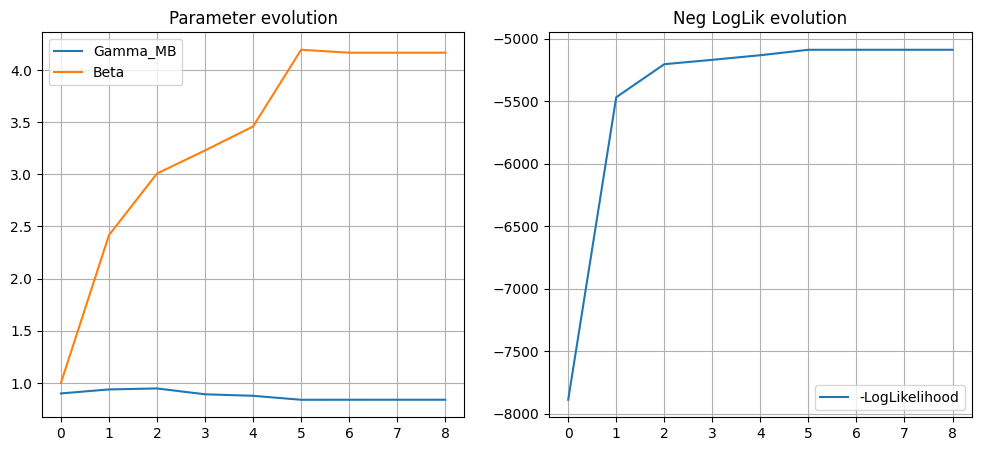

Model vs Real nextState match ratio: 79.5%
Match ratio for states with 2 choices: 82.1%   (n=9706 trials)
Match ratio for states with 3 choices: 72.5%   (n=3991 trials)
Final MB Q dictionary (last episode's Q_mb):
 State 1 -> Q-values:
    to 2: 2.85
 State 2 -> Q-values:
    to 1: 2.60
    to 3: 3.16
 State 3 -> Q-values:
    to 2: 2.85
    to 4: 3.52
    to 11: 2.85
 State 4 -> Q-values:
    to 3: 3.16
    to 5: 3.96
 State 5 -> Q-values:
    to 4: 3.52
 State 6 -> Q-values:
    to 7: 2.05
 State 7 -> Q-values:
    to 6: 1.92
    to 8: 2.20
 State 8 -> Q-values:
    to 7: 2.05
    to 9: 2.05
    to 13: 2.38
 State 9 -> Q-values:
    to 8: 2.20
    to 10: 1.92
 State 10 -> Q-values:
    to 9: 2.05
 State 11 -> Q-values:
    to 3: 3.16
    to 12: 2.60
 State 12 -> Q-values:
    to 11: 2.85
    to 13: 2.38
 State 13 -> Q-values:
    to 8: 2.20
    to 12: 2.60


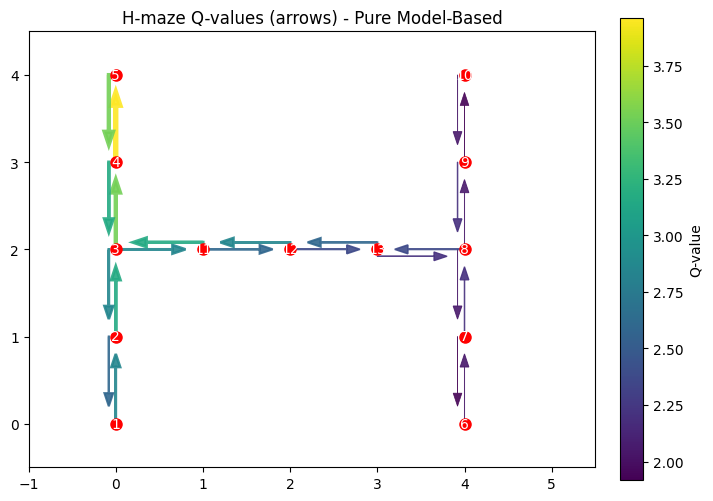

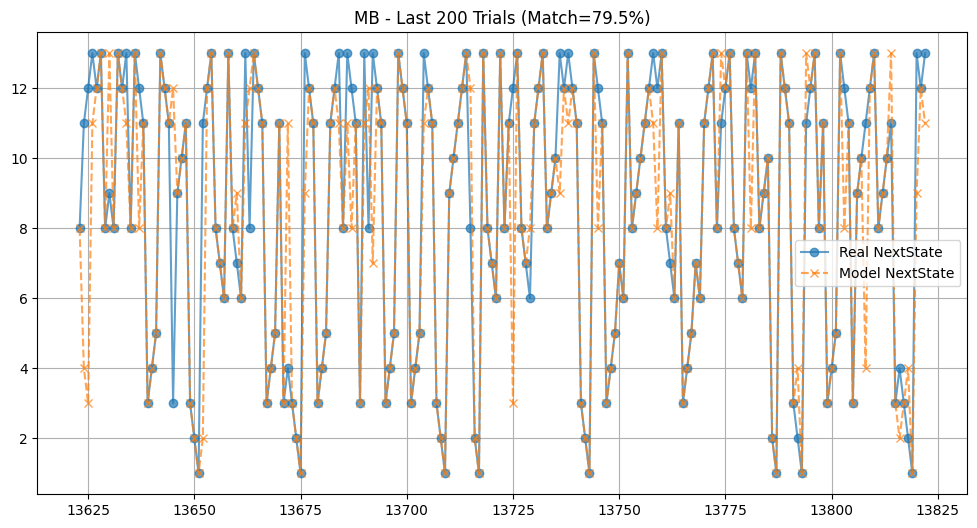

Done!


In [ ]:
np.random.seed(1234)

class HMazeEnvironment:
    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self.build_transitions()
        self.legal_next_states = self.build_legal_next_states()

    def build_transitions(self):
        transitions = {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11, 2: 3,   3: 12},
            12: {0: 12, 1: 12, 2: 11,  3: 13},
            13: {0: 13, 1: 13, 2: 12,  3: 8}
        }
        return transitions

    def build_legal_next_states(self):
        legal_dict = {}
        for s in self.states:
            possible_next = set(self.transitions[s].values())
            if s in possible_next:
                possible_next.remove(s)
            legal_dict[s] = sorted(list(possible_next))
        return legal_dict

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state

# ============================
# MB Q-values
# ============================
def compute_MB_values(env, goal, gamma_mb=1.0, reward_if_goal=1.0, reward_else=0.2):
    V_mb = {s: 0.0 for s in env.states}
    Q_mb = {s: {} for s in env.states}
    for _ in range(100):
        delta = 0.0
        for s in env.states:
            best_val = -999999
            for nx in env.legal_next_states[s]:
                r = reward_if_goal if nx==goal else reward_else
                val = r + gamma_mb*V_mb[nx]
                if val>best_val:
                    best_val= val
                Q_mb[s][nx] = val
            old_v = V_mb[s]
            V_mb[s]= best_val
            delta = max(delta, abs(old_v - best_val))
        if delta<1e-8:
            break
    return Q_mb, V_mb

# ============================
# Softmax
# ============================
def softmax(qvals, beta):
    shifted = qvals - np.max(qvals)
    exps = np.exp(beta * shifted)
    return exps / (exps.sum() + 1e-12)

def prepare_observed_data(env, df):
    observed_data = []
    for _, row in df.iterrows():
        cst = row['CurrentState']
        cho = row['ChosenState']
        gst = row['Goal']
        sdate= row.get('session_date','unknown')
        epid = row.get('TotalEpisodeNum', None)
        tidx = row.get('TrialNum', None)
        observed_data.append({
            'SessionDate': sdate,
            'EpisodeID':   epid,
            'TrialIndex':  tidx,
            'CurrentState': cst,
            'ChosenState': cho,
            'GoalState':    gst
        })
    return observed_data

# ============================
# -log_likelihood_mb
# ============================
def log_likelihood_mb(params, observed_data, env,
                      reset_q_each_episode=False):
    gamma_mb, log_beta= params
    beta = np.exp(log_beta)

    neg_log_lik=0.0
    sorted_data= sorted(observed_data,
        key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex'])
    )

    current_episode=None
    current_goal=None
    Q_mb=None

    for i, tr in enumerate(sorted_data):
        ep_id= tr['EpisodeID']
        st = tr['CurrentState']
        cho = tr['ChosenState']
        gst = tr['GoalState']

        if reset_q_each_episode and (ep_id!= current_episode):
            current_episode=ep_id
            current_goal= gst
            Q_mb, _= compute_MB_values(env, goal=current_goal,
                                       gamma_mb=gamma_mb,
                                       reward_if_goal=1.0,
                                       reward_else=0.2)
        elif ep_id!= current_episode:
            current_episode= ep_id
            current_goal= gst
            Q_mb, _= compute_MB_values(env, goal= current_goal,
                                       gamma_mb=gamma_mb)

        if Q_mb is None:
            Q_mb, _= compute_MB_values(env, goal=gst,
                                       gamma_mb=gamma_mb)

        legal_nexts= env.legal_next_states[st]
        if cho not in legal_nexts:
            neg_log_lik += 999999
            continue

        qvals= [Q_mb[st][nx] for nx in legal_nexts]
        probs= softmax(np.array(qvals), beta)
        chosen_idx= legal_nexts.index(cho)
        neg_log_lik -= np.log(probs[chosen_idx]+1e-12)

    return neg_log_lik

# ============================
# Fit
# ============================
def fit_mb_parameters_with_tracking(observed_data, env,
                                    reset_q_each_episode=False):
    init_params= [0.9, np.log(1.0)]
    bounds= [
       (0.0, 1.0),  
       (np.log(0.1), np.log(10)) 
    ]

    param_hist=[]
    ll_hist=[]

    def callback_f(p):
        ll= -log_likelihood_mb(p, observed_data, env, reset_q_each_episode)
        param_hist.append(p.copy())
        ll_hist.append(ll)

    init_ll= -log_likelihood_mb(init_params, observed_data, env, reset_q_each_episode)
    param_hist.append(init_params.copy())
    ll_hist.append(init_ll)

    res= minimize(
        lambda p: log_likelihood_mb(p, observed_data, env, reset_q_each_episode),
        init_params,
        method='L-BFGS-B',
        bounds=bounds,
        callback= callback_f,
        options= {'maxiter':200, 'disp':True}
    )

    best_params= res.x
    return best_params, param_hist, ll_hist

# ============================
# Simulation
# ============================
def simulate_actions_with_mb(env, observed_data, gamma_mb, beta,
                             reset_q_each_episode=False):
    sorted_data= sorted(observed_data,
        key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex'])
    )
    sim_actions=[]
    current_episode=None
    current_goal=None
    Q_mb=None

    final_Q_mb=None  

    for i, tr in enumerate(sorted_data):
        ep_id=tr['EpisodeID']
        st   =tr['CurrentState']
        gst  =tr['GoalState']

        if reset_q_each_episode and (ep_id!=current_episode):
            current_episode= ep_id
            current_goal= gst
            Q_mb, _= compute_MB_values(env, goal=gst, gamma_mb=gamma_mb)
        elif ep_id!= current_episode:
            current_episode= ep_id
            current_goal= gst
            Q_mb, _= compute_MB_values(env, goal=gst, gamma_mb=gamma_mb)
        if Q_mb is None:
            Q_mb, _= compute_MB_values(env, goal=gst, gamma_mb=gamma_mb)

        final_Q_mb= Q_mb  

        legal_nexts= env.legal_next_states[st]
        if len(legal_nexts)==0:
            sim_actions.append(st)
            continue

        qvals_mb= [Q_mb[st][nx] for nx in legal_nexts]
        probs= softmax(np.array(qvals_mb), beta)
        chosen_idx= np.random.choice(len(legal_nexts), p=probs)
        chosen_next_st= legal_nexts[chosen_idx]
        sim_actions.append(chosen_next_st)

    return sim_actions, final_Q_mb


def plot_hmaze_Q_arrows(Q, env):
    coords = {
        1:(0,0),  2:(0,1),  3:(0,2),  4:(0,3),  5:(0,4),
        6:(4,0),  7:(4,1),  8:(4,2),  9:(4,3), 10:(4,4),
        11:(1,2), 12:(2,2), 13:(3,2)
    }
    plt.figure(figsize=(8,6))
    plt.title("H-maze Q-values (arrows) - Pure Model-Based")

    all_q_vals=[]
    for s in Q:
        for nx in Q[s]:
            all_q_vals.append(Q[s][nx])
    if len(all_q_vals)==0:
        print("No Q values to plot.")
        return
    Q_min, Q_max = min(all_q_vals), max(all_q_vals)
    if Q_min==Q_max:
        Q_min-=0.01
        Q_max+=0.01
    norm = mpl.colors.Normalize(vmin=Q_min, vmax=Q_max)
    cmap= plt.cm.viridis
    sm= mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    for s in env.states:
        if s in coords:
            sx, sy= coords[s]
            plt.plot(sx, sy, 'ro', markersize=8, zorder=3)
            plt.text(sx, sy, f"{s}", ha='center', va='center', color='white', zorder=4)

    drawn_edges= set()
    offset_factor=0.08
    for s in env.states:
        if s not in coords:
            continue
        sx, sy= coords[s]
        if s not in Q:
            continue
        for nx, val in Q[s].items():
            if nx not in coords:
                continue
            nx_x, nx_y= coords[nx]
            dx= nx_x - sx
            dy= nx_y - sy
            val_norm= (val-Q_min)/(Q_max-Q_min+1e-12)
            lw= 0.5 + 3.0*val_norm
            color= cmap(val_norm)
            edge_key_1= f"{s}->{nx}"
            edge_key_2= f"{nx}->{s}"
            if edge_key_2 in drawn_edges:
                perp_x= dy
                perp_y=-dx
                l= np.sqrt(perp_x**2+perp_y**2)+1e-12
                perp_x/= l; perp_y/= l
                perp_x*= offset_factor; perp_y*= offset_factor
                sx_off= sx+ perp_x
                sy_off= sy+ perp_y
                plt.arrow(sx_off, sy_off, dx*0.8, dy*0.8,
                          head_width=0.1, length_includes_head=True,
                          linewidth=lw, color=color, alpha=0.9)
            else:
                plt.arrow(sx, sy, dx*0.8, dy*0.8,
                          head_width=0.1, length_includes_head=True,
                          linewidth=lw, color=color, alpha=0.9)
            drawn_edges.add(edge_key_1)

    plt.gca().set_aspect('equal','box')
    plt.xlim(-1,5.5)
    plt.ylim(-0.5,4.5)
    plt.colorbar(sm, ax=plt.gca(),
                 fraction=0.046, pad=0.04
                ).set_label("Q-value")
    plt.show()


# ============================
# we'll see
# ============================
if __name__=="__main__":
    env= HMazeEnvironment()

    data_path= "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    files= [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]
    dfs=[]
    for fn in files:
        fpath= os.path.join(data_path, fn)
        df= pd.read_csv(fpath, delimiter=',')
        try:
            sdate= "_".join(fn.split('_')[1:4])
        except:
            sdate= "unknown"
        df['session_date']= sdate
        dfs.append(df)
    all_df= pd.concat(dfs, ignore_index=True)
    all_df= all_df.sort_values(by=['session_date','TotalEpisodeNum','TrialNum']
                              ).reset_index(drop=True)

    all_df= all_df[ (all_df['Choice'] > -1 ) & (all_df['Control'] == 0) ]
    observed_data= prepare_observed_data(env, all_df)

    best_params, param_hist, ll_hist= fit_mb_parameters_with_tracking(
        observed_data, env,
        reset_q_each_episode=False
    )
    gamma_est, log_beta_est= best_params
    beta_est= np.exp(log_beta_est)

    print("\n===== Final MLE (Pure Model-Based) =====")
    print(f"gamma_mb= {gamma_est:.3f}, beta= {beta_est:.3f}")

    gamma_vals= [p[0] for p in param_hist]
    beta_vals= [np.exp(p[1]) for p in param_hist]
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(gamma_vals, label='Gamma_MB')
    plt.plot(beta_vals,  label='Beta')
    plt.legend()
    plt.grid(True)
    plt.title("Parameter evolution")

    plt.subplot(1,2,2)
    plt.plot(ll_hist, label='-LogLikelihood')
    plt.legend()
    plt.grid(True)
    plt.title("Neg LogLik evolution")
    plt.show()

    sim_actions, final_Q_mb= simulate_actions_with_mb(
        env, observed_data,
        gamma_est, beta_est,
        reset_q_each_episode=False
    )

    sorted_data= sorted(observed_data,
                        key=lambda x: (x['SessionDate'],
                                       x['EpisodeID'],
                                       x['TrialIndex']))
    real_actions= [d['ChosenState'] for d in sorted_data]
    match_count= sum(int(r==s) for r,s in zip(real_actions, sim_actions))
    match_ratio= match_count/ len(real_actions)
    print(f"Model vs Real nextState match ratio: {match_ratio:.1%}")

    num_2_match = 0
    num_2_total = 0
    num_3_match = 0
    num_3_total = 0

    for i, (rd, model_act) in enumerate(zip(sorted_data, sim_actions)):
        st = rd['CurrentState']
        real_act = rd['ChosenState']
        choice_count = len(env.legal_next_states[st])

        if choice_count == 2:
            num_2_total += 1
            if real_act == model_act:
                num_2_match += 1
        elif choice_count == 3:
            num_3_total += 1
            if real_act == model_act:
                num_3_match += 1

    match_2_ratio = num_2_match / num_2_total if num_2_total > 0 else 0
    match_3_ratio = num_3_match / num_3_total if num_3_total > 0 else 0

    print(f"Match ratio for states with 2 choices: {match_2_ratio:.1%}   (n={num_2_total} trials)")
    print(f"Match ratio for states with 3 choices: {match_3_ratio:.1%}   (n={num_3_total} trials)")

    # final_Q_mb is for the last episode
    if final_Q_mb is not None:
        print("Final MB Q dictionary (last episode's Q_mb):")
        for s in sorted(final_Q_mb.keys()):
            print(f" State {s} -> Q-values:")
            for nx, val in final_Q_mb[s].items():
                print(f"    to {nx}: {val:.2f}")

        plot_hmaze_Q_arrows(final_Q_mb, env)

    n= len(real_actions)
    num_plot=200
    start_i= max(0, n-num_plot)
    plt.figure(figsize=(12,6))
    plt.plot(range(start_i,n), real_actions[start_i:], 'o-', label='Real NextState', alpha=0.7)
    plt.plot(range(start_i,n), sim_actions[start_i:], 'x--', label='Model NextState', alpha=0.7)
    plt.legend()
    plt.title(f"MB - Last {num_plot} Trials (Match={match_ratio:.1%})")
    plt.grid(True)
    plt.show()

    print("Done!")


## V5: Hybrid Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41197D+03    |proj g|=  2.30259D+00

At iterate    1    f=  5.10753D+03    |proj g|=  9.58415D-01

At iterate    2    f=  5.07992D+03    |proj g|=  3.96409D+00

At iterate    3    f=  5.06845D+03    |proj g|=  7.10729D-01

At iterate    4    f=  5.05441D+03    |proj g|=  7.79572D-01

At iterate    5    f=  5.05325D+03    |proj g|=  7.92031D-01

At iterate    6    f=  5.05226D+03    |proj g|=  9.94895D-01

At iterate    7    f=  5.05037D+03    |proj g|=  3.87400D+00

At iterate    8    f=  5.04950D+03    |proj g|=  3.88596D+00

At iterate    9    f=  5.04824D+03    |proj g|=  7.70707D-01

At iterate   10    f=  5.04723D+03    |proj g|=  9.96135D-01

At iterate   11    f=  5.04320D+03    |proj g|=  9.96560D-01

At iterate   12    f=  5.03968D+03    |proj g|=  9.96484D-01

At iterate   13    f=  5.0

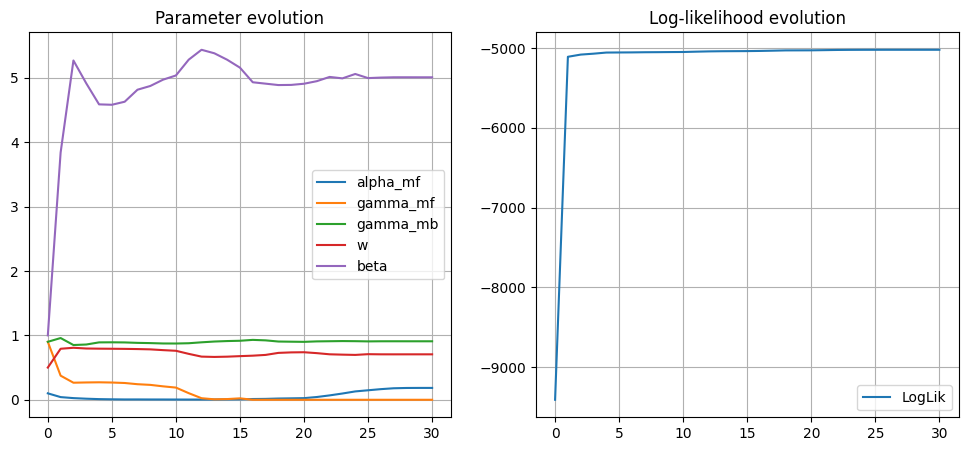

Hybrid vs real nextState match ratio: 79.6%
Match ratio for states with 2 choices: 81.9%   (n=9706 trials)
Match ratio for states with 3 choices: 73.2%   (n=3991 trials)


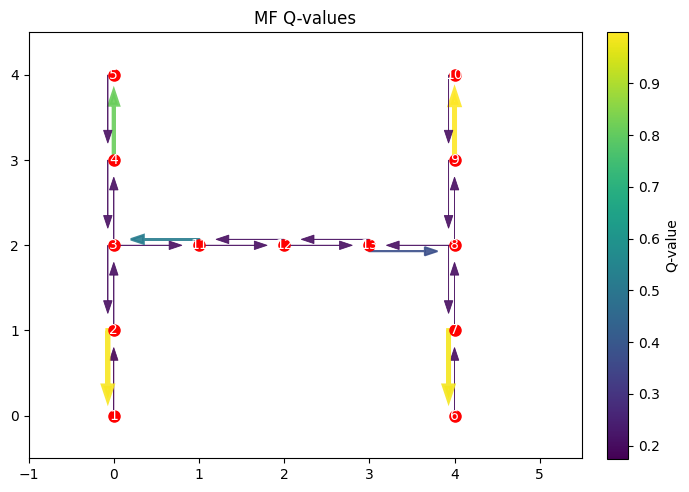

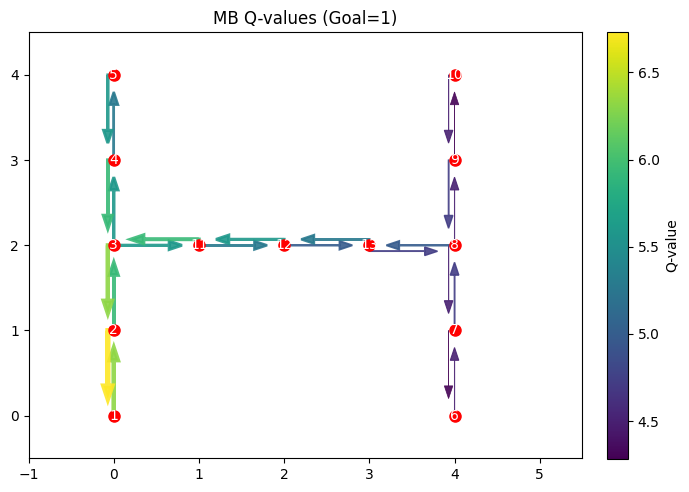

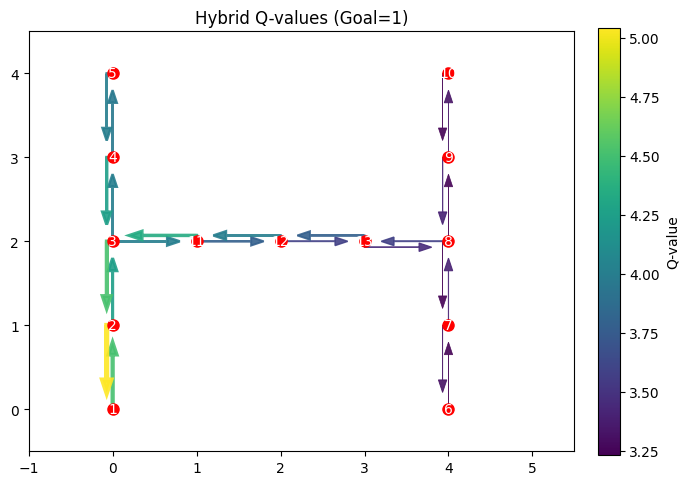

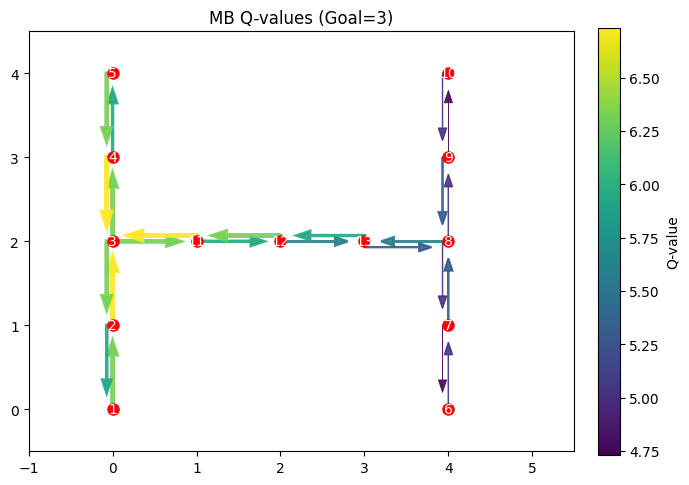

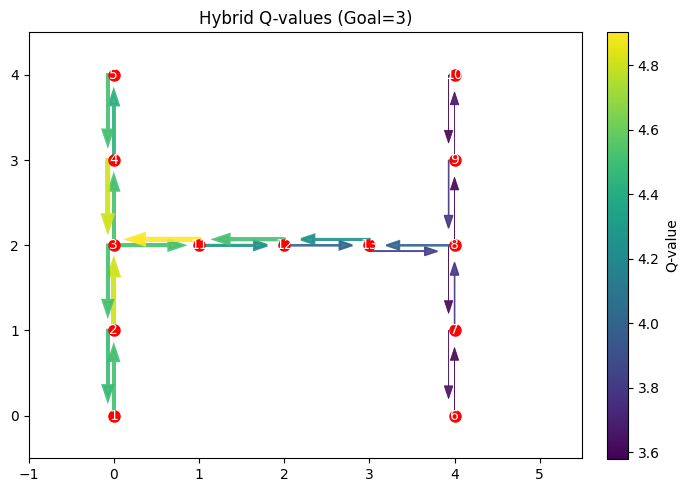

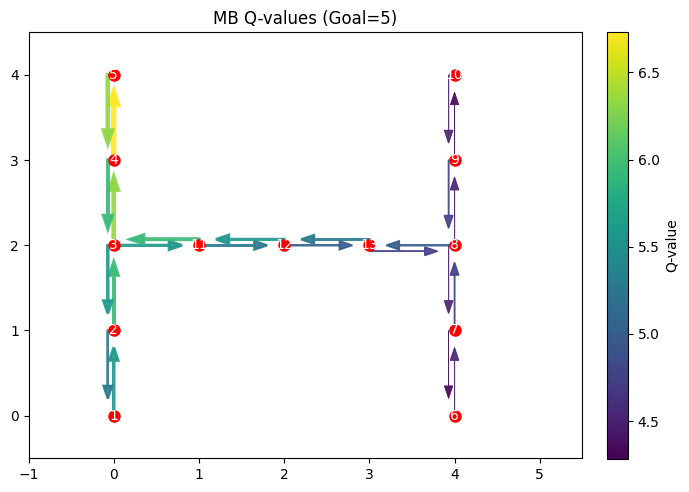

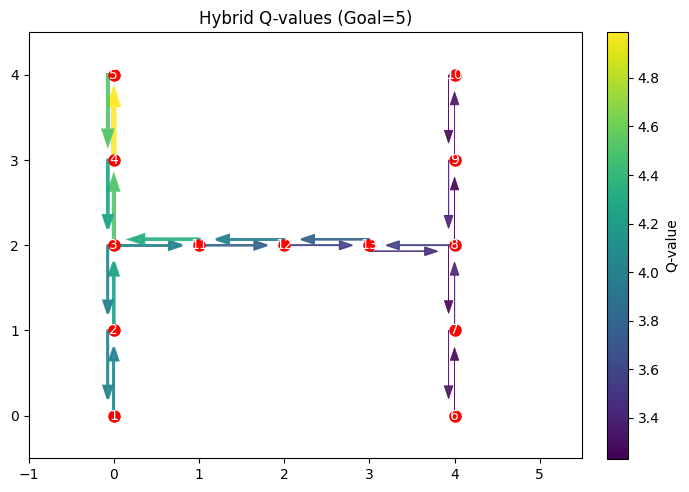

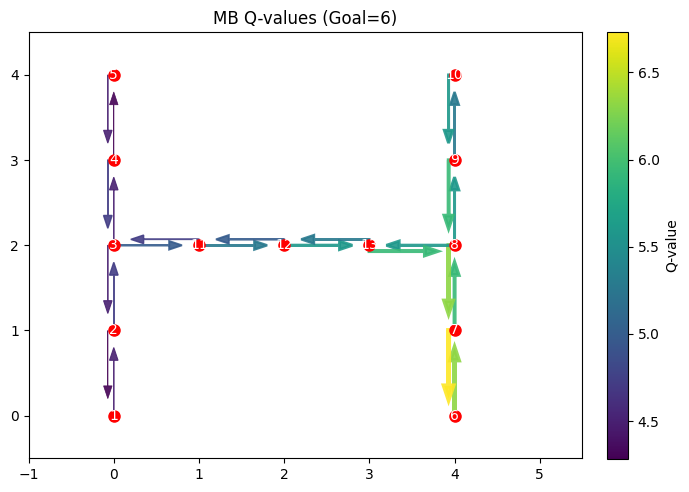

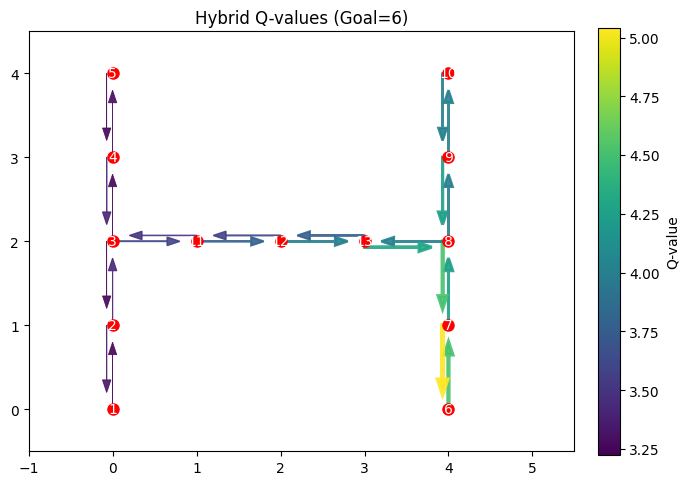

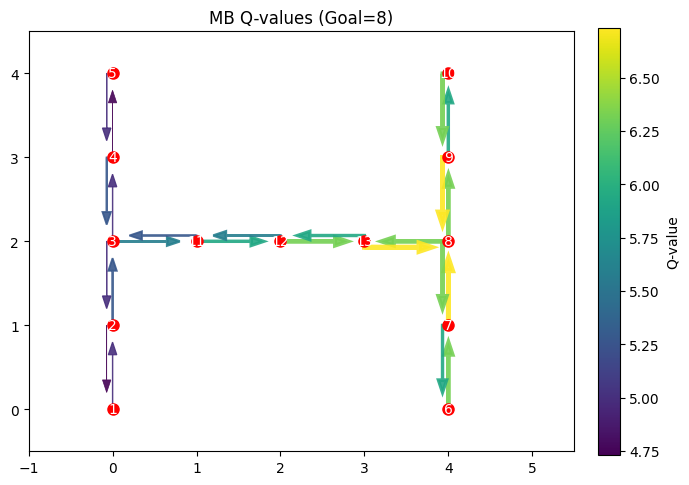

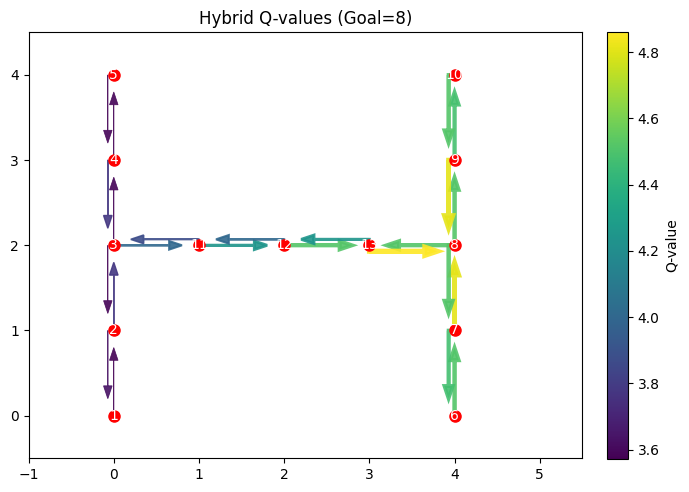

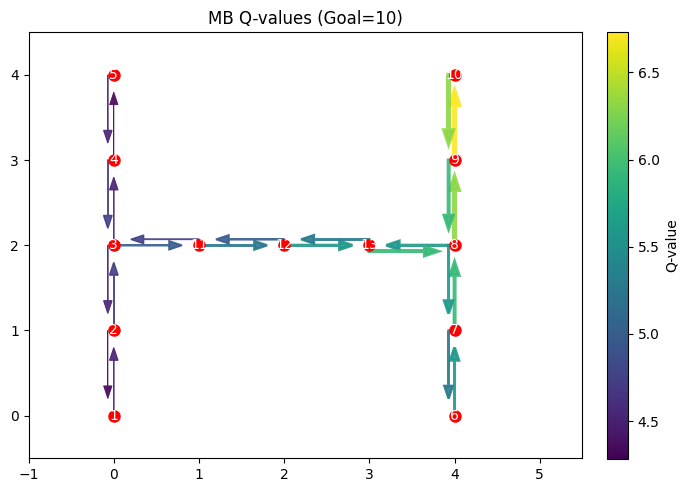

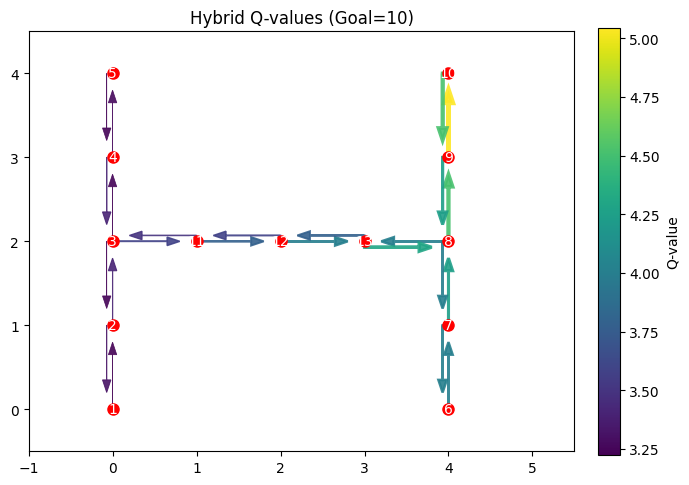

Done.


In [ ]:
np.random.seed(1234)

class HMazeEnvironment:
    def __init__(self):
        self.states = np.arange(1, 14)
        self.transitions = self.build_transitions()
        self.legal_next_states = self.build_legal_next_states()

    def build_transitions(self):
        transitions = {
            1:  {0: 2,  1: 1,  2: 1,   3: 1},
            2:  {0: 3,  1: 1,  2: 2,   3: 2},
            3:  {0: 4,  1: 2,  2: 3,   3: 11},
            4:  {0: 5,  1: 3,  2: 4,   3: 4},
            5:  {0: 5,  1: 4,  2: 5,   3: 5},
            6:  {0: 7,  1: 6,  2: 6,   3: 6},
            7:  {0: 8,  1: 6,  2: 7,   3: 7},
            8:  {0: 9,  1: 7,  2: 13,  3: 8},
            9:  {0: 10, 1: 8,  2: 9,   3: 9},
            10: {0: 10, 1: 9,  2: 10,  3: 10},
            11: {0: 11, 1: 11, 2: 3,   3: 12},
            12: {0: 12, 1: 12, 2: 11,  3: 13},
            13: {0: 13, 1: 13, 2: 12,  3: 8}
        }
        return transitions

    def build_legal_next_states(self):
        legal_dict = {}
        for s in self.states:
            possible_next = set(self.transitions[s].values())
            if s in possible_next:
                possible_next.remove(s)
            legal_dict[s] = sorted(list(possible_next))
        return legal_dict

    def get_next_state(self, current_state, chosen_next_state):
        return chosen_next_state


def initialize_Q_dict(env):
    Q = {}
    for s in env.states:
        Q[s] = {}
        for nx in env.legal_next_states[s]:
            Q[s][nx] = 0.0
    return Q


def compute_MB_values(env, goal, gamma_mb=1.0, reward_if_goal=1.0, reward_else=0.2, max_iter=100):
    V_mb = {s: 0.0 for s in env.states}
    Q_mb = {s: {} for s in env.states}

    for _ in range(max_iter):
        delta = 0.0
        for s in env.states:
            best_val = -999999
            for nx in env.legal_next_states[s]:
                r = reward_if_goal if (nx == goal) else reward_else
                val = r + gamma_mb * V_mb[nx]
                Q_mb[s][nx] = val
                if val > best_val:
                    best_val = val

            old_v = V_mb[s]
            V_mb[s] = best_val
            delta = max(delta, abs(old_v - best_val))

        if delta < 1e-8:
            break

    return Q_mb, V_mb


def softmax(qvals, beta):
    shifted = qvals - np.max(qvals)
    exp_vals = np.exp(beta * shifted)
    return exp_vals / (exp_vals.sum() + 1e-12)


def prepare_observed_data(env, df):
    observed_data = []
    for _, row in df.iterrows():
        cst = row['CurrentState']
        cho = row['ChosenState']
        gst = row['Goal']
        sdate= row.get('session_date','unknown')
        epid = row.get('TotalEpisodeNum', None)
        tidx = row.get('TrialNum', None)
        observed_data.append({
            'SessionDate': sdate,
            'EpisodeID':   epid,
            'TrialIndex':  tidx,
            'CurrentState': cst,
            'ChosenState': cho,
            'GoalState':    gst
        })
    return observed_data


def log_likelihood_hybrid(params, observed_data, env,
                          reset_q_each_episode=False):
    """
    params = [alpha_mf, gamma_mf, gamma_mb, w, log_beta]
    """
    alpha_mf, gamma_mf, gamma_mb, w, log_beta = params
    beta = np.exp(log_beta)

    Q_mf = initialize_Q_dict(env)
    sorted_data= sorted(observed_data, key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex']))
    neg_log_lik=0.0

    current_episode= None
    Q_mb= None

    for i in range(len(sorted_data)):
        tr= sorted_data[i]
        ep_id= tr['EpisodeID']
        st  = tr['CurrentState']
        cho = tr['ChosenState']
        gst = tr['GoalState']

        if reset_q_each_episode and (ep_id!= current_episode):
            Q_mf = initialize_Q_dict(env)
            current_episode= ep_id
            Q_mb, _= compute_MB_values(env, gst, gamma_mb=gamma_mf)
        elif ep_id!= current_episode:
            current_episode= ep_id
            Q_mb, _= compute_MB_values(env, gst, gamma_mb=gamma_mb)

        if Q_mb is None:
            Q_mb, _= compute_MB_values(env, gst, gamma_mb=gamma_mb)

        legal_nexts= list(Q_mf[st].keys())
        if cho not in legal_nexts:
            neg_log_lik += 999999
            continue

        q_mf_vals= np.array([Q_mf[st][nx] for nx in legal_nexts])
        q_mb_vals= np.array([Q_mb[st][nx] for nx in legal_nexts])
        q_hyb_vals= w*q_mb_vals + (1-w)*q_mf_vals

        probs= softmax(q_hyb_vals, beta)
        chosen_idx= legal_nexts.index(cho)
        neg_log_lik -= np.log(probs[chosen_idx] + 1e-12)

        # SARSA update for MF
        nxt_st = env.get_next_state(st, cho)
        reward = 1.0 if (nxt_st == gst) else 0.2

        if i< len(sorted_data)-1:
            nxt_tr = sorted_data[i+1]
            if nxt_tr['EpisodeID']== ep_id:
                nxt_s = nxt_tr['CurrentState']
                nxt_a = nxt_tr['ChosenState']
                Q_mf[st][cho] += alpha_mf * (
                    reward + gamma_mf * Q_mf[nxt_s].get(nxt_a, 0.0)
                    - Q_mf[st][cho]
                )
            else:
                Q_mf[st][cho] += alpha_mf * (reward - Q_mf[st][cho])
        else:
            Q_mf[st][cho] += alpha_mf * (reward - Q_mf[st][cho])

    return neg_log_lik


def fit_hybrid_parameters(observed_data, env, reset_q_each_episode=False):
    init_params= [0.1, 0.9, 0.9, 0.5, np.log(1.0)]
    bounds= [
        (0,1),   # alpha_mf
        (0.0,1.0),   # gamma_mf
        (0.0,1.0),   # gamma_mb
        (0,1),   # w
        (np.log(0.1), np.log(10))
    ]

    param_hist= []
    ll_hist= []

    def callback_f(p):
        ll= -log_likelihood_hybrid(p, observed_data, env, reset_q_each_episode)
        param_hist.append(p.copy())
        ll_hist.append(ll)

    init_ll= -log_likelihood_hybrid(init_params, observed_data, env, reset_q_each_episode)
    param_hist.append(init_params.copy())
    ll_hist.append(init_ll)

    res= minimize(
        lambda p: log_likelihood_hybrid(p, observed_data, env, reset_q_each_episode),
        init_params,
        method='L-BFGS-B',
        bounds=bounds,
        callback=callback_f,
        options={'maxiter': 200, 'disp': True}
    )

    best_params= res.x
    return best_params, param_hist, ll_hist


def simulate_actions_with_hybrid(env, observed_data, alpha_mf, gamma_mf, gamma_mb, w, beta,
                                 reset_q_each_episode=False):
    Q_mf = initialize_Q_dict(env)
    sorted_data= sorted(observed_data, key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex']))
    sim_actions= []

    current_episode= None
    Q_mb= None

    for i in range(len(sorted_data)):
        tr= sorted_data[i]
        ep_id= tr['EpisodeID']
        st  = tr['CurrentState']
        gst = tr['GoalState']

        if reset_q_each_episode and (ep_id!= current_episode):
            Q_mf = initialize_Q_dict(env)
            current_episode= ep_id
            Q_mb, _= compute_MB_values(env, gst, gamma_mb=gamma_mb)
        elif ep_id!= current_episode:
            current_episode= ep_id
            Q_mb, _= compute_MB_values(env, gst, gamma_mb=gamma_mb)

        if Q_mb is None:
            Q_mb, _= compute_MB_values(env, gst, gamma_mb=gamma_mb)

        legal_nexts= list(Q_mf[st].keys())
        if len(legal_nexts)==0:
            sim_actions.append(st)
            continue

        q_mf_vals= np.array([Q_mf[st][nx] for nx in legal_nexts])
        q_mb_vals= np.array([Q_mb[st][nx] for nx in legal_nexts])
        q_hyb_vals= w*q_mb_vals + (1-w)*q_mf_vals

        probs= softmax(q_hyb_vals, beta)
        chosen_idx= np.random.choice(len(legal_nexts), p=probs)
        chosen_next_st= legal_nexts[chosen_idx]
        sim_actions.append(chosen_next_st)

        # update MF
        nxt_st= env.get_next_state(st, chosen_next_st)
        reward= 1.0 if (nxt_st == gst) else 0.2

        if (i < len(sorted_data) - 1) and (sorted_data[i+1]['EpisodeID'] == ep_id):
            nxt_s = nxt_st
            nxt_legal = list(Q_mf[nxt_s].keys())
            if len(nxt_legal) > 0:
                nxt_qvals = np.array([Q_mf[nxt_s][nx2] for nx2 in nxt_legal])
                nxt_probs = softmax(nxt_qvals, beta)
                nxt_a_idx = np.random.choice(len(nxt_legal), p=nxt_probs)
                nxt_a_sim = nxt_legal[nxt_a_idx]

                Q_mf[st][chosen_next_st] += alpha_mf * (
                    reward + gamma_mf * Q_mf[nxt_s][nxt_a_sim] - Q_mf[st][chosen_next_st]
                )
            else:
                Q_mf[st][chosen_next_st] += alpha_mf * (reward - Q_mf[st][chosen_next_st])

        else:
            Q_mf[st][chosen_next_st] += alpha_mf * (reward - Q_mf[st][chosen_next_st])

        '''
        if i< len(sorted_data)-1:
            nxt_tr= sorted_data[i+1]
            if nxt_tr['EpisodeID']== ep_id:
                nxt_s= nxt_tr['CurrentState']
                nxt_a= nxt_tr['ChosenState']
                Q_mf[st][chosen_next_st] += alpha_mf * (
                    reward + gamma_mf * Q_mf[nxt_s].get(nxt_a, 0.0)
                    - Q_mf[st][chosen_next_st]
                )
            else:
                Q_mf[st][chosen_next_st] += alpha_mf * (reward - Q_mf[st][chosen_next_st])
        else:
            Q_mf[st][chosen_next_st] += alpha_mf * (reward - Q_mf[st][chosen_next_st])
        '''

    return sim_actions, Q_mf


def plot_hmaze_Q_arrows(Q, env, title="Q-values"):
    coords = {
        1:(0,0),  2:(0,1),  3:(0,2),  4:(0,3),  5:(0,4),
        6:(4,0),  7:(4,1),  8:(4,2),  9:(4,3), 10:(4,4),
        11:(1,2), 12:(2,2), 13:(3,2)
    }

    plt.figure(figsize=(7,5))
    plt.title(title)

    all_q_vals=[]
    for s in Q:
        for nx in Q[s]:
            all_q_vals.append(Q[s][nx])
    if len(all_q_vals)==0:
        print("No Q values to plot.")
        return
    Q_min, Q_max = min(all_q_vals), max(all_q_vals)
    if Q_min==Q_max:
        Q_min-=0.01
        Q_max+=0.01
    norm = mpl.colors.Normalize(vmin=Q_min, vmax=Q_max)
    cmap= plt.cm.viridis
    sm= mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    for s in env.states:
        if s in coords:
            sx, sy= coords[s]
            plt.plot(sx, sy, 'ro', markersize=8, zorder=3)
            plt.text(sx, sy, f"{s}", ha='center', va='center', color='white', zorder=4)

    drawn_edges= set()
    offset_factor=0.07
    for s in env.states:
        if s not in coords:
            continue
        sx, sy= coords[s]
        if s not in Q:
            continue
        for nx, val in Q[s].items():
            if nx not in coords:
                continue
            nx_x, nx_y= coords[nx]
            dx= nx_x - sx
            dy= nx_y - sy
            val_norm= (val-Q_min)/(Q_max-Q_min+1e-12)
            lw= 0.5 + 3.0*val_norm
            color= cmap(val_norm)
            edge_key_1= f"{s}->{nx}"
            edge_key_2= f"{nx}->{s}"
            if edge_key_2 in drawn_edges:
                perp_x= dy
                perp_y=-dx
                length= np.sqrt(perp_x**2 + perp_y**2)+1e-12
                perp_x/= length
                perp_y/= length
                perp_x*= offset_factor
                perp_y*= offset_factor
                sx_off= sx+ perp_x
                sy_off= sy+ perp_y
                plt.arrow(sx_off, sy_off, dx*0.8, dy*0.8,
                          head_width=0.1, length_includes_head=True,
                          linewidth=lw, color=color, alpha=0.9)
            else:
                plt.arrow(sx, sy, dx*0.8, dy*0.8,
                          head_width=0.1, length_includes_head=True,
                          linewidth=lw, color=color, alpha=0.9)
            drawn_edges.add(edge_key_1)

    plt.gca().set_aspect('equal','box')
    plt.xlim(-1,5.5)
    plt.ylim(-0.5,4.5)
    cbar=plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label("Q-value")
    plt.tight_layout()
    plt.show()


if __name__=="__main__":
    env= HMazeEnvironment()

    data_path= "/Users/admin/JHU_Project/Python/Hexin/Behavior/Dylan/"
    files= [f for f in os.listdir(data_path) if f.endswith(".beh.txt")]
    dfs=[]
    for fn in files:
        fpath= os.path.join(data_path, fn)
        df= pd.read_csv(fpath, delimiter=',')
        try:
            sdate= "_".join(fn.split('_')[1:4])
        except:
            sdate= "unknown"
        df['session_date']= sdate
        dfs.append(df)
    all_df= pd.concat(dfs, ignore_index=True)
    all_df= all_df.sort_values(by=['session_date','TotalEpisodeNum','TrialNum']).reset_index(drop=True)
    all_df= all_df[ (all_df['Choice'] > -1) & (all_df['Control'] == 0) ]

    observed_data= prepare_observed_data(env, all_df)

    best_params, param_hist, ll_hist= fit_hybrid_parameters(observed_data, env,
                                                            reset_q_each_episode=False)
    alpha_mf, gamma_mf, gamma_mb, w, log_beta= best_params
    beta= np.exp(log_beta)
    print("\n===== Hybrid MLE Params =====")
    print(f"alpha_mf={alpha_mf:.3f}, gamma_mf={gamma_mf:.3f}, gamma_mb={gamma_mb:.3f}, w={w:.3f}, beta={beta:.3f}")

    alpha_vals= [p[0] for p in param_hist]
    gamma_mf_vals= [p[1] for p in param_hist]
    gamma_mb_vals= [p[2] for p in param_hist]
    w_vals= [p[3] for p in param_hist]
    beta_vals= [np.exp(p[4]) for p in param_hist]

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(alpha_vals, label='alpha_mf')
    plt.plot(gamma_mf_vals, label='gamma_mf')
    plt.plot(gamma_mb_vals, label='gamma_mb')
    plt.plot(w_vals,        label='w')
    plt.plot(beta_vals,     label='beta')
    plt.legend()
    plt.title("Parameter evolution")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(ll_hist, label='LogLik')
    plt.legend()
    plt.grid(True)
    plt.title("Log-likelihood evolution")
    plt.show()

    sim_actions, final_Q_mf = simulate_actions_with_hybrid(
        env, observed_data, alpha_mf, gamma_mf, gamma_mb, w, beta,
        reset_q_each_episode=False
    )

    sorted_data= sorted(observed_data, key=lambda x: (x['SessionDate'], x['EpisodeID'], x['TrialIndex']))
    real_actions= [d['ChosenState'] for d in sorted_data]
    match_count= sum(int(r==s) for r,s in zip(real_actions, sim_actions))
    match_ratio= match_count/ len(real_actions)
    print(f"Hybrid vs real nextState match ratio: {match_ratio:.1%}")

    num_2_match = 0
    num_2_total = 0
    num_3_match = 0
    num_3_total = 0

    for i, (rd, model_act) in enumerate(zip(sorted_data, sim_actions)):
        st = rd['CurrentState']
        real_act = rd['ChosenState']

        choice_count = len(env.legal_next_states[st])

        if choice_count == 2:
            num_2_total += 1
            if real_act == model_act:
                num_2_match += 1
        elif choice_count == 3:
            num_3_total += 1
            if real_act == model_act:
                num_3_match += 1

    match_2_ratio = num_2_match / num_2_total if num_2_total > 0 else 0
    match_3_ratio = num_3_match / num_3_total if num_3_total > 0 else 0

    print(f"Match ratio for states with 2 choices: {match_2_ratio:.1%}   (n={num_2_total} trials)")
    print(f"Match ratio for states with 3 choices: {match_3_ratio:.1%}   (n={num_3_total} trials)")

    plot_hmaze_Q_arrows(final_Q_mf, env, title="MF Q-values")   


    unique_goals = sorted(set(d['GoalState'] for d in observed_data))

    for g in unique_goals:
        Q_mb_g, _ = compute_MB_values(env, goal=g, gamma_mb=gamma_mb)

        Q_hyb_g = {}
        for s in final_Q_mf:
            Q_hyb_g[s] = {}
            for nx in final_Q_mf[s]:
                Q_hyb_g[s][nx] = w * Q_mb_g[s][nx] + (1-w)* final_Q_mf[s][nx]

        title_mb = f"MB Q-values (Goal={g})"
        plot_hmaze_Q_arrows(Q_mb_g, env, title=title_mb)

        title_hyb = f"Hybrid Q-values (Goal={g})"
        plot_hmaze_Q_arrows(Q_hyb_g, env, title=title_hyb)

    print("Done.")
